# Union Hill Enslaved Data Preparation

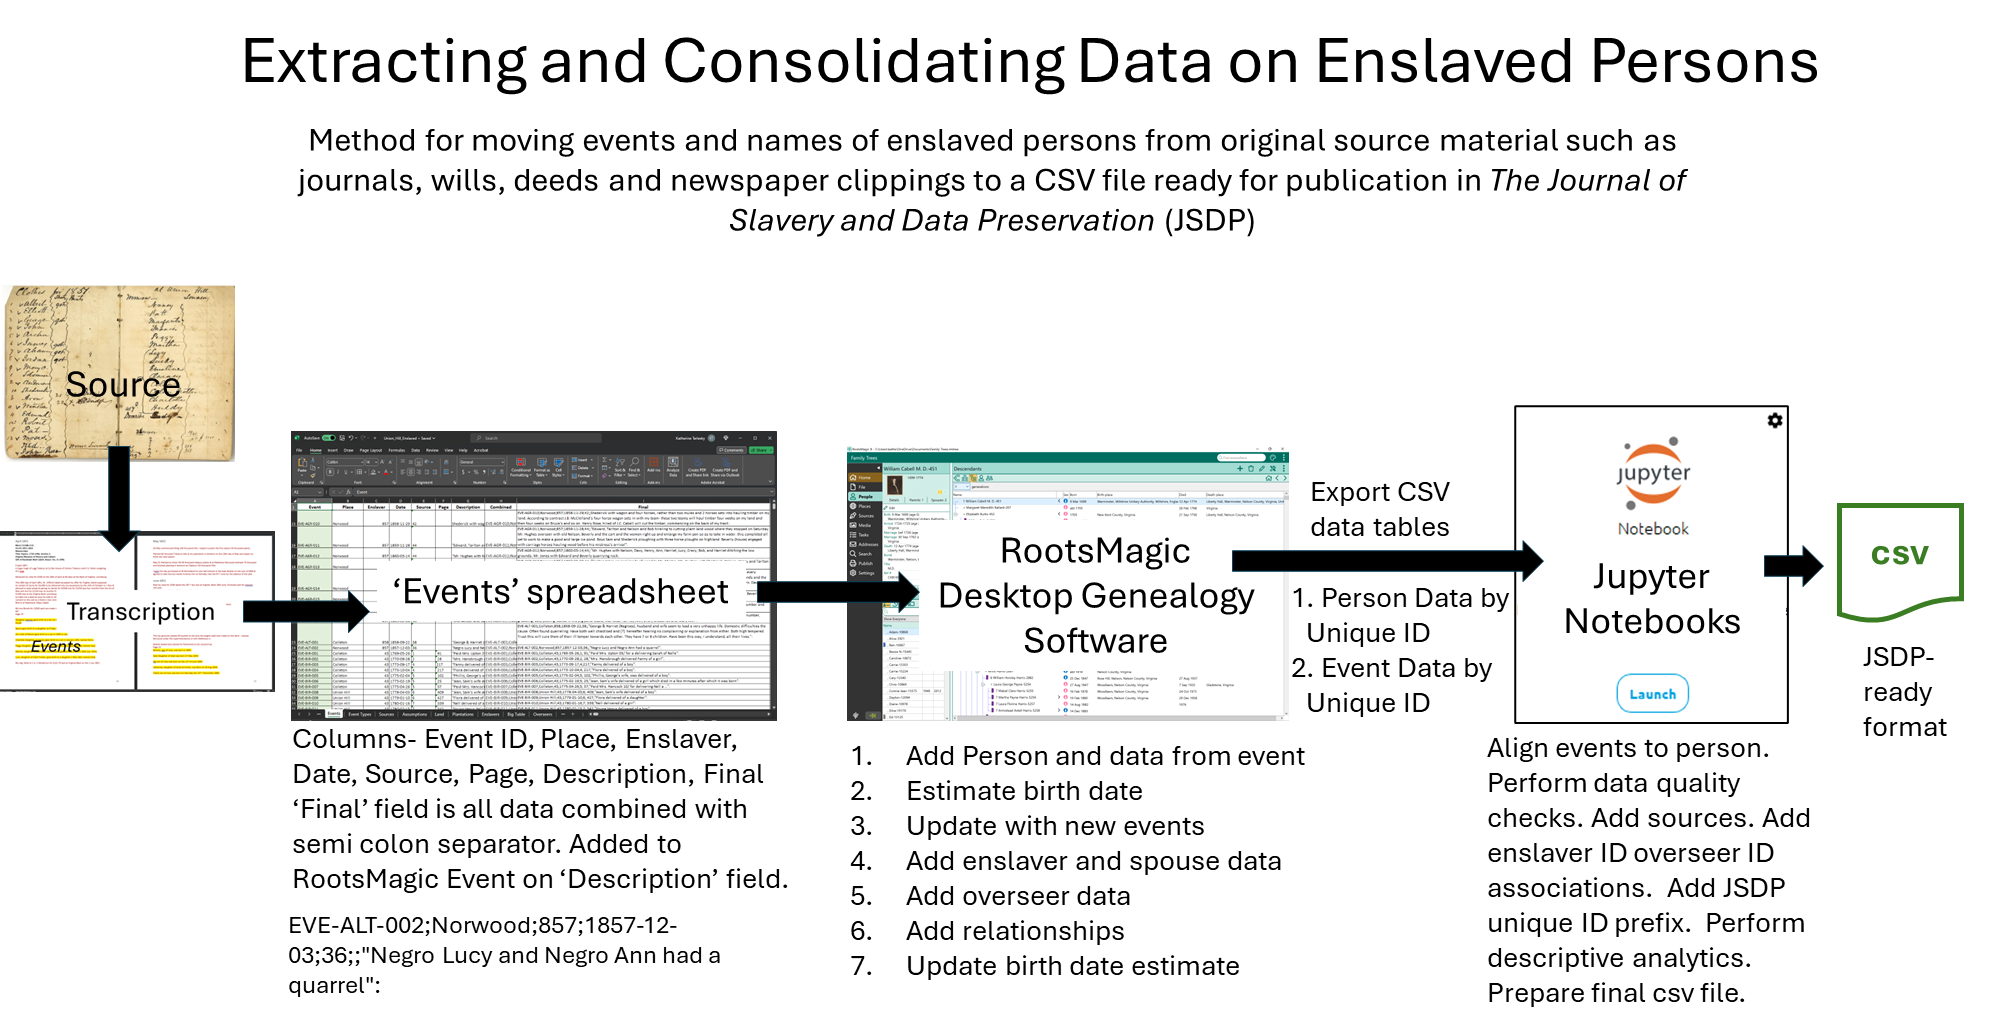

In [1]:
from IPython import display
display.Image(filename="Methodology.png", width=1000, height=1000)

In [2]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import seaborn as sns

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib import rcParams
import matplotlib.animation as animation
from matplotlib.patches import Rectangle
import matplotlib.ticker as ticker

import missingno as msno

#import datetime module
import datetime

print('Libraries imported.')

Libraries imported.


## Common Functions

In [3]:
#Trim whitespace from ends of each value across all series in dataframe
def trim_all_columns(df):
    trim_strings = lambda x: x.strip() if isinstance(x, str) else x
    return df.map(trim_strings)

## Overview of Steps in this Notebook

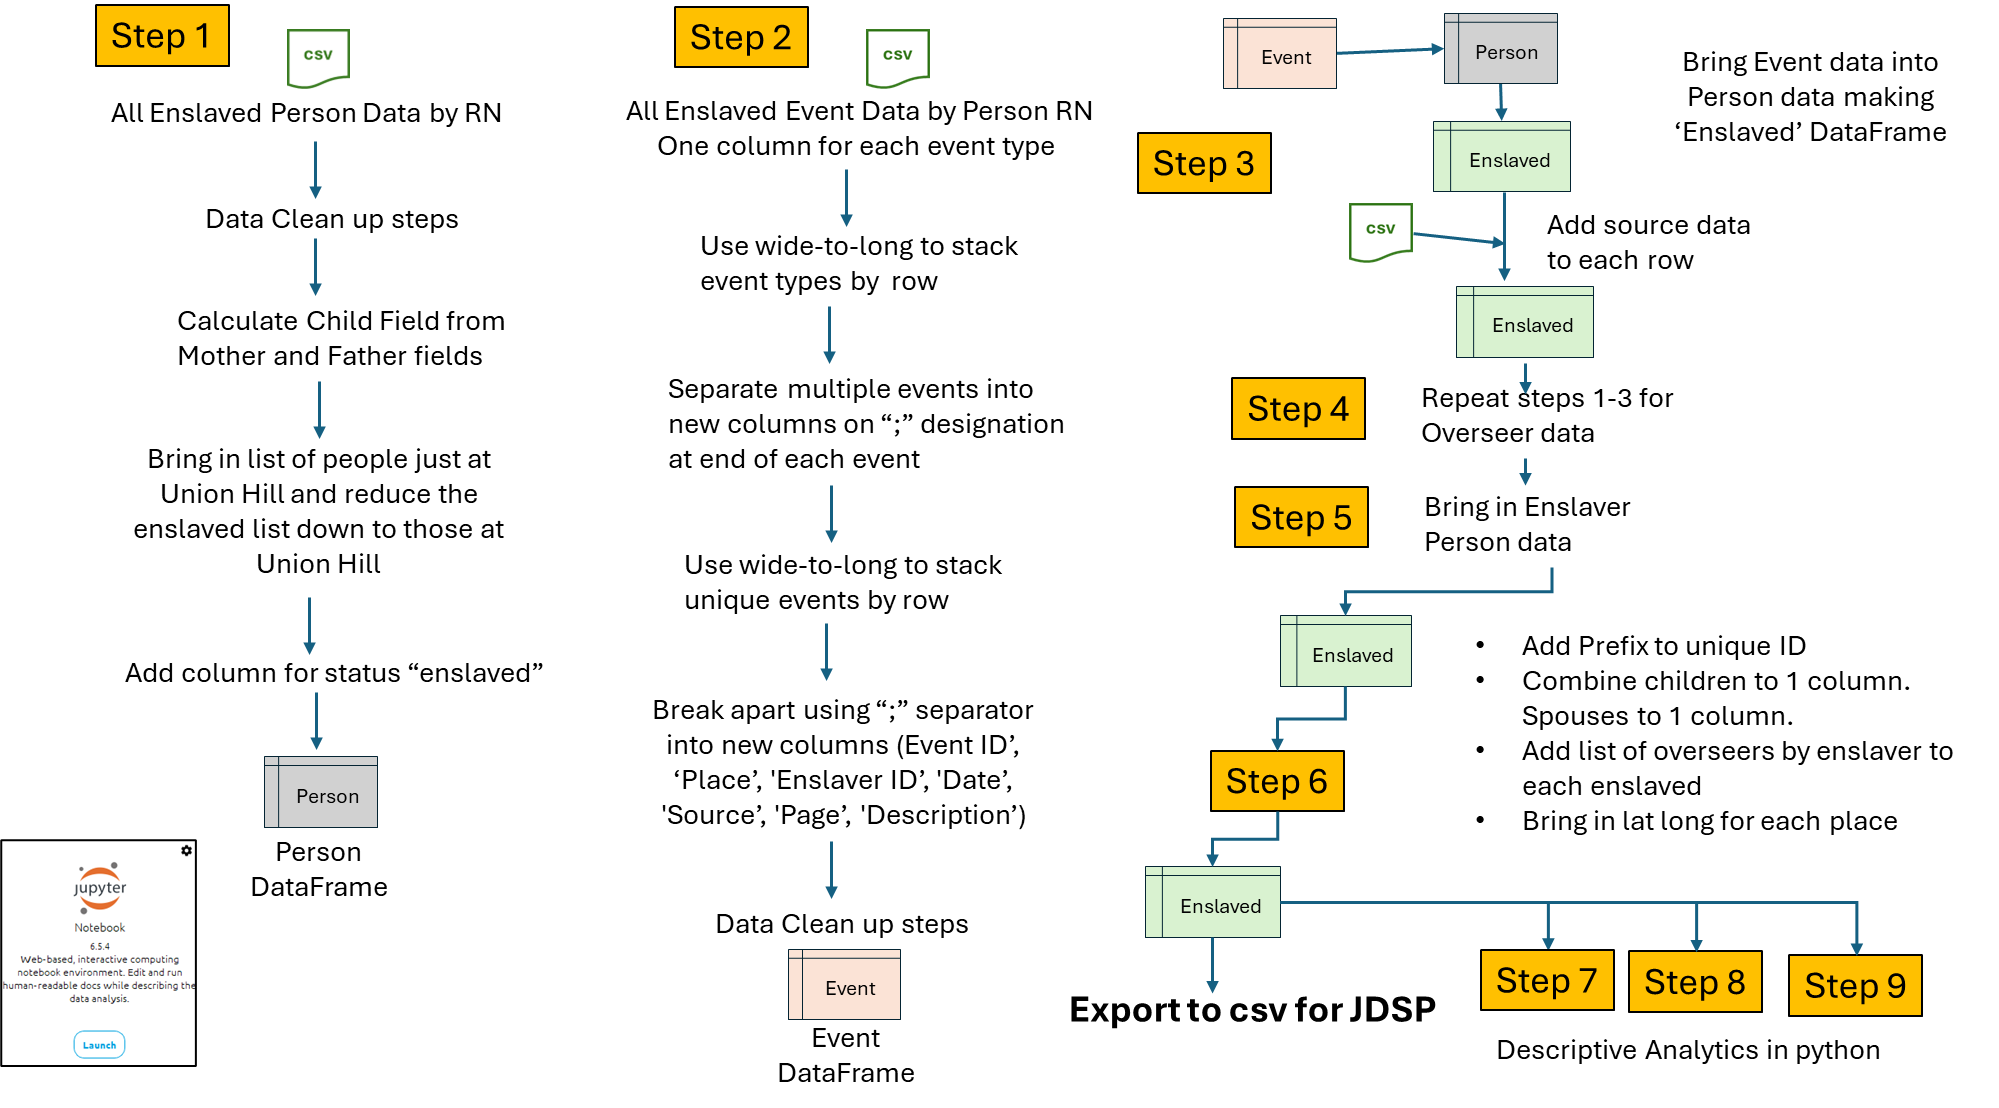

In [4]:
display.Image(filename="PythonSteps.png", width=1000, height=1000)

# STEP 1

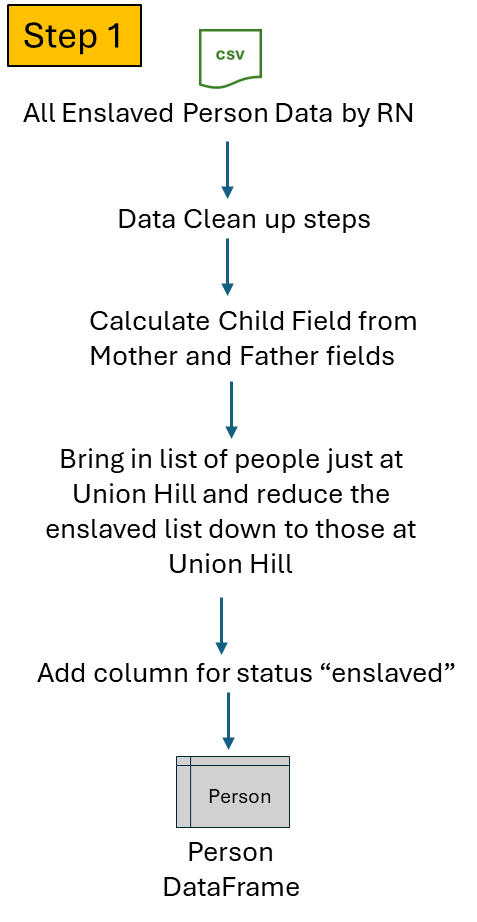

In [5]:
display.Image(filename="FirstStep.png", width=250, height=400)

## Bring in File of Enslaved Person Data from RootsMagic

In [6]:
#import the Masterfile CSV to work with and a column for "order"
file = "EnslavedPersonData_03092024.csv"
person = pd.read_csv(file)
person = trim_all_columns(person)
person = person.rename(columns={'Nickname':'Alternate Name'})
person = person.replace(to_replace='[Unknown] [Unknown]-0', value=np.NaN)

print(person.shape)
person.head()

(707, 10)


,RN,Given Name,Alternate Name,Surname,Sex,Birthdate,Deathdate,Father,Mother,Spouse
0,708,Abby,NaN,NaN,F,abt 1793,NaN,NaN,NaN,NaN
1,639,Abel,NaN,NaN,M,bef 1773,NaN,NaN,NaN,NaN
2,199,Abraham,NaN,NaN,M,1796,NaN,NaN,Lett -86,NaN
3,620,Abraham,NaN,NaN,M,abt 1797,NaN,NaN,"Cate ""Creasy's daughter"" -78",NaN
4,1035,Abraham,NaN,NaN,M,bef 1798,NaN,NaN,Esther -1037,NaN


### Data Clean Up Steps- Remove names from Spouse and Parents - just Keep RN

In [7]:
person[['Spouse','Mother','Father']] = person[['Spouse','Mother','Father']].replace(regex=[r'\D+'], value="")
person = person.sort_values('Mother')
person.head(10)

,RN,Given Name,Alternate Name,Surname,Sex,Birthdate,Deathdate,Father,Mother,Spouse
189,97,George,NaN,NaN,M,bef 1762,NaN,14,1,615
294,121,Joshua,NaN,NaN,M,bef 1765,NaN,14,1,NaN
563,102,Unknown,Molly's girl,NaN,F,29 Dec 1795,NaN,NaN,101,NaN
453,941,Rebecca,NaN,NaN,F,bef 1856,NaN,297,1026,NaN
672,1338,George,NaN,Jemmeson,M,1862,NaN,663,1032,NaN
669,1335,Charlotte,NaN,Jemmeson,F,1863,NaN,663,1032,NaN
670,1337,Elijah,NaN,Jemmeson,M,1859,NaN,663,1032,NaN
673,1336,Mariah,NaN,Jemmeson,F,abt 1856,NaN,663,1032,NaN
4,1035,Abraham,NaN,NaN,M,bef 1798,NaN,NaN,1037,NaN
603,1073,Charlotte,NaN,Banks,F,1836,NaN,1065,1067,NaN


### Convert Birth and Death dates to format-YY-MM-DD and add Birth year for analytics

##### Make a dictionary of months by name and number

In [8]:
month = {"Jan": 1, 'Feb':2,'Mar':3,'Apr':4,'May':5,'Jun':6,'Jul':7,'Aug':8,'Sep':9,'Oct':10,'Nov':11,'Dec':12}

In [9]:
hold =person[['RN','Birthdate']]
hold= hold.sort_values('RN').set_index('RN')
hold = hold['Birthdate'].str.split(pat=' ', expand=True).fillna(np.NaN)
hold.head()

,0,1,2
RN,,,
1,bef,1745,NaN
2,bef,1766,NaN
3,25,Sep,1780
4,bef,1761,NaN
5,abt,1760,NaN


In [10]:
#replace mnth names with numbers in column 1
hold = hold.replace({1: month})
#reorder columns
hold= hold[[2,1,0]]
#add 'Birthyear' column for analytics later
hold['Birthyear'] = hold[2]
#move over Year value from columns that contain the year value
hold['Birthyear'] = hold['Birthyear'].fillna(hold[1])
hold['Birthyear'] = hold['Birthyear'].fillna(hold[0])
hold.head()

,2,1,0,Birthyear
RN,,,,
1,NaN,1745,bef,1745
2,NaN,1766,bef,1766
3,1780,9,25,1780
4,NaN,1761,bef,1761
5,NaN,1760,abt,1760


In [11]:
BYhold = hold[['Birthyear']]
#drop rows with no birth year
hold=hold.dropna(subset=2)
#convert numbers to string for concatenation into date format
hold = hold.astype(str)
#Create new column for correct format birthdate
hold['Birth date'] = hold[[2,1,0]].agg('-'.join, axis=1)
hold = hold.drop(columns={2,1,0,'Birthyear'})
hold.head()

,Birth date
RN,
3,1780-9-25
15,1724-1-1
53,1769-5-26
56,1770-9-28
57,1773-9-17


#### Merge back into person dataframe

In [12]:
person=person.sort_values('RN').set_index('RN')
person = person.join(hold)

person['Birth date'] = person['Birth date'].fillna(person['Birthdate'])
person = person.join(BYhold).drop(columns={'Birthdate'})
#person = person.drop(columns={'Birthdate'})

person=person.reset_index()
print(person.shape)
person.head()

(707, 11)


,RN,Given Name,Alternate Name,Surname,Sex,Deathdate,Father,Mother,Spouse,Birth date,Birthyear
0,1,Venus,NaN,NaN,F,NaN,NaN,NaN,14,bef 1745,1745
1,2,Hannah,NaN,NaN,F,NaN,NaN,NaN,NaN,bef 1766,1766
2,3,Phill,NaN,NaN,M,NaN,NaN,2,NaN,1780-9-25,1780
3,4,Greenock,NaN,NaN,M,NaN,NaN,NaN,NaN,bef 1761,1761
4,5,Mingo,NaN,NaN,M,NaN,NaN,NaN,NaN,abt 1760,1760


### Clean up Death Dates using same method

In [13]:
hold =person[['RN','Deathdate']]
hold= hold.sort_values('RN').set_index('RN')
hold = hold['Deathdate'].str.split(pat=' ', expand=True).fillna(np.NaN)

hold=hold.dropna(subset=2)
print(hold.shape)
hold.head()

(32, 3)


,0,1,2
RN,,,
6,3,Aug,1773
14,20,Sep,1795
15,28,Sep,1784
18,7,May,1789
26,21,Jan,1790


In [14]:
hold = hold.replace({1: month})
hold= hold[[2,1,0]]
#move over Year value from columns that contain the year value
hold['Deathyear'] = hold[2]
hold['Deathyear'] = hold['Deathyear'].fillna(hold[1])
hold['Deathyear'] = hold['Deathyear'].fillna(hold[0])

DYhold = hold[['Deathyear']]
hold = hold.astype(str)
hold['Death date'] = hold[[2,1,0]].agg('-'.join, axis=1)
hold = hold.drop(columns={2,1,0,'Deathyear'})
print(hold.shape)
hold.head()

(32, 1)


,Death date
RN,
6,1773-8-3
14,1795-9-20
15,1784-9-28
18,1789-5-7
26,1790-1-21


In [15]:
person=person.sort_values('RN').set_index('RN')
person = person.join(hold)
person['Death date'] = person['Death date'].fillna(person['Deathdate'])
person = person.join(DYhold)
person = person.drop(columns={'Deathdate'})
person=person.reset_index()
print(person.shape)
person.head()

(707, 12)


,RN,Given Name,Alternate Name,Surname,Sex,Father,Mother,Spouse,Birth date,Birthyear,Death date,Deathyear
0,1,Venus,NaN,NaN,F,NaN,NaN,14,bef 1745,1745,NaN,NaN
1,2,Hannah,NaN,NaN,F,NaN,NaN,NaN,bef 1766,1766,NaN,NaN
2,3,Phill,NaN,NaN,M,NaN,2,NaN,1780-9-25,1780,NaN,NaN
3,4,Greenock,NaN,NaN,M,NaN,NaN,NaN,bef 1761,1761,NaN,NaN
4,5,Mingo,NaN,NaN,M,NaN,NaN,NaN,abt 1760,1760,NaN,NaN


### Add columns for children of each person based on data from 'Mother' and 'Father' fields

In [16]:
#create dataframe of Mothers
df = person[['Mother','RN']]
df = df.dropna().sort_values(['Mother','RN'])
df= df.astype(int)
print(df.shape)
df.head()

(215, 2)


,Mother,RN
81,1,97
98,1,121
86,101,102
492,1026,941
702,1032,1335


### Move all children into row with Mother RN

In [17]:
#determine the number of children for each mother
df['count'] = df.groupby('Mother').cumcount()
df = df.sort_values(['Mother','count'])
#pivot the dataframe to create a column for each child
df = df.pivot(index=['Mother'], columns='count', values='RN').reset_index()
df =df.rename(columns={0:'Child1',1:'Child2',2:'Child3',3:'Child4',4:'Child5',5:'Child6',6:'Child7',7:'Child8',8:'Child9','Mother':'RN'})
df.head()

count,RN,Child1,Child2,Child3,Child4,Child5,Child6,Child7,Child8,Child9
0,1,97.0,121.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,3.0,98.0,617.0,618.0,1240.0,NaN,NaN,NaN,NaN
2,19,36.0,56.0,57.0,NaN,NaN,NaN,NaN,NaN,NaN
3,20,41.0,85.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,22,58.0,66.0,77.0,84.0,NaN,NaN,NaN,NaN,NaN


### Repeat for Father and children

In [18]:
#create dataframe of Fathers
dff = person[['Father','RN']]
dff = dff.dropna().sort_values(['Father','RN'])
dff= dff.astype(int)
print(dff.shape)
dff = dff[dff['Father']!=0]
print(dff.shape)
dff['count'] = dff.groupby('Father').cumcount()
dff = dff.sort_values(['Father','count'])
dff = dff.pivot(index=['Father'], columns='count', values='RN').reset_index()
dff =dff.rename(columns={0:'Child1',1:'Child2',2:'Child3',3:'Child4',4:'Child5',5:'Child6',6:'Child7',7:'Child8',8:'Child9','Father':'RN'})
dff.head()

(115, 2)
(115, 2)


count,RN,Child1,Child2,Child3,Child4,Child5,Child6,Child7,Child8,Child9
0,8,36.0,56.0,57.0,NaN,NaN,NaN,NaN,NaN,NaN
1,14,97.0,121.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,25,35.0,60.0,80.0,NaN,NaN,NaN,NaN,NaN,NaN
3,37,39.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,62,65.0,79.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Concatenate Join Mother and Father together

In [19]:
children = pd.concat([df,dff]).sort_values('RN').set_index('RN')
print(children.shape)
children.head()

(129, 9)


count,Child1,Child2,Child3,Child4,Child5,Child6,Child7,Child8,Child9
RN,,,,,,,,,
1,97.0,121.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3.0,98.0,617.0,618.0,1240.0,NaN,NaN,NaN,NaN
8,36.0,56.0,57.0,NaN,NaN,NaN,NaN,NaN,NaN
14,97.0,121.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19,36.0,56.0,57.0,NaN,NaN,NaN,NaN,NaN,NaN


### Rejoin Children data to person Dataframe

In [20]:
person = person.sort_values('RN').set_index('RN')
person = person.join(children).reset_index()

person['Status'] = 'Enslaved'
print(person.shape)
person.head()

(707, 22)


,RN,Given Name,Alternate Name,Surname,Sex,Father,Mother,Spouse,Birth date,Birthyear,Death date,Deathyear,Child1,Child2,Child3,Child4,Child5,Child6,Child7,Child8,Child9,Status
0,1,Venus,NaN,NaN,F,NaN,NaN,14,bef 1745,1745,NaN,NaN,97.0,121.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Enslaved
1,2,Hannah,NaN,NaN,F,NaN,NaN,NaN,bef 1766,1766,NaN,NaN,3.0,98.0,617.0,618.0,1240.0,NaN,NaN,NaN,NaN,Enslaved
2,3,Phill,NaN,NaN,M,NaN,2,NaN,1780-9-25,1780,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Enslaved
3,4,Greenock,NaN,NaN,M,NaN,NaN,NaN,bef 1761,1761,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Enslaved
4,5,Mingo,NaN,NaN,M,NaN,NaN,NaN,abt 1760,1760,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Enslaved


### Insert column for 'Spouse2' to help concatenate step later on

In [21]:
person.loc[:, "Spouse2"] = np.NaN

In [22]:
person[person['RN']==191]

,RN,Given Name,Alternate Name,Surname,Sex,Father,Mother,Spouse,Birth date,Birthyear,Death date,Deathyear,Child1,Child2,Child3,Child4,Child5,Child6,Child7,Child8,Child9,Status,Spouse2
154,191,Sucky,NaN,NaN,F,NaN,NaN,792,bef 1789,1789,1859-5-14,1859,751.0,793.0,836.0,852.0,881.0,NaN,NaN,NaN,NaN,Enslaved,NaN


# STEP 2

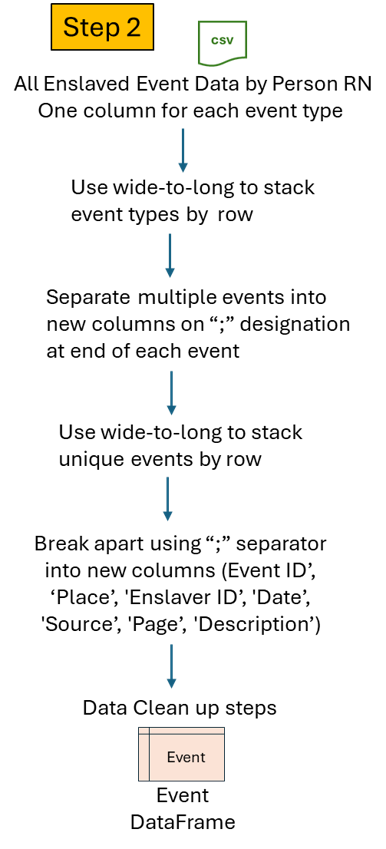

In [23]:
display.Image(filename="SecondStep.png", width=250, height=400)

## Bring in Enslaved Event Data

### REMOVE QUOTATION MARKS FROM EXCEL BEFORE IMPORTING

In [24]:
file = "EnslavedEventData_03112024.csv"
events = pd.read_csv(file)
events = trim_all_columns(events)

print(events.shape)
events.head()

(707, 31)


,RN,EVE-BIR,EVE-DEA,EVE-TRF,EVE-CRM,EVE-DIS,EVE-CRT,EVE-PRO,EVE-NEC,EVE-ENS,EVE-MED,EVE-RES,EVE-HIR,EVE-LAB,EVE-DOM,EVE-TRV,EVE-ADV,EVE-TAX,EVE-WILL,EVE-CRF,EVE-RET,EVE-OVR,EVE-PUN,EVE-MIL,EVE-ALT,EVE-AGR,EVE-EMN,EVE-CEN,EVE-CEM,EVE-ILL,EVE-MAR
0,708,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EVE-ENS-008;Soldier's Joy;272;1818;;;Enslaved ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EVE-PRO-019;Soldier's Joy;1065;1823-11-24;21;1...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,639,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EVE-ENS-008;Soldier's Joy;272;1818;;;Enslaved ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EVE-PRO-018;Soldier's Joy;1065;1823-11-24;21;1...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,199,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EVE-ENS-001;Colleton;43;1798;;;Enslaved by Wil...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EVE-PRO-001;Union Hill;43;1800-01-01;14;;Negro...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,620,NaN,NaN,NaN,NaN,NaN,EVE-CRT-005;Montezuma;271;1805-05-17;68;;Hecto...,NaN,NaN,EVE-ENS-090;Unknown;0;1808;;;Enslaver Unknown:...,NaN,NaN,NaN,NaN,NaN,NaN,EVE-ADV-007;Montezuma;271;1807-12-31;65;;Adver...,NaN,EVE-PRO-016;Montezuma;271;1807-02-26;19;444;Ag...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1035,NaN,NaN,EVE-TFR-031;Union Hill;44;1816;13;418;Changes ...,NaN,NaN,NaN,NaN,NaN,EVE-ENS-005;Union Hill;44;1810;;;Enslaved by W...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EVE-TAX-007;Union Hill;44;1810;14;;Date Estima...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Use wide-to-long to get the events stacked

In [25]:
events = pd.wide_to_long(events, stubnames='EVE',i='RN', j='type',sep='-', suffix= '\D+')#text suffixes
events= events.reset_index().drop(columns={'type'}).sort_values('RN').set_index('RN').dropna()
events = trim_all_columns(events)

print(events.shape)
events.head()

(2403, 1)


,EVE
RN,
1,EVE-ENS-001;Colleton;43;1770;;;Enslaved by Wil...
1,EVE-NEC-002;Colleton;43;1770-09-22;2; 27;Blank...
1,EVE-BIR-013;Union Hill;43;1780-09-25;7; 360;Th...
2,EVE-CRT-005;Montezuma;271;1805-05-17;68;;Hecto...
2,EVE-PRO-001;Union Hill;43;1800-01-01;14;;Negro...


### Remove the last ":" colon in each event row - THIS STEP IS CRITICAL

In [26]:
events['EVE'] = events['EVE'].str[:-1]
print(events.shape)
events.head(10)

(2403, 1)


,EVE
RN,
1,EVE-ENS-001;Colleton;43;1770;;;Enslaved by Wil...
1,EVE-NEC-002;Colleton;43;1770-09-22;2; 27;Blank...
1,EVE-BIR-013;Union Hill;43;1780-09-25;7; 360;Th...
2,EVE-CRT-005;Montezuma;271;1805-05-17;68;;Hecto...
2,EVE-PRO-001;Union Hill;43;1800-01-01;14;;Negro...
2,EVE-ADV-007;Montezuma;271;1807-12-31;65;;Adver...
2,EVE-ENS-001;Colleton;43;1770;;;Enslaved by Wil...
2,EVE-BIR-013;Union Hill;43;1780-09-25;7; 360;Th...
2,EVE-PRO-016;Montezuma;271;1807-02-26;19;444;Ag...


### Sort rows by RN and use new index as unique identifier

In [27]:
events = events.reset_index().reset_index().rename(columns={'index':'Order'}).set_index(['Order','RN'])
events.head()

,,EVE
Order,RN,
0,1,EVE-ENS-001;Colleton;43;1770;;;Enslaved by Wil...
1,1,EVE-NEC-002;Colleton;43;1770-09-22;2; 27;Blank...
2,1,EVE-BIR-013;Union Hill;43;1780-09-25;7; 360;Th...
3,2,EVE-CRT-005;Montezuma;271;1805-05-17;68;;Hecto...
4,2,EVE-PRO-001;Union Hill;43;1800-01-01;14;;Negro...


### Now use String Split to separate out multiple events on ":" colon

In [28]:
events =events['EVE'].str.split(pat=':', expand=True).fillna(np.NaN)
events= events.rename(columns={0:'EVE-A',1:'EVE-B',2:'EVE-C',3:'EVE-D',4:'EVE-D',5:'EVE-E',6:'EVE-F',7:'EVE-G',8:'EVE-H',9:'EVE-I',10:'EVE-J',11:'EVE-K',12:'EVE-L',13:'EVE-M',14:'EVE-N',15:'EVE-O',16:'EVE-P',17:'EVE-Q',18:'EVE-R',19:'EVE-S',20:'EVE-T'})
events = events.reset_index()
events = trim_all_columns(events)
print(events.shape)
events.head()

(2403, 21)


,Order,RN,EVE-A,EVE-B,EVE-C,EVE-D,EVE-D,EVE-E,EVE-F,EVE-G,EVE-H,EVE-I,EVE-J,EVE-K,EVE-L,EVE-M,EVE-N,EVE-O,EVE-P,EVE-Q,EVE-R
0,0,1,EVE-ENS-001;Colleton;43;1770;;;Enslaved by Wil...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,EVE-NEC-002;Colleton;43;1770-09-22;2; 27;Blank...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1,EVE-BIR-013;Union Hill;43;1780-09-25;7; 360;Th...,EVE-BIR-017;Union Hill;43;1783-11-05;8; 37;Cre...,EVE-BIR-020;Union Hill;43;1785-08-14;8; 89;Sam...,EVE-BIR-021;Union Hill;43;1785-09-22;8; 91;You...,EVE-BIR-026;Union Hill;43;1787-03-03;8; 139;Lu...,EVE-BIR-033;Union Hill;43;1795-07-25;8;303;Han...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,2,EVE-CRT-005;Montezuma;271;1805-05-17;68;;Hecto...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,2,EVE-PRO-001;Union Hill;43;1800-01-01;14;;Negro...,EVE-PRO-004;Union Hill;43;1800-01-02;14;;List ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### And stack again using wide-to-long

In [29]:
events = pd.wide_to_long(events, stubnames='EVE',i=['Order','RN'], j='type',sep='-', suffix= '\D+')#text suffixes
events= events.reset_index().drop(columns={'type','Order'}).drop_duplicates().dropna().sort_values('RN').set_index('RN')
print(events.shape)
events.head(10)

(3904, 1)


,EVE
RN,
1,EVE-ENS-001;Colleton;43;1770;;;Enslaved by Wil...
1,EVE-NEC-002;Colleton;43;1770-09-22;2; 27;Blank...
1,EVE-BIR-013;Union Hill;43;1780-09-25;7; 360;Th...
1,EVE-BIR-017;Union Hill;43;1783-11-05;8; 37;Cre...
1,EVE-BIR-020;Union Hill;43;1785-08-14;8; 89;Sam...
1,EVE-BIR-021;Union Hill;43;1785-09-22;8; 91;You...
1,EVE-BIR-026;Union Hill;43;1787-03-03;8; 139;Lu...
1,EVE-BIR-033;Union Hill;43;1795-07-25;8;303;Han...
2,EVE-PRO-016;Montezuma;271;1807-02-26;19;444;Ag...


### Now break out to columns for each event using the existing semicolon separator

In [30]:
events =events['EVE'].str.split(pat=';', expand=True)
events = events.rename(columns={0:'Event ID',1:'Place',2:'Enslaver ID',3:'Date',4:'Source',5:'Page',6:'Description'})
events.head()

,Event ID,Place,Enslaver ID,Date,Source,Page,Description
RN,,,,,,,
1,EVE-ENS-001,Colleton,43,1770,,,"Enslaved by William Cabell, Sr."
1,EVE-NEC-002,Colleton,43,1770-09-22,2,27,Blankets gave out 1770. 2 Fanny and her childr...
1,EVE-BIR-013,Union Hill,43,1780-09-25,7,360,The night of the 25 Hannah delivered of a boy ...
1,EVE-BIR-017,Union Hill,43,1783-11-05,8,37,Creasy delivered of a girl by Venus
1,EVE-BIR-020,Union Hill,43,1785-08-14,8,89,Sam J. Cabell’s Fanny delivered of a boy by ol...


In [31]:
events['Source'] = events['Source'].replace(to_replace='', value=0)
events['Source'].value_counts().tail()

Source
34    2
54    1
22    1
3     1
60    1
Name: count, dtype: int64

### Data Clean-up

In [32]:
events['Place'].value_counts()

Place
Union Hill                               1675
Soldier's Joy                             624
Colleton                                  461
Montezuma                                 376
Norwood                                   265
Unknown                                   110
Glenmore                                  109
Benvenue                                   76
Lovingston, Nelson, Virginia               37
Rose Hill                                  30
New Glasgow, Amherst County, Virginia      20
Philadelphia, Pennsylvania                 15
Mountain View, Clifford, Amherst           12
Richmond, Virginia                         11
Oak Ridge                                   9
Amherst                                     8
Liberty Hall                                5
Rock Cliff                                  5
Buckingham County, Virginia                 5
Williamsburg, Virginia                      4
Midway                                      4
Halifax County, Virginia    

### Add column for Event type

In [33]:
events['Event Type'] = events['Event ID'].str[:-4]
events['Event Type'] = events['Event Type'].replace(to_replace='EVE-NEC', value='Necessities').replace(to_replace='EVE-DEA', value='Death').replace(to_replace='EVE-CRM', value='Crime')\
                                           .replace(to_replace='EVE-BIR', value='Birth').replace(to_replace='EVE-TRV', value='Travel').replace(to_replace='EVE-TFR', value='Transfer')\
                                           .replace(to_replace='EVE-LAB', value='Labor').replace(to_replace='EVE-DOM', value='Domestic').replace(to_replace='EVE-MED', value='Medical')\
                                           .replace(to_replace='EVE-AGR', value='Agriculture').replace(to_replace='EVE-TAX', value='Tax').replace(to_replace='EVE-MAR', value='Marriage')\
                                           .replace(to_replace='EVE-CFT', value='Craft').replace(to_replace='EVE-WILL', value='Will').replace(to_replace='EVE-RES', value='Residence')\
                                           .replace(to_replace='EVE-DIS', value='Disappeared').replace(to_replace='EVE-HIR', value='Hiring').replace(to_replace='EVE-PRO', value='Probate')\
                                           .replace(to_replace='EVE-ADV', value='Advertisement').replace(to_replace='EVE-PUN', value='Punishment').replace(to_replace='EVE-ALT', value='Altercation')\
                                           .replace(to_replace='EVE-MIL', value='Military').replace(to_replace='EVE-RET', value='Returned').replace(to_replace='EVE-OVR', value='Overseer Contract')\
                                           .replace(to_replace='EVE-EMP', value='Employed').replace(to_replace='EVE-ILL', value='Illness').replace(to_replace='EVE-CEN', value='Census')\
                                           .replace(to_replace='EVE-CEM', value='Cemetery').replace(to_replace='EVE-EMN', value='Emancipation').replace(to_replace='EVE-CRT', value='Court')\
                                           .replace(to_replace='EVE-REL', value='Relocation').replace(to_replace='EVE-ENS', value='Enslaved')
events.head()

,Event ID,Place,Enslaver ID,Date,Source,Page,Description,Event Type
RN,,,,,,,,
1,EVE-ENS-001,Colleton,43,1770,0,,"Enslaved by William Cabell, Sr.",Enslaved
1,EVE-NEC-002,Colleton,43,1770-09-22,2,27,Blankets gave out 1770. 2 Fanny and her childr...,Necessities
1,EVE-BIR-013,Union Hill,43,1780-09-25,7,360,The night of the 25 Hannah delivered of a boy ...,Birth
1,EVE-BIR-017,Union Hill,43,1783-11-05,8,37,Creasy delivered of a girl by Venus,Birth
1,EVE-BIR-020,Union Hill,43,1785-08-14,8,89,Sam J. Cabell’s Fanny delivered of a boy by ol...,Birth


In [34]:
#Check for duplicate events under a person
test = events.groupby('RN')['Event ID'].value_counts().to_frame().reset_index().sort_values('count', ascending=False)
test.head(10)

,RN,Event ID,count
2912,913,EVE-ENS-045,2
2607,843,EVE-ENS-014,1
2594,842,EVE-HIR-003,1
2595,842,EVE-CEN-002,1
2596,842,EVE-ENS-006,1
2597,842,EVE-HIR-001,1
2598,843,EVE-ILL-018,1
2599,843,EVE-AGR-005,1
2600,843,EVE-AGR-006,1
2601,843,EVE-AGR-011,1


### Add Column for Year

In [35]:
events['Year'] = events['Date'].str[:4]
events['Year'] = events['Year'].astype(int)
events.head()

,Event ID,Place,Enslaver ID,Date,Source,Page,Description,Event Type,Year
RN,,,,,,,,,
1,EVE-ENS-001,Colleton,43,1770,0,,"Enslaved by William Cabell, Sr.",Enslaved,1770
1,EVE-NEC-002,Colleton,43,1770-09-22,2,27,Blankets gave out 1770. 2 Fanny and her childr...,Necessities,1770
1,EVE-BIR-013,Union Hill,43,1780-09-25,7,360,The night of the 25 Hannah delivered of a boy ...,Birth,1780
1,EVE-BIR-017,Union Hill,43,1783-11-05,8,37,Creasy delivered of a girl by Venus,Birth,1783
1,EVE-BIR-020,Union Hill,43,1785-08-14,8,89,Sam J. Cabell’s Fanny delivered of a boy by ol...,Birth,1785


## Join Enslaved Person and Event Data together into final `Enslaved` DataFrame

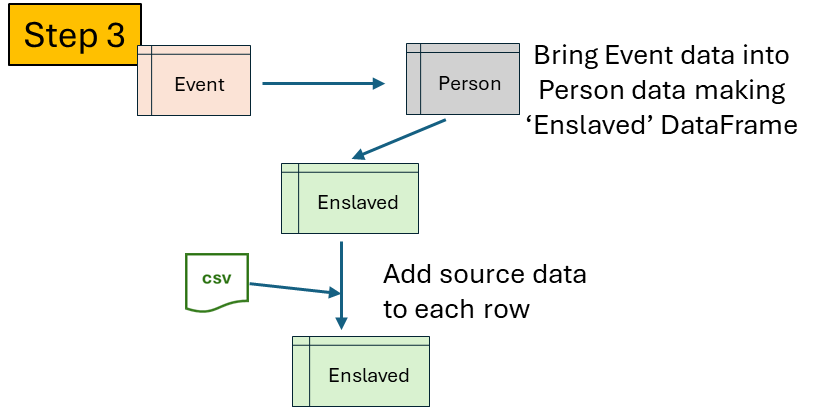

In [36]:
display.Image(filename="ThirdStep.png", width=700, height=700)

In [37]:
person = person.sort_values('RN').set_index('RN')
enslaved = person.join(events, how='left')
print(enslaved.shape)
enslaved.head()

(3905, 31)


,Given Name,Alternate Name,Surname,Sex,Father,Mother,Spouse,Birth date,Birthyear,Death date,Deathyear,Child1,Child2,Child3,Child4,Child5,Child6,Child7,Child8,Child9,Status,Spouse2,Event ID,Place,Enslaver ID,Date,Source,Page,Description,Event Type,Year
RN,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,Venus,NaN,NaN,F,NaN,NaN,14,bef 1745,1745,NaN,NaN,97.0,121.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Enslaved,NaN,EVE-ENS-001,Colleton,43,1770,0,,"Enslaved by William Cabell, Sr.",Enslaved,1770.0
1,Venus,NaN,NaN,F,NaN,NaN,14,bef 1745,1745,NaN,NaN,97.0,121.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Enslaved,NaN,EVE-NEC-002,Colleton,43,1770-09-22,2,27,Blankets gave out 1770. 2 Fanny and her childr...,Necessities,1770.0
1,Venus,NaN,NaN,F,NaN,NaN,14,bef 1745,1745,NaN,NaN,97.0,121.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Enslaved,NaN,EVE-BIR-013,Union Hill,43,1780-09-25,7,360,The night of the 25 Hannah delivered of a boy ...,Birth,1780.0
1,Venus,NaN,NaN,F,NaN,NaN,14,bef 1745,1745,NaN,NaN,97.0,121.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Enslaved,NaN,EVE-BIR-017,Union Hill,43,1783-11-05,8,37,Creasy delivered of a girl by Venus,Birth,1783.0
1,Venus,NaN,NaN,F,NaN,NaN,14,bef 1745,1745,NaN,NaN,97.0,121.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Enslaved,NaN,EVE-BIR-020,Union Hill,43,1785-08-14,8,89,Sam J. Cabell’s Fanny delivered of a boy by ol...,Birth,1785.0


## Add Source data

In [38]:
enslaved = enslaved.reset_index()
enslaved = enslaved[['RN','Given Name','Alternate Name','Surname','Sex','Birthyear','Birth date','Deathyear','Death date','Father','Mother','Spouse','Spouse2','Child1','Child2','Child3','Child4','Child5','Child6','Child7','Child8','Child9','Event ID','Event Type','Place','Status','Enslaver ID','Date','Year','Description','Source','Page']]
enslaved['Source'] = enslaved['Source'].astype(float)
enslaved.head()

,RN,Given Name,Alternate Name,Surname,Sex,Birthyear,Birth date,Deathyear,Death date,Father,Mother,Spouse,Spouse2,Child1,Child2,Child3,Child4,Child5,Child6,Child7,Child8,Child9,Event ID,Event Type,Place,Status,Enslaver ID,Date,Year,Description,Source,Page
0,1,Venus,NaN,NaN,F,1745,bef 1745,NaN,NaN,NaN,NaN,14,NaN,97.0,121.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EVE-ENS-001,Enslaved,Colleton,Enslaved,43,1770,1770.0,"Enslaved by William Cabell, Sr.",0.0,
1,1,Venus,NaN,NaN,F,1745,bef 1745,NaN,NaN,NaN,NaN,14,NaN,97.0,121.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EVE-NEC-002,Necessities,Colleton,Enslaved,43,1770-09-22,1770.0,Blankets gave out 1770. 2 Fanny and her childr...,2.0,27
2,1,Venus,NaN,NaN,F,1745,bef 1745,NaN,NaN,NaN,NaN,14,NaN,97.0,121.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EVE-BIR-013,Birth,Union Hill,Enslaved,43,1780-09-25,1780.0,The night of the 25 Hannah delivered of a boy ...,7.0,360
3,1,Venus,NaN,NaN,F,1745,bef 1745,NaN,NaN,NaN,NaN,14,NaN,97.0,121.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EVE-BIR-017,Birth,Union Hill,Enslaved,43,1783-11-05,1783.0,Creasy delivered of a girl by Venus,8.0,37
4,1,Venus,NaN,NaN,F,1745,bef 1745,NaN,NaN,NaN,NaN,14,NaN,97.0,121.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EVE-BIR-020,Birth,Union Hill,Enslaved,43,1785-08-14,1785.0,Sam J. Cabell’s Fanny delivered of a boy by ol...,8.0,89


In [39]:
#import the Masterfile CSV to work with and a column for "order"
file = "Sources_03082024.csv"
sources = pd.read_csv(file)
sources = trim_all_columns(sources)
print(sources.shape)
sources.head()

(74, 3)


,Source,Source Description,Repository
0,1,"Cabell, William, Sr. Commonplace books, 1769-1...","Virginia Museum of History and Culture, Richmo..."
1,2,"Cabell, William, Sr. Commonplace books, 1769-1...","Virginia Museum of History and Culture, Richmo..."
2,3,"Cabell, William, Sr. Commonplace books, 1769-1...","Virginia Museum of History and Culture, Richmo..."
3,4,"Cabell, William, Sr. Commonplace books, 1769-1...","Virginia Museum of History and Culture, Richmo..."
4,5,"Cabell, William, Sr. Commonplace books, 1769-1...","Virginia Museum of History and Culture, Richmo..."


### Prepare for joining sources to 'enslaved' dataframe

In [40]:
sources= sources.sort_values('Source').set_index('Source')
enslaved = enslaved.sort_values('Source').set_index('Source')

In [41]:
enslaved = enslaved.join(sources, how='left').reset_index()
enslaved = enslaved[['RN','Given Name','Alternate Name','Surname','Sex','Birthyear','Birth date','Deathyear','Death date','Father','Mother','Spouse','Spouse2','Child1','Child2','Child3','Child4','Child5','Child6','Child7','Child8','Child9','Event ID','Event Type','Place','Status','Enslaver ID','Date','Year','Description','Source','Source Description','Page','Repository']]
print(enslaved.shape)
enslaved.head()

(3905, 34)


,RN,Given Name,Alternate Name,Surname,Sex,Birthyear,Birth date,Deathyear,Death date,Father,Mother,Spouse,Spouse2,Child1,Child2,Child3,Child4,Child5,Child6,Child7,Child8,Child9,Event ID,Event Type,Place,Status,Enslaver ID,Date,Year,Description,Source,Source Description,Page,Repository
0,1,Venus,NaN,NaN,F,1745,bef 1745,NaN,NaN,NaN,NaN,14,NaN,97.0,121.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EVE-ENS-001,Enslaved,Colleton,Enslaved,43,1770,1770.0,"Enslaved by William Cabell, Sr.",0.0,NaN,,NaN
1,674,Henry,NaN,NaN,M,1800,abt 1800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EVE-ENS-036,Enslaved,Elm Cottage,Enslaved,677,1863-11-24,1863.0,"Enslaved by Thomas Stanhope McClelland, Jr.",0.0,NaN,,NaN
2,674,Henry,NaN,NaN,M,1800,abt 1800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EVE-ENS-012,Enslaved,Montezuma,Enslaved,283,1834,1834.0,Enslaved by Thomas Stanhope McClelland,0.0,NaN,,NaN
3,673,Julian,NaN,NaN,F,1825,abt 1825,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EVE-ENS-034,Enslaved,Montezuma,Enslaved,280,1835-10-30,1835.0,Enslaved by Margaret Cabell McClelland,0.0,NaN,,NaN
4,673,Julian,NaN,NaN,F,1825,abt 1825,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EVE-ENS-012,Enslaved,Montezuma,Enslaved,283,1834,1834.0,Enslaved by Thomas Stanhope McClelland,0.0,NaN,,NaN


## Change Status from Enslaved to Free for events after 1865 and those emancipated

In [42]:
enslaved['Status'].value_counts()

Status
Enslaved    3905
Name: count, dtype: int64

In [43]:
enslaved['Status'] = enslaved['Status'].where(enslaved['Year']<=1865,'Free')
enslaved['Status'].value_counts()

Status
Enslaved    3863
Free          42
Name: count, dtype: int64

In [44]:
enslaved['Status'] = enslaved['Status'].where(enslaved['Event Type'] !='Emancipation','Free')
enslaved['Status'].value_counts()

Status
Enslaved    3854
Free          51
Name: count, dtype: int64

In [45]:
enslaved['Status'] = enslaved['Status'].where(enslaved['Place'] !='Philadelphia, Pennsylvania','Free')
enslaved['Status'].value_counts()

Status
Enslaved    3839
Free          66
Name: count, dtype: int64

In [46]:
enslaved['Status'] = enslaved['Status'].where(enslaved['Place'] != "Bristol, Bucks, Pennsylvania",'Free')
enslaved['Status'].value_counts()

Status
Enslaved    3838
Free          67
Name: count, dtype: int64

## Narrow down to only those enslaved persons who resided at Union Hill or Neighboring Plantation (Norwood, Union Hill, Montezuma, Colleton, Soldier's Joy, Rock Cliff)

In [47]:
#import the Masterfile CSV to work with and a column for "order"
#Norwood, Union Hill, Montezuma, Colleton, Soldier's Joy, Rock Cliff
file = "UnionHill_03082024.csv"
UHill = pd.read_csv(file).drop_duplicates().sort_values('RN')
UHill = UHill["RN"].tolist()


In [48]:
enslaved['RN'] = enslaved['RN'].astype(int)
enslaved=enslaved.sort_values('RN')
print(enslaved.shape)
enslaved = enslaved.sort_values('RN')
enslaved = enslaved[enslaved['RN'].isin(UHill)]
print(enslaved.shape)
enslaved.head()

(3905, 34)
(3768, 34)


,RN,Given Name,Alternate Name,Surname,Sex,Birthyear,Birth date,Deathyear,Death date,Father,Mother,Spouse,Spouse2,Child1,Child2,Child3,Child4,Child5,Child6,Child7,Child8,Child9,Event ID,Event Type,Place,Status,Enslaver ID,Date,Year,Description,Source,Source Description,Page,Repository
0,1,Venus,NaN,NaN,F,1745,bef 1745,NaN,NaN,NaN,NaN,14,NaN,97.0,121.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EVE-ENS-001,Enslaved,Colleton,Enslaved,43,1770,1770.0,"Enslaved by William Cabell, Sr.",0.0,NaN,,NaN
1511,1,Venus,NaN,NaN,F,1745,bef 1745,NaN,NaN,NaN,NaN,14,NaN,97.0,121.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EVE-BIR-021,Birth,Union Hill,Enslaved,43,1785-09-22,1785.0,Young Venus delivered of a boy by Old Venus,8.0,"Cabell, William, Sr. Commonplace books, 1769-1...",91,"Virginia Museum of History and Culture, Richmo..."
1498,1,Venus,NaN,NaN,F,1745,bef 1745,NaN,NaN,NaN,NaN,14,NaN,97.0,121.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EVE-BIR-026,Birth,Union Hill,Enslaved,43,1787-03-03,1787.0,Luce delivered of a girl by old Venus,8.0,"Cabell, William, Sr. Commonplace books, 1769-1...",139,"Virginia Museum of History and Culture, Richmo..."
1488,1,Venus,NaN,NaN,F,1745,bef 1745,NaN,NaN,NaN,NaN,14,NaN,97.0,121.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EVE-BIR-017,Birth,Union Hill,Enslaved,43,1783-11-05,1783.0,Creasy delivered of a girl by Venus,8.0,"Cabell, William, Sr. Commonplace books, 1769-1...",37,"Virginia Museum of History and Culture, Richmo..."
1487,1,Venus,NaN,NaN,F,1745,bef 1745,NaN,NaN,NaN,NaN,14,NaN,97.0,121.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EVE-BIR-033,Birth,Union Hill,Enslaved,43,1795-07-25,1795.0,Hannah wife of young George was delivered of a...,8.0,"Cabell, William, Sr. Commonplace books, 1769-1...",303,"Virginia Museum of History and Culture, Richmo..."


#### Replace all blank spaces in dataframe with NA

In [49]:
# replace field that's entirely space (or empty) with pd.NA
enslaved = enslaved.replace(r'^\s*$', pd.NA, regex=True)
enslaved.head()

,RN,Given Name,Alternate Name,Surname,Sex,Birthyear,Birth date,Deathyear,Death date,Father,Mother,Spouse,Spouse2,Child1,Child2,Child3,Child4,Child5,Child6,Child7,Child8,Child9,Event ID,Event Type,Place,Status,Enslaver ID,Date,Year,Description,Source,Source Description,Page,Repository
0,1,Venus,NaN,NaN,F,1745,bef 1745,NaN,NaN,NaN,NaN,14,NaN,97.0,121.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EVE-ENS-001,Enslaved,Colleton,Enslaved,43,1770,1770.0,"Enslaved by William Cabell, Sr.",0.0,NaN,<NA>,NaN
1511,1,Venus,NaN,NaN,F,1745,bef 1745,NaN,NaN,NaN,NaN,14,NaN,97.0,121.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EVE-BIR-021,Birth,Union Hill,Enslaved,43,1785-09-22,1785.0,Young Venus delivered of a boy by Old Venus,8.0,"Cabell, William, Sr. Commonplace books, 1769-1...",91,"Virginia Museum of History and Culture, Richmo..."
1498,1,Venus,NaN,NaN,F,1745,bef 1745,NaN,NaN,NaN,NaN,14,NaN,97.0,121.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EVE-BIR-026,Birth,Union Hill,Enslaved,43,1787-03-03,1787.0,Luce delivered of a girl by old Venus,8.0,"Cabell, William, Sr. Commonplace books, 1769-1...",139,"Virginia Museum of History and Culture, Richmo..."
1488,1,Venus,NaN,NaN,F,1745,bef 1745,NaN,NaN,NaN,NaN,14,NaN,97.0,121.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EVE-BIR-017,Birth,Union Hill,Enslaved,43,1783-11-05,1783.0,Creasy delivered of a girl by Venus,8.0,"Cabell, William, Sr. Commonplace books, 1769-1...",37,"Virginia Museum of History and Culture, Richmo..."
1487,1,Venus,NaN,NaN,F,1745,bef 1745,NaN,NaN,NaN,NaN,14,NaN,97.0,121.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EVE-BIR-033,Birth,Union Hill,Enslaved,43,1795-07-25,1795.0,Hannah wife of young George was delivered of a...,8.0,"Cabell, William, Sr. Commonplace books, 1769-1...",303,"Virginia Museum of History and Culture, Richmo..."


# Step 4

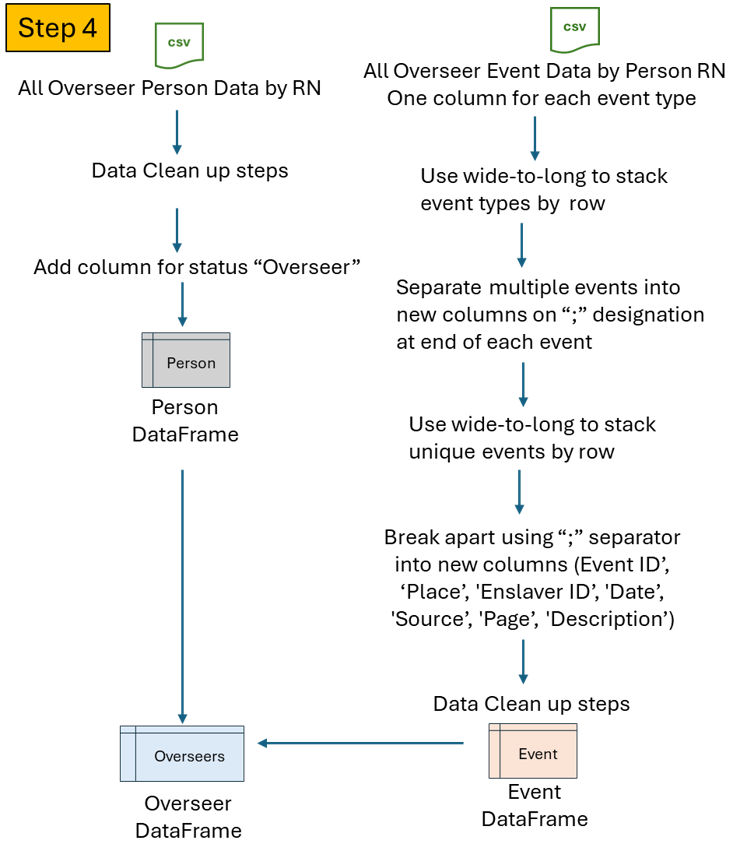

In [50]:
display.Image(filename="FourthStep.png", width=500, height=500)

## Bring in Overseer Person Data and correct date elements as done above for Enslaved persons

In [51]:
#import the Masterfile CSV to work with and a column for "order"
cols= ['RN','Given Name', 'Alternate Name', 'Surname','Sex','Birthdate','Deathdate','Father','Mother','Spouse']
file = "OverseerPersonData_02062024.csv"
OVperson = pd.read_csv(file,header=0, names=cols)
OVperson = trim_all_columns(OVperson)
print(OVperson.shape)
OVperson.head()

(47, 10)


,RN,Given Name,Alternate Name,Surname,Sex,Birthdate,Deathdate,Father,Mother,Spouse
0,343,Thomas,NaN,Appling,M,Sep 1755,3 Sep 1835,NaN,NaN,Elizabeth Austin-344
1,968,Langston,NaN,Bacon,M,bef 1779,NaN,NaN,NaN,NaN
2,346,Allen,NaN,Blair,M,1754,1834,NaN,NaN,Mary Ann Staples-368
3,969,R.,NaN,Bolton,M,bef 1797,NaN,NaN,NaN,NaN
4,405,John,NaN,Bryant,M,abt 1755,NaN,John Bryant-404,Elizabeth Hamblett-447,NaN


### Clean up birth and death dates

In [52]:
hold =OVperson[['RN','Birthdate']]
hold= hold.sort_values('RN').set_index('RN')
hold = hold['Birthdate'].str.split(pat=' ', expand=True).fillna(np.NaN)

hold = hold.replace({1: month})
hold= hold[[2,1,0]]

hold['Birthyear'] = hold[2]
hold['Birthyear'] = hold['Birthyear'].fillna(hold[1])
hold['Birthyear'] = hold['Birthyear'].fillna(hold[0])

BYhold = hold[['Birthyear']]
hold=hold.dropna(subset=2)

hold = hold.astype(str)
hold['Birth date'] = hold[[2,1,0]].agg('-'.join, axis=1)
hold = hold.drop(columns={2,1,0,'Birthyear'})
hold.head()

,Birth date
RN,
355,1767-4-16
446,1759-11-29


In [53]:
OVperson=OVperson.sort_values('RN').set_index('RN')
OVperson = OVperson.join(hold)
OVperson['Birth date'] = OVperson['Birth date'].fillna(OVperson['Birthdate'])
OVperson = OVperson.join(BYhold)
OVperson= OVperson.drop(columns={'Birthdate'})
OVperson=OVperson.reset_index()
print(OVperson.shape)
OVperson.head()

(47, 11)


,RN,Given Name,Alternate Name,Surname,Sex,Deathdate,Father,Mother,Spouse,Birth date,Birthyear
0,173,Henry,NaN,Reid,M,NaN,NaN,NaN,NaN,abt 1762,1762
1,343,Thomas,NaN,Appling,M,3 Sep 1835,NaN,NaN,Elizabeth Austin-344,Sep 1755,1755
2,346,Allen,NaN,Blair,M,1834,NaN,NaN,Mary Ann Staples-368,1754,1754
3,355,Burgess Leon,NaN,Griffin,M,Mar 1839,John Griffin-443,Martha Jopling-444,Virginia Jane Page-365,1767-4-16,1767
4,357,Younger,NaN,Landrum,M,19 Sep 1796,Samuel Landrum-493,Ellizabeth Wortham-495,Patsey Sevier-367,1740,1740


In [54]:
hold =OVperson[['RN','Deathdate']]
hold= hold.sort_values('RN').set_index('RN')
hold = hold['Deathdate'].str.split(pat=' ', expand=True).fillna(np.NaN)
hold['Deathyear'] = hold[2]
hold['Deathyear'] = hold['Deathyear'].fillna(hold[1])
hold['Deathyear'] = hold['Deathyear'].fillna(hold[0])

DYhold = hold[['Deathyear']]
hold=hold.dropna(subset=2)

hold = hold.replace({1: month})
hold= hold[[2,1,0]]
hold['Deathyear'] = hold[2]
hold['Deathyear'] = hold['Deathyear'].fillna(hold[1])
hold['Deathyear'] = hold['Deathyear'].fillna(hold[0])

DYhold = hold[['Deathyear']]
hold = hold.astype(str)
hold['Death date'] = hold[[2,1,0]].agg('-'.join, axis=1)
hold = hold.drop(columns={2,1,0,'Deathyear'})


OVperson=OVperson.sort_values('RN').set_index('RN')
OVperson = OVperson.join(hold)
OVperson['Death date'] = OVperson['Death date'].fillna(OVperson['Deathdate'])
OVperson = OVperson.join(DYhold)
OVperson = OVperson.drop(columns={'Deathdate'})
OVperson=OVperson.reset_index()
print(OVperson.shape)
OVperson.head()

(47, 12)


,RN,Given Name,Alternate Name,Surname,Sex,Father,Mother,Spouse,Birth date,Birthyear,Death date,Deathyear
0,173,Henry,NaN,Reid,M,NaN,NaN,NaN,abt 1762,1762,NaN,NaN
1,343,Thomas,NaN,Appling,M,NaN,NaN,Elizabeth Austin-344,Sep 1755,1755,1835-9-3,1835
2,346,Allen,NaN,Blair,M,NaN,NaN,Mary Ann Staples-368,1754,1754,1834,NaN
3,355,Burgess Leon,NaN,Griffin,M,John Griffin-443,Martha Jopling-444,Virginia Jane Page-365,1767-4-16,1767,Mar 1839,NaN
4,357,Younger,NaN,Landrum,M,Samuel Landrum-493,Ellizabeth Wortham-495,Patsey Sevier-367,1740,1740,1796-9-19,1796


In [55]:
OVperson['Spouse'] = OVperson['Spouse'].replace(regex=[r'\D+'], value="")
OVperson['Father'] = OVperson['Father'].replace(regex=[r'\D+'], value="")
OVperson['Mother'] = OVperson['Mother'].replace(regex=[r'\D+'], value="")
OVperson[['Father','Mother','Spouse']] =  OVperson[['Father','Mother','Spouse']]

OVperson['Status'] = 'Overseer'
OVperson.head(10)

,RN,Given Name,Alternate Name,Surname,Sex,Father,Mother,Spouse,Birth date,Birthyear,Death date,Deathyear,Status
0,173,Henry,NaN,Reid,M,NaN,NaN,NaN,abt 1762,1762,NaN,NaN,Overseer
1,343,Thomas,NaN,Appling,M,NaN,NaN,344,Sep 1755,1755,1835-9-3,1835,Overseer
2,346,Allen,NaN,Blair,M,NaN,NaN,368,1754,1754,1834,NaN,Overseer
3,355,Burgess Leon,NaN,Griffin,M,443,444,365,1767-4-16,1767,Mar 1839,NaN,Overseer
4,357,Younger,NaN,Landrum,M,493,495,367,1740,1740,1796-9-19,1796,Overseer
5,364,Joseph Innis,NaN,Page,M,514,0,352,1756,1756,abt 1830,NaN,Overseer
6,405,John,NaN,Bryant,M,404,447,NaN,abt 1755,1755,NaN,NaN,Overseer
7,406,Permanus,NaN,Bryant,M,404,447,NaN,abt 1760,1760,NaN,NaN,Overseer
8,412,Benjamin,NaN,Camden,M,413,0,390,abt 1762,1762,NaN,NaN,Overseer
9,423,Daniel,NaN,Connor,M,NaN,NaN,403,abt 1760,1760,NaN,NaN,Overseer


#### Add columns for children even though no children are calculated for overseers

In [56]:
OVperson.loc[:, "Child1"] = np.NaN
OVperson.loc[:, "Child2"] = np.NaN
OVperson.loc[:, "Child3"] = np.NaN
OVperson.loc[:, "Child4"] = np.NaN
OVperson.loc[:, "Child5"] = np.NaN
OVperson.loc[:, "Child6"] = np.NaN
OVperson.loc[:, "Child7"] = np.NaN
OVperson.loc[:, "Child8"] = np.NaN
OVperson.loc[:, "Child9"] = np.NaN
OVperson.loc[:, "Spouse2"] = np.NaN

## Bring in Overseer Event Data and process as above for Enslaved Event Data

/ IMPORTANT- Remove all quotation marks (") before uploading file from Roots Magic

In [57]:
#import the Masterfile CSV to work with and a column for "order"
file = "OverseerEventData_02062024.csv"
OVevents = pd.read_csv(file)
OVevents = trim_all_columns(OVevents)

print(OVevents.shape)
OVevents.head()

(48, 17)


,RN,EVE-BIR,EVE-DEA,EVE-TAX,EVE-WILL,EVE-CRF,EVE-RET,EVE-OVR,EVE-PUN,EVE-MIL,EVE-ALT,EVE-AGR,EVE-EMN,EVE-CEN,EVE-CEM,EVE-ILL,EVE-MAR
0,1205,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,343,NaN,NaN,NaN,NaN,NaN,NaN,EVE-OVR-002;Colleton;44;1792-03-28;12;249;Memo...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,968,NaN,NaN,NaN,NaN,NaN,NaN,EVE-OVR-049;Union Hill;44;1799-07-23;12;267;Em...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,346,NaN,NaN,NaN,NaN,NaN,NaN,EVE-OVR-030;Union Hill;43;1788-08-11;8;170;All...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,969,NaN,NaN,NaN,NaN,NaN,NaN,EVE-OVR-050;Union Hill;44;1817-08-16;13;422;Ag...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [58]:
OVevents = pd.wide_to_long(OVevents, stubnames='EVE',i='RN', j='type',sep='-', suffix= '\D+')#text suffixes
OVevents= OVevents.reset_index().drop(columns={'type'}).sort_values('RN').set_index('RN').dropna()
OVevents = trim_all_columns(OVevents)
### REmove the last ":" colon in each event row - THIS STEP IS CRITICAL
OVevents['EVE'] = OVevents['EVE'].str[:-1]
### Sort rows by RN and use new index as unique identifier
OVevents = OVevents.reset_index().reset_index().rename(columns={'index':'Order'}).set_index(['Order','RN'])
print(OVevents.shape)
OVevents.head()

(47, 1)


,,EVE
Order,RN,
0,173,EVE-OVR-001;Colleton;44;1792-03-28;12;249;Memo...
1,343,EVE-OVR-002;Colleton;44;1792-03-28;12;249;Memo...
2,346,EVE-OVR-030;Union Hill;43;1788-08-11;8;170;All...
3,355,EVE-OVR-034;Union Hill;43;1791-07-31;8;223;Agr...
4,357,EVE-OVR-011;Colleton;43;1774-07-25;5;7;Agreed ...


#### Expand events splitting the cell on the final ":" of each event then restack using wide_to_long, then break out individual elements splitting on ";"

In [59]:
OVevents =OVevents['EVE'].str.split(pat=':', expand=True).fillna(np.NaN)
OVevents= OVevents.rename(columns={0:'EVE-A',1:'EVE-B',2:'EVE-C',3:'EVE-D',4:'EVE-D',5:'EVE-E',6:'EVE-F',7:'EVE-G',8:'EVE-H',9:'EVE-I',10:'EVE-J',11:'EVE-K',12:'EVE-L',13:'EVE-M',14:'EVE-N',15:'EVE-O',16:'EVE-P',17:'EVE-Q',18:'EVE-R'})
OVevents = OVevents.reset_index()
OVevents = trim_all_columns(OVevents)
#Restack now
OVevents = pd.wide_to_long(OVevents, stubnames='EVE',i=['Order','RN'], j='type',sep='-', suffix= '\D+')#text suffixes
OVevents= OVevents.reset_index().drop(columns={'type','Order'}).drop_duplicates().dropna().sort_values('RN').set_index('RN')
### Now break out to columns for each event using the existing semicolon separator
OVevents =OVevents['EVE'].str.split(pat=';', expand=True)
OVevents = OVevents.rename(columns={0:'Event ID',1:'Place',2:'Enslaver ID',3:'Date',4:'Source',5:'Page',6:'Description'})
print(OVevents.shape)
OVevents.head()

(60, 7)


,Event ID,Place,Enslaver ID,Date,Source,Page,Description
RN,,,,,,,
173,EVE-OVR-001,Colleton,44,1792-03-28,12,249,"Memo of agreement with Henry Reid, overseer, f..."
173,EVE-OVR-028,Colleton,44,1787-08-12,11,226,"Have agreed with Henry Read, overseer, to over..."
173,EVE-OVR-044,Colleton,44,1793-10-16,12,255,Have employed Henry Reid to be an overseer the...
343,EVE-OVR-002,Colleton,44,1792-03-28,12,249,"Memo of agreement with Thomas Appling, oversee..."
343,EVE-OVR-027,Colleton,44,1787-08-12,11,226,"Have agreed with Tho. Appling, Overseer, to ov..."


### Add column for Event type and Year

In [60]:
OVevents['Event Type'] = OVevents['Event ID'].str[:-4]
OVevents['Event Type'] = OVevents['Event Type'].replace(to_replace='EVE-OVR', value='Overseer Contract')

OVevents['Year'] = OVevents['Date'].str[:4]
OVevents['Year'] = OVevents['Year'].astype(int)
OVevents.head()

,Event ID,Place,Enslaver ID,Date,Source,Page,Description,Event Type,Year
RN,,,,,,,,,
173,EVE-OVR-001,Colleton,44,1792-03-28,12,249,"Memo of agreement with Henry Reid, overseer, f...",Overseer Contract,1792
173,EVE-OVR-028,Colleton,44,1787-08-12,11,226,"Have agreed with Henry Read, overseer, to over...",Overseer Contract,1787
173,EVE-OVR-044,Colleton,44,1793-10-16,12,255,Have employed Henry Reid to be an overseer the...,Overseer Contract,1793
343,EVE-OVR-002,Colleton,44,1792-03-28,12,249,"Memo of agreement with Thomas Appling, oversee...",Overseer Contract,1792
343,EVE-OVR-027,Colleton,44,1787-08-12,11,226,"Have agreed with Tho. Appling, Overseer, to ov...",Overseer Contract,1787


### Now link back to person data 

In [61]:
OVperson = OVperson.sort_values('RN').set_index('RN')
overseers = OVperson.join(OVevents, how='left').reset_index()
overseers['RN'] = overseers['RN'].astype(str)

print(overseers.shape)
overseers.head()

(60, 32)


,RN,Given Name,Alternate Name,Surname,Sex,Father,Mother,Spouse,Birth date,Birthyear,Death date,Deathyear,Status,Child1,Child2,Child3,Child4,Child5,Child6,Child7,Child8,Child9,Spouse2,Event ID,Place,Enslaver ID,Date,Source,Page,Description,Event Type,Year
0,173,Henry,NaN,Reid,M,NaN,NaN,NaN,abt 1762,1762,NaN,NaN,Overseer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EVE-OVR-001,Colleton,44,1792-03-28,12,249,"Memo of agreement with Henry Reid, overseer, f...",Overseer Contract,1792
1,173,Henry,NaN,Reid,M,NaN,NaN,NaN,abt 1762,1762,NaN,NaN,Overseer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EVE-OVR-028,Colleton,44,1787-08-12,11,226,"Have agreed with Henry Read, overseer, to over...",Overseer Contract,1787
2,173,Henry,NaN,Reid,M,NaN,NaN,NaN,abt 1762,1762,NaN,NaN,Overseer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EVE-OVR-044,Colleton,44,1793-10-16,12,255,Have employed Henry Reid to be an overseer the...,Overseer Contract,1793
3,343,Thomas,NaN,Appling,M,NaN,NaN,344,Sep 1755,1755,1835-9-3,1835,Overseer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EVE-OVR-002,Colleton,44,1792-03-28,12,249,"Memo of agreement with Thomas Appling, oversee...",Overseer Contract,1792
4,343,Thomas,NaN,Appling,M,NaN,NaN,344,Sep 1755,1755,1835-9-3,1835,Overseer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EVE-OVR-027,Colleton,44,1787-08-12,11,226,"Have agreed with Tho. Appling, Overseer, to ov...",Overseer Contract,1787


## Create Overseer-hold dataframe for overseers by enslaver

In [62]:
OVhold = overseers[['RN','Enslaver ID','Year']]
print(OVhold.shape)
OVhold.head()

(60, 3)


,RN,Enslaver ID,Year
0,173,44,1792
1,173,44,1787
2,173,44,1793
3,343,44,1792
4,343,44,1787


In [63]:
OVhold = OVhold.sort_values('Year').rename(columns={'RN':'Overseer'}).drop(columns={'Year'}).drop_duplicates().sort_values(['Enslaver ID','Overseer'])
OVhold['count'] = OVhold.groupby('Enslaver ID').cumcount()
OVhold = OVhold.sort_values(['Enslaver ID','count'])
OVhold = OVhold.pivot(index=['Enslaver ID'], columns='count', values='Overseer').reset_index()
print(OVhold.shape)
OVhold.head(10)

(6, 29)


count,Enslaver ID,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,272,531,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,43,346,355,357,364,405,406,412,423,425,430,446,459,462,477,507,513,532,534,539,549,556,560,561,562,571,587,597,965
2,44,173,343,560,561,575,967,968,969,970,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,45,1000,994,995,996,997,999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,857,977,981,987,989,998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,858,998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Step 5

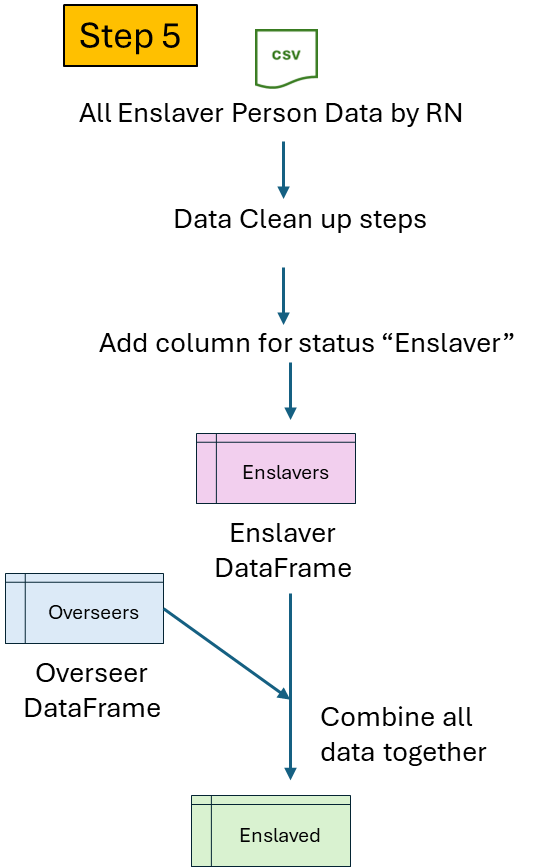

In [64]:
display.Image(filename="Fifth Step.png", width=300, height=300)

## Bring in Enslaver Person Data

In [65]:
#import the Masterfile CSV to work with and a column for "order"
cols= ['RN','Given Name', 'Alternate Name', 'Surname','Sex','Birthdate','Deathdate','Father','Mother','Spouse','Spouse2']
file = "ENSLAVERPersonData_03082024.csv"
ENperson = pd.read_csv(file, header=0, names=cols)
ENperson = trim_all_columns(ENperson)

# Remove names from Spouse and Parents - just Keep RN
ENperson[['Spouse','Spouse2','Father','Mother']] = ENperson[['Spouse','Spouse2','Father','Mother']].replace(regex=[r'\D+'], value="")
ENperson['Status'] = 'Enslaver'

ENperson = ENperson.sort_values('Mother')
ENperson.head(10)

print(ENperson.shape)
ENperson.head()

(110, 12)


,RN,Given Name,Alternate Name,Surname,Sex,Birthdate,Deathdate,Father,Mother,Spouse,Spouse2,Status
109,591,Seth,NaN,Woodroof,M,1804,4 Aug 1875,589,0,NaN,NaN,Enslaver
76,137,John David,NaN,Loving,M,4 Oct 1739,10 May 1804,334,0,NaN,NaN,Enslaver
67,892,William,NaN,Johnson,M,bef 1775,NaN,1039,0,1038,NaN,Enslaver
65,919,William,NaN,Horsley,M,1815,1887,1053,1049,NaN,NaN,Enslaver
57,286,Mary Rice,NaN,Garland,F,1804,1893,1050,1057,276,NaN,Enslaver


### Fix Birth and Death dates as done above for Enslaved and Overseers

In [66]:
hold =ENperson[['RN','Birthdate']]
hold= hold.sort_values('RN').set_index('RN')
hold = hold['Birthdate'].str.split(pat=' ', expand=True).fillna(np.NaN)

hold = hold.replace({1: month})
hold= hold[[2,1,0]]

hold['Birthyear'] = hold[2]
hold['Birthyear'] = hold['Birthyear'].fillna(hold[1])
hold['Birthyear'] = hold['Birthyear'].fillna(hold[0])

BYhold = hold[['Birthyear']]
hold=hold.dropna(subset=2)

hold = hold.astype(str)
hold['Birth date'] = hold[[2,1,0]].agg('-'.join, axis=1)
hold = hold.drop(columns={2,1,0,'Birthyear'})
hold.head()

,Birth date
RN,
43,1730-3-13
44,1759-3-25
45,1800-11-7
137,1739-10-4
215,1820-11-22


In [67]:
ENperson=ENperson.sort_values('RN').set_index('RN')
ENperson=ENperson.join(hold)
ENperson['Birth date'] = ENperson['Birth date'].fillna(ENperson['Birthdate'])
ENperson = ENperson.join(BYhold)
ENperson= ENperson.drop(columns={'Birthdate'})

ENperson=ENperson.reset_index()
print(ENperson.shape)
ENperson.head()

(110, 13)


,RN,Given Name,Alternate Name,Surname,Sex,Deathdate,Father,Mother,Spouse,Spouse2,Status,Birth date,Birthyear
0,43,William,NaN,Cabell,M,23 Mar 1798,42,48,47,NaN,Enslaver,1730-3-13,1730
1,44,William,NaN,Cabell,M,22 Nov 1822,43,47,46,NaN,Enslaver,1759-3-25,1759
2,45,Mayo,NaN,Cabell,M,5 May 1869,44,46,856,860.0,Enslaver,1800-11-7,1800
3,46,Anne Nancy,NaN,Carrington,F,1838,932,933,44,NaN,Enslaver,1760,1760
4,47,Margaret,NaN,Jordan,F,1812,131,132,43,NaN,Enslaver,1742,1742


In [68]:
hold =ENperson[['RN','Deathdate']]
hold= hold.sort_values('RN').set_index('RN')
hold = hold['Deathdate'].str.split(pat=' ', expand=True).fillna(np.NaN)
hold=hold.dropna(subset=2)

hold = hold.replace({1: month})
hold= hold[[2,1,0]]
hold['Deathyear'] = hold[2]
hold['Deathyear'] = hold['Deathyear'].fillna(hold[1])
hold['Deathyear'] = hold['Deathyear'].fillna(hold[0])


DYhold = hold[['Deathyear']]
hold = hold.astype(str)
hold['Death date'] = hold[[2,1,0]].agg('-'.join, axis=1)
hold = hold.drop(columns={2,1,0,'Deathyear'})


ENperson=ENperson.sort_values('RN').set_index('RN')
ENperson = ENperson.join(hold)
ENperson['Death date'] = ENperson['Death date'].fillna(ENperson['Deathdate'])
ENperson = ENperson.join(DYhold)
ENperson = ENperson.drop(columns={'Deathdate'})
ENperson=ENperson.reset_index()
print(ENperson.shape)
ENperson.head()

(110, 14)


,RN,Given Name,Alternate Name,Surname,Sex,Father,Mother,Spouse,Spouse2,Status,Birth date,Birthyear,Death date,Deathyear
0,43,William,NaN,Cabell,M,42,48,47,NaN,Enslaver,1730-3-13,1730,1798-3-23,1798
1,44,William,NaN,Cabell,M,43,47,46,NaN,Enslaver,1759-3-25,1759,1822-11-22,1822
2,45,Mayo,NaN,Cabell,M,44,46,856,860.0,Enslaver,1800-11-7,1800,1869-5-5,1869
3,46,Anne Nancy,NaN,Carrington,F,932,933,44,NaN,Enslaver,1760,1760,1838,NaN
4,47,Margaret,NaN,Jordan,F,131,132,43,NaN,Enslaver,1742,1742,1812,NaN


### Calculate Child Field from Mother and Father

In [69]:
#create dataframe of Mothers
df = ENperson[['Mother','RN']].sort_values(['Mother','RN'])
print(df.shape)
df = df.dropna().astype(int)
print(df.shape)
df = df[df['Mother']!=0]
df['count'] = df.groupby('Mother').cumcount()
df = df.sort_values(['Mother','count'])
df = df.pivot(index=['Mother'], columns='count', values='RN').reset_index()
df =df.rename(columns={0:'Child1',1:'Child2',2:'Child3',3:'Child4',4:'Child5',5:'Child6',6:'Child7',7:'Child8',8:'Child9','Mother':'RN'})
df.head()

(110, 2)
(44, 2)


count,RN,Child1,Child2,Child3,Child4,Child5,Child6,Child7,Child8,Child9
0,46,45.0,213.0,276.0,277.0,278.0,279.0,280.0,281.0,282.0
1,47,44.0,261.0,265.0,268.0,271.0,272.0,NaN,NaN,NaN
2,48,43.0,51.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,132,47.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,213,215.0,680.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Repeat for Father and children

In [70]:
#create dataframe of Fathers
dff = ENperson[['Father','RN']]
dff= dff.sort_values(['Father','RN'])
print(dff.shape)
dff = dff.dropna().astype(int)
dff = dff[dff['Father']!=0]
print(dff.shape)
dff['count'] = dff.groupby('Father').cumcount()
dff = dff.sort_values(['Father','count'])
dff = dff.pivot(index=['Father'], columns='count', values='RN').reset_index()
dff =dff.rename(columns={0:'Child1',1:'Child2',2:'Child3',3:'Child4',4:'Child5',5:'Child6',6:'Child7',7:'Child8',8:'Child9','Father':'RN'})
dff.head()

(110, 2)
(44, 2)


count,RN,Child1,Child2,Child3,Child4,Child5,Child6,Child7,Child8,Child9
0,42,43.0,51.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,43,44.0,261.0,265.0,268.0,271.0,272.0,NaN,NaN,NaN
2,44,45.0,213.0,276.0,277.0,278.0,279.0,280.0,281.0,282.0
3,45,857.0,858.0,859.0,866.0,NaN,NaN,NaN,NaN,NaN
4,131,47.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Concatenate Join Mother and Father together

In [71]:
children = pd.concat([df,dff]).sort_values('RN').set_index('RN')
print(children.shape)
children.head()

(43, 9)


count,Child1,Child2,Child3,Child4,Child5,Child6,Child7,Child8,Child9
RN,,,,,,,,,
42,43.0,51.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
43,44.0,261.0,265.0,268.0,271.0,272.0,NaN,NaN,NaN
44,45.0,213.0,276.0,277.0,278.0,279.0,280.0,281.0,282.0
45,857.0,858.0,859.0,866.0,NaN,NaN,NaN,NaN,NaN
46,45.0,213.0,276.0,277.0,278.0,279.0,280.0,281.0,282.0


### Rejoin to person Dataframe

In [72]:
ENperson = ENperson.sort_values('RN').set_index('RN')
ENperson = ENperson.join(children).reset_index()
print(ENperson.shape)
ENperson.head()

(110, 23)


,RN,Given Name,Alternate Name,Surname,Sex,Father,Mother,Spouse,Spouse2,Status,Birth date,Birthyear,Death date,Deathyear,Child1,Child2,Child3,Child4,Child5,Child6,Child7,Child8,Child9
0,43,William,NaN,Cabell,M,42,48,47,NaN,Enslaver,1730-3-13,1730,1798-3-23,1798,44.0,261.0,265.0,268.0,271.0,272.0,NaN,NaN,NaN
1,44,William,NaN,Cabell,M,43,47,46,NaN,Enslaver,1759-3-25,1759,1822-11-22,1822,45.0,213.0,276.0,277.0,278.0,279.0,280.0,281.0,282.0
2,45,Mayo,NaN,Cabell,M,44,46,856,860.0,Enslaver,1800-11-7,1800,1869-5-5,1869,857.0,858.0,859.0,866.0,NaN,NaN,NaN,NaN,NaN
3,46,Anne Nancy,NaN,Carrington,F,932,933,44,NaN,Enslaver,1760,1760,1838,NaN,45.0,213.0,276.0,277.0,278.0,279.0,280.0,281.0,282.0
4,47,Margaret,NaN,Jordan,F,131,132,43,NaN,Enslaver,1742,1742,1812,NaN,44.0,261.0,265.0,268.0,271.0,272.0,NaN,NaN,NaN


## Join all person and event data together from enslavers and overseers

In [73]:
df = pd.concat([ENperson,overseers])
print(df.shape)
df.head()      

(170, 32)


,RN,Given Name,Alternate Name,Surname,Sex,Father,Mother,Spouse,Spouse2,Status,Birth date,Birthyear,Death date,Deathyear,Child1,Child2,Child3,Child4,Child5,Child6,Child7,Child8,Child9,Event ID,Place,Enslaver ID,Date,Source,Page,Description,Event Type,Year
0,43,William,NaN,Cabell,M,42,48,47,NaN,Enslaver,1730-3-13,1730,1798-3-23,1798,44.0,261.0,265.0,268.0,271.0,272.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,44,William,NaN,Cabell,M,43,47,46,NaN,Enslaver,1759-3-25,1759,1822-11-22,1822,45.0,213.0,276.0,277.0,278.0,279.0,280.0,281.0,282.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,45,Mayo,NaN,Cabell,M,44,46,856,860.0,Enslaver,1800-11-7,1800,1869-5-5,1869,857.0,858.0,859.0,866.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,46,Anne Nancy,NaN,Carrington,F,932,933,44,NaN,Enslaver,1760,1760,1838,NaN,45.0,213.0,276.0,277.0,278.0,279.0,280.0,281.0,282.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,47,Margaret,NaN,Jordan,F,131,132,43,NaN,Enslaver,1742,1742,1812,NaN,44.0,261.0,265.0,268.0,271.0,272.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [74]:
df['Status'].value_counts()

Status
Enslaver    110
Overseer     60
Name: count, dtype: int64

# Step 6

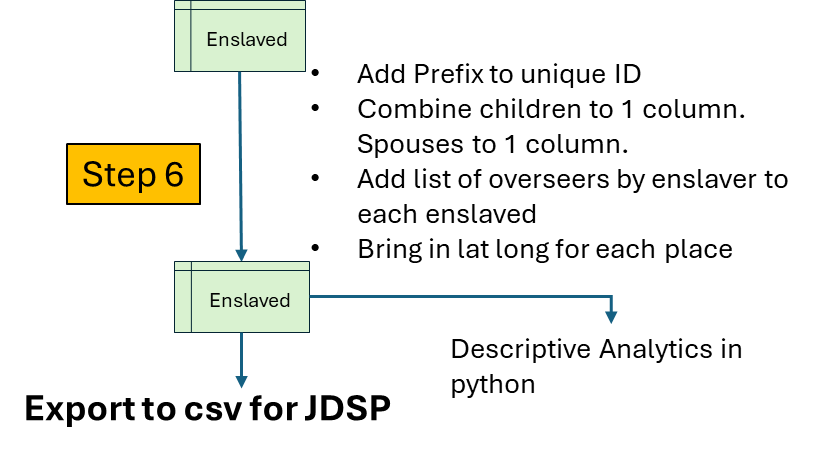

In [75]:
display.Image(filename="SixthStep.png", width=700, height=700)

## Join back to Enslaved DataFrame

In [76]:
enslaved = pd.concat([enslaved,df])
#reorganize columns
enslaved[['RN','Father','Mother','Spouse','Spouse2','Child1','Child2','Child3','Child4','Child5','Child6','Child7','Child8','Child9','Enslaver ID']] = enslaved[['RN','Father','Mother','Spouse','Spouse2','Child1','Child2','Child3','Child4','Child5','Child6','Child7','Child8','Child9','Enslaver ID']].fillna(10000).astype(int).astype(str)
print(enslaved.shape)
enslaved.head()

(3938, 34)


,RN,Given Name,Alternate Name,Surname,Sex,Birthyear,Birth date,Deathyear,Death date,Father,Mother,Spouse,Spouse2,Child1,Child2,Child3,Child4,Child5,Child6,Child7,Child8,Child9,Event ID,Event Type,Place,Status,Enslaver ID,Date,Year,Description,Source,Source Description,Page,Repository
0,1,Venus,NaN,NaN,F,1745,bef 1745,NaN,NaN,10000,10000,14,10000,97,121,10000,10000,10000,10000,10000,10000,10000,EVE-ENS-001,Enslaved,Colleton,Enslaved,43,1770,1770.0,"Enslaved by William Cabell, Sr.",0.0,NaN,<NA>,NaN
1511,1,Venus,NaN,NaN,F,1745,bef 1745,NaN,NaN,10000,10000,14,10000,97,121,10000,10000,10000,10000,10000,10000,10000,EVE-BIR-021,Birth,Union Hill,Enslaved,43,1785-09-22,1785.0,Young Venus delivered of a boy by Old Venus,8.0,"Cabell, William, Sr. Commonplace books, 1769-1...",91,"Virginia Museum of History and Culture, Richmo..."
1498,1,Venus,NaN,NaN,F,1745,bef 1745,NaN,NaN,10000,10000,14,10000,97,121,10000,10000,10000,10000,10000,10000,10000,EVE-BIR-026,Birth,Union Hill,Enslaved,43,1787-03-03,1787.0,Luce delivered of a girl by old Venus,8.0,"Cabell, William, Sr. Commonplace books, 1769-1...",139,"Virginia Museum of History and Culture, Richmo..."
1488,1,Venus,NaN,NaN,F,1745,bef 1745,NaN,NaN,10000,10000,14,10000,97,121,10000,10000,10000,10000,10000,10000,10000,EVE-BIR-017,Birth,Union Hill,Enslaved,43,1783-11-05,1783.0,Creasy delivered of a girl by Venus,8.0,"Cabell, William, Sr. Commonplace books, 1769-1...",37,"Virginia Museum of History and Culture, Richmo..."
1487,1,Venus,NaN,NaN,F,1745,bef 1745,NaN,NaN,10000,10000,14,10000,97,121,10000,10000,10000,10000,10000,10000,10000,EVE-BIR-033,Birth,Union Hill,Enslaved,43,1795-07-25,1795.0,Hannah wife of young George was delivered of a...,8.0,"Cabell, William, Sr. Commonplace books, 1769-1...",303,"Virginia Museum of History and Culture, Richmo..."


In [77]:
enslaved[enslaved['RN']=='45']

,RN,Given Name,Alternate Name,Surname,Sex,Birthyear,Birth date,Deathyear,Death date,Father,Mother,Spouse,Spouse2,Child1,Child2,Child3,Child4,Child5,Child6,Child7,Child8,Child9,Event ID,Event Type,Place,Status,Enslaver ID,Date,Year,Description,Source,Source Description,Page,Repository
2,45,Mayo,NaN,Cabell,M,1800,1800-11-7,1869,1869-5-5,44,46,856,860,857,858,859,866,10000,10000,10000,10000,10000,NaN,NaN,NaN,Enslaver,10000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Fix Individual to have 'PERS-CAB-' in front of the RN and '-UH' on the back of the RN

### For each plantation set, the last element will change, but the person can be matched across plantations with the prefix and number part

In [78]:
enslaved['Person'] = 'PERS-CAB-'+enslaved['RN']+'-UH'

keys_to_update = ['Person', 'Father', 'Mother', 'Spouse','Spouse2','Enslaver ID','Child1','Child2','Child3','Child4','Child5','Child6','Child7','Child8','Child9']
prefix = 'PERS-CAB-'

for key in keys_to_update:
    enslaved[key] = prefix + enslaved[key] + '-UH'
    
enslaved = enslaved.replace(to_replace='PERS-CAB-10000-UH', value=pd.NA)
print(enslaved.shape)
enslaved.head()   

(3938, 35)


,RN,Given Name,Alternate Name,Surname,Sex,Birthyear,Birth date,Deathyear,Death date,Father,Mother,Spouse,Spouse2,Child1,Child2,Child3,Child4,Child5,Child6,Child7,Child8,Child9,Event ID,Event Type,Place,Status,Enslaver ID,Date,Year,Description,Source,Source Description,Page,Repository,Person
0,1,Venus,NaN,NaN,F,1745,bef 1745,NaN,NaN,<NA>,<NA>,PERS-CAB-14-UH,<NA>,PERS-CAB-97-UH,PERS-CAB-121-UH,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,EVE-ENS-001,Enslaved,Colleton,Enslaved,PERS-CAB-43-UH,1770,1770.0,"Enslaved by William Cabell, Sr.",0.0,NaN,<NA>,NaN,PERS-CAB-PERS-CAB-1-UH-UH
1511,1,Venus,NaN,NaN,F,1745,bef 1745,NaN,NaN,<NA>,<NA>,PERS-CAB-14-UH,<NA>,PERS-CAB-97-UH,PERS-CAB-121-UH,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,EVE-BIR-021,Birth,Union Hill,Enslaved,PERS-CAB-43-UH,1785-09-22,1785.0,Young Venus delivered of a boy by Old Venus,8.0,"Cabell, William, Sr. Commonplace books, 1769-1...",91,"Virginia Museum of History and Culture, Richmo...",PERS-CAB-PERS-CAB-1-UH-UH
1498,1,Venus,NaN,NaN,F,1745,bef 1745,NaN,NaN,<NA>,<NA>,PERS-CAB-14-UH,<NA>,PERS-CAB-97-UH,PERS-CAB-121-UH,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,EVE-BIR-026,Birth,Union Hill,Enslaved,PERS-CAB-43-UH,1787-03-03,1787.0,Luce delivered of a girl by old Venus,8.0,"Cabell, William, Sr. Commonplace books, 1769-1...",139,"Virginia Museum of History and Culture, Richmo...",PERS-CAB-PERS-CAB-1-UH-UH
1488,1,Venus,NaN,NaN,F,1745,bef 1745,NaN,NaN,<NA>,<NA>,PERS-CAB-14-UH,<NA>,PERS-CAB-97-UH,PERS-CAB-121-UH,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,EVE-BIR-017,Birth,Union Hill,Enslaved,PERS-CAB-43-UH,1783-11-05,1783.0,Creasy delivered of a girl by Venus,8.0,"Cabell, William, Sr. Commonplace books, 1769-1...",37,"Virginia Museum of History and Culture, Richmo...",PERS-CAB-PERS-CAB-1-UH-UH
1487,1,Venus,NaN,NaN,F,1745,bef 1745,NaN,NaN,<NA>,<NA>,PERS-CAB-14-UH,<NA>,PERS-CAB-97-UH,PERS-CAB-121-UH,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,EVE-BIR-033,Birth,Union Hill,Enslaved,PERS-CAB-43-UH,1795-07-25,1795.0,Hannah wife of young George was delivered of a...,8.0,"Cabell, William, Sr. Commonplace books, 1769-1...",303,"Virginia Museum of History and Culture, Richmo...",PERS-CAB-PERS-CAB-1-UH-UH


In [79]:
#enslaved['Person'] = 'PERS-CAB-'+enslaved['RN']+'-UH'
#enslaved['Father'] = 'PERS-CAB-'+enslaved['Father']+'-UH'
#enslaved['Mother'] = 'PERS-CAB-'+enslaved['Mother']+'-UH'
#enslaved['Spouse'] = 'PERS-CAB-'+enslaved['Spouse']+'-UH'
#enslaved['Spouse2'] = 'PERS-CAB-'+enslaved['Spouse2']+'-UH'
#enslaved['Enslaver ID'] = 'PERS-CAB-'+enslaved['Enslaver ID']+'-UH'
#enslaved['Child1'] = 'PERS-CAB-'+enslaved['Child1']+'-UH'
#enslaved['Child2'] = 'PERS-CAB-'+enslaved['Child2']+'-UH'
#enslaved['Child3'] = 'PERS-CAB-'+enslaved['Child3']+'-UH'
#enslaved['Child4'] = 'PERS-CAB-'+enslaved['Child4']+'-UH'
#enslaved['Child5'] = 'PERS-CAB-'+enslaved['Child5']+'-UH'
#enslaved['Child6'] = 'PERS-CAB-'+enslaved['Child6']+'-UH'
#enslaved['Child7'] = 'PERS-CAB-'+enslaved['Child7']+'-UH'
#enslaved['Child8'] = 'PERS-CAB-'+enslaved['Child8']+'-UH'
#enslaved['Child9'] = 'PERS-CAB-'+enslaved['Child9']+'-UH'
#enslaved = enslaved.replace(to_replace='PERS-CAB-10000-UH', value=pd.NA)
#print(enslaved.shape)
#enslaved.head()

### Combine Overseers into one column

In [80]:
OVhold[['Enslaver ID',0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27]] = 'PERS-CAB-' + OVhold[['Enslaver ID',0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27]] +'-UH'
OVhold.head()

count,Enslaver ID,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,PERS-CAB-272-UH,PERS-CAB-531-UH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,PERS-CAB-43-UH,PERS-CAB-346-UH,PERS-CAB-355-UH,PERS-CAB-357-UH,PERS-CAB-364-UH,PERS-CAB-405-UH,PERS-CAB-406-UH,PERS-CAB-412-UH,PERS-CAB-423-UH,PERS-CAB-425-UH,PERS-CAB-430-UH,PERS-CAB-446-UH,PERS-CAB-459-UH,PERS-CAB-462-UH,PERS-CAB-477-UH,PERS-CAB-507-UH,PERS-CAB-513-UH,PERS-CAB-532-UH,PERS-CAB-534-UH,PERS-CAB-539-UH,PERS-CAB-549-UH,PERS-CAB-556-UH,PERS-CAB-560-UH,PERS-CAB-561-UH,PERS-CAB-562-UH,PERS-CAB-571-UH,PERS-CAB-587-UH,PERS-CAB-597-UH,PERS-CAB-965-UH
2,PERS-CAB-44-UH,PERS-CAB-173-UH,PERS-CAB-343-UH,PERS-CAB-560-UH,PERS-CAB-561-UH,PERS-CAB-575-UH,PERS-CAB-967-UH,PERS-CAB-968-UH,PERS-CAB-969-UH,PERS-CAB-970-UH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,PERS-CAB-45-UH,PERS-CAB-1000-UH,PERS-CAB-994-UH,PERS-CAB-995-UH,PERS-CAB-996-UH,PERS-CAB-997-UH,PERS-CAB-999-UH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,PERS-CAB-857-UH,PERS-CAB-977-UH,PERS-CAB-981-UH,PERS-CAB-987-UH,PERS-CAB-989-UH,PERS-CAB-998-UH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [81]:
OVhold['Overseers'] = OVhold[[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27]].apply(lambda x: x.str.cat(sep=','), axis=1)
OVhold = OVhold[['Enslaver ID','Overseers']]
OVhold = OVhold.sort_values('Enslaver ID').set_index('Enslaver ID')
print(OVhold.shape)
OVhold.head(5)

(6, 1)


count,Overseers
Enslaver ID,
PERS-CAB-272-UH,PERS-CAB-531-UH
PERS-CAB-43-UH,"PERS-CAB-346-UH,PERS-CAB-355-UH,PERS-CAB-357-U..."
PERS-CAB-44-UH,"PERS-CAB-173-UH,PERS-CAB-343-UH,PERS-CAB-560-U..."
PERS-CAB-45-UH,"PERS-CAB-1000-UH,PERS-CAB-994-UH,PERS-CAB-995-..."
PERS-CAB-857-UH,"PERS-CAB-977-UH,PERS-CAB-981-UH,PERS-CAB-987-U..."


In [82]:
enslaved = enslaved.sort_values('Enslaver ID').set_index('Enslaver ID')
enslaved = enslaved.join(OVhold).reset_index()
print(enslaved.shape)
enslaved.head(5)

(3938, 36)


,Enslaver ID,RN,Given Name,Alternate Name,Surname,Sex,Birthyear,Birth date,Deathyear,Death date,Father,Mother,Spouse,Spouse2,Child1,Child2,Child3,Child4,Child5,Child6,Child7,Child8,Child9,Event ID,Event Type,Place,Status,Date,Year,Description,Source,Source Description,Page,Repository,Person,Overseers
0,PERS-CAB-0-UH,259,Sam,NaN,NaN,M,1793,1793,NaN,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,EVE-ENS-090,Enslaved,Unknown,Enslaved,1808,1808.0,Enslaver Unknown,0.0,NaN,<NA>,NaN,PERS-CAB-PERS-CAB-259-UH-UH,NaN
1,PERS-CAB-0-UH,1240,Creasy,NaN,NaN,F,1790,bef 1790,NaN,NaN,<NA>,PERS-CAB-2-UH,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,EVE-ENS-090,Enslaved,Unknown,Enslaved,1808,1808.0,Enslaver Unknown,0.0,NaN,<NA>,NaN,PERS-CAB-PERS-CAB-1240-UH-UH,NaN
2,PERS-CAB-0-UH,74,Will,Creasy's boy,NaN,M,1781,1781-1-15,NaN,NaN,PERS-CAB-613-UH,PERS-CAB-73-UH,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,EVE-ENS-090,Enslaved,Unknown,Enslaved,1808,1808.0,Enslaver Unknown,0.0,NaN,<NA>,NaN,PERS-CAB-PERS-CAB-74-UH-UH,NaN
3,PERS-CAB-0-UH,1242,Madiso,NaN,NaN,M,1836,bef 1836,NaN,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,EVE-ENS-090,Enslaved,Unknown,Enslaved,1846-02-05,1846.0,Enslaver Unknown,0.0,NaN,<NA>,NaN,PERS-CAB-PERS-CAB-1242-UH-UH,NaN
4,PERS-CAB-0-UH,73,Creasy,NaN,NaN,F,1766,bef 1766,NaN,NaN,<NA>,<NA>,PERS-CAB-613-UH,<NA>,PERS-CAB-74-UH,PERS-CAB-78-UH,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,EVE-ENS-090,Enslaved,Unknown,Enslaved,1808,1808.0,Enslaver Unknown,0.0,NaN,<NA>,NaN,PERS-CAB-PERS-CAB-73-UH-UH,NaN


In [83]:
enslaved['Overseers'].value_counts()

Overseers
PERS-CAB-1000-UH,PERS-CAB-994-UH,PERS-CAB-995-UH,PERS-CAB-996-UH,PERS-CAB-997-UH,PERS-CAB-999-UH                                                                                                                                                                                                                                                                                                                                                                   795
PERS-CAB-173-UH,PERS-CAB-343-UH,PERS-CAB-560-UH,PERS-CAB-561-UH,PERS-CAB-575-UH,PERS-CAB-967-UH,PERS-CAB-968-UH,PERS-CAB-969-UH,PERS-CAB-970-UH                                                                                                                                                                                                                                                                                                                    602
PERS-CAB-346-UH,PERS-CAB-355-UH,PERS-CAB-357-UH,PERS-CAB-364-UH,PERS-CAB-405-UH,

## Combine Children into one column

In [84]:
enslaved['Children'] = enslaved[['Child1','Child2','Child3','Child4','Child5','Child6','Child7','Child8','Child9']].apply(lambda x: x.str.cat(sep=','), axis=1)
# Fix order of the columns
enslaved = enslaved[['Person','Given Name','Alternate Name','Surname','Sex','RN','Birthyear','Birth date','Deathyear','Death date','Father','Mother','Spouse','Spouse2','Children','Event ID','Event Type','Place','Status','Enslaver ID','Overseers','Date','Year','Description','Source','Source Description','Page','Repository']]
enslaved.head(5)


,Person,Given Name,Alternate Name,Surname,Sex,RN,Birthyear,Birth date,Deathyear,Death date,Father,Mother,Spouse,Spouse2,Children,Event ID,Event Type,Place,Status,Enslaver ID,Overseers,Date,Year,Description,Source,Source Description,Page,Repository
0,PERS-CAB-PERS-CAB-259-UH-UH,Sam,NaN,NaN,M,259,1793,1793,NaN,NaN,<NA>,<NA>,<NA>,<NA>,,EVE-ENS-090,Enslaved,Unknown,Enslaved,PERS-CAB-0-UH,NaN,1808,1808.0,Enslaver Unknown,0.0,NaN,<NA>,NaN
1,PERS-CAB-PERS-CAB-1240-UH-UH,Creasy,NaN,NaN,F,1240,1790,bef 1790,NaN,NaN,<NA>,PERS-CAB-2-UH,<NA>,<NA>,,EVE-ENS-090,Enslaved,Unknown,Enslaved,PERS-CAB-0-UH,NaN,1808,1808.0,Enslaver Unknown,0.0,NaN,<NA>,NaN
2,PERS-CAB-PERS-CAB-74-UH-UH,Will,Creasy's boy,NaN,M,74,1781,1781-1-15,NaN,NaN,PERS-CAB-613-UH,PERS-CAB-73-UH,<NA>,<NA>,,EVE-ENS-090,Enslaved,Unknown,Enslaved,PERS-CAB-0-UH,NaN,1808,1808.0,Enslaver Unknown,0.0,NaN,<NA>,NaN
3,PERS-CAB-PERS-CAB-1242-UH-UH,Madiso,NaN,NaN,M,1242,1836,bef 1836,NaN,NaN,<NA>,<NA>,<NA>,<NA>,,EVE-ENS-090,Enslaved,Unknown,Enslaved,PERS-CAB-0-UH,NaN,1846-02-05,1846.0,Enslaver Unknown,0.0,NaN,<NA>,NaN
4,PERS-CAB-PERS-CAB-73-UH-UH,Creasy,NaN,NaN,F,73,1766,bef 1766,NaN,NaN,<NA>,<NA>,PERS-CAB-613-UH,<NA>,"PERS-CAB-74-UH,PERS-CAB-78-UH",EVE-ENS-090,Enslaved,Unknown,Enslaved,PERS-CAB-0-UH,NaN,1808,1808.0,Enslaver Unknown,0.0,NaN,<NA>,NaN


## Combine Spouse into one column

In [85]:
enslaved['Spouses'] = enslaved[['Spouse','Spouse2']].apply(lambda x: x.str.cat(sep=','), axis=1)
enslaved = enslaved.drop(columns={'Spouse','Spouse2'})
print(enslaved.shape)
enslaved.head(5)

(3938, 27)


,Person,Given Name,Alternate Name,Surname,Sex,RN,Birthyear,Birth date,Deathyear,Death date,Father,Mother,Children,Event ID,Event Type,Place,Status,Enslaver ID,Overseers,Date,Year,Description,Source,Source Description,Page,Repository,Spouses
0,PERS-CAB-PERS-CAB-259-UH-UH,Sam,NaN,NaN,M,259,1793,1793,NaN,NaN,<NA>,<NA>,,EVE-ENS-090,Enslaved,Unknown,Enslaved,PERS-CAB-0-UH,NaN,1808,1808.0,Enslaver Unknown,0.0,NaN,<NA>,NaN,
1,PERS-CAB-PERS-CAB-1240-UH-UH,Creasy,NaN,NaN,F,1240,1790,bef 1790,NaN,NaN,<NA>,PERS-CAB-2-UH,,EVE-ENS-090,Enslaved,Unknown,Enslaved,PERS-CAB-0-UH,NaN,1808,1808.0,Enslaver Unknown,0.0,NaN,<NA>,NaN,
2,PERS-CAB-PERS-CAB-74-UH-UH,Will,Creasy's boy,NaN,M,74,1781,1781-1-15,NaN,NaN,PERS-CAB-613-UH,PERS-CAB-73-UH,,EVE-ENS-090,Enslaved,Unknown,Enslaved,PERS-CAB-0-UH,NaN,1808,1808.0,Enslaver Unknown,0.0,NaN,<NA>,NaN,
3,PERS-CAB-PERS-CAB-1242-UH-UH,Madiso,NaN,NaN,M,1242,1836,bef 1836,NaN,NaN,<NA>,<NA>,,EVE-ENS-090,Enslaved,Unknown,Enslaved,PERS-CAB-0-UH,NaN,1846-02-05,1846.0,Enslaver Unknown,0.0,NaN,<NA>,NaN,
4,PERS-CAB-PERS-CAB-73-UH-UH,Creasy,NaN,NaN,F,73,1766,bef 1766,NaN,NaN,<NA>,<NA>,"PERS-CAB-74-UH,PERS-CAB-78-UH",EVE-ENS-090,Enslaved,Unknown,Enslaved,PERS-CAB-0-UH,NaN,1808,1808.0,Enslaver Unknown,0.0,NaN,<NA>,NaN,PERS-CAB-613-UH


In [86]:
enslaved['Children'] = enslaved['Children'].where(enslaved['Children']!='',np.NaN)
enslaved['Spouses'] = enslaved['Spouses'].where(enslaved['Spouses']!='',np.NaN)
enslaved['Overseers'] = enslaved['Overseers'].where(enslaved['Overseers']!='',np.NaN)

In [87]:
enslaved[enslaved['RN']=='11']

,Person,Given Name,Alternate Name,Surname,Sex,RN,Birthyear,Birth date,Deathyear,Death date,Father,Mother,Children,Event ID,Event Type,Place,Status,Enslaver ID,Overseers,Date,Year,Description,Source,Source Description,Page,Repository,Spouses
1792,PERS-CAB-PERS-CAB-11-UH-UH,Dick,NaN,NaN,M,11,1764,bef 1764,NaN,NaN,<NA>,<NA>,NaN,EVE-NEC-003,Necessities,Colleton,Enslaved,PERS-CAB-43-UH,"PERS-CAB-346-UH,PERS-CAB-355-UH,PERS-CAB-357-U...",1774-11-20,1774.0,"Memo of Blankets given out. Cesar, Will (yell...",5.0,"Cabell, William, Sr. Commonplace books, 1769-1...",19,"Virginia Museum of History and Culture, Richmo...",PERS-CAB-166-UH
1841,PERS-CAB-PERS-CAB-11-UH-UH,Dick,NaN,NaN,M,11,1764,bef 1764,NaN,NaN,<NA>,<NA>,NaN,EVE-TFR-002,Transfer,Union Hill,Enslaved,PERS-CAB-43-UH,"PERS-CAB-346-UH,PERS-CAB-355-UH,PERS-CAB-357-U...",1781-01-19,1781.0,Gave my son William Dick & Bett who with his o...,7.0,"Cabell, William, Sr. Commonplace books, 1769-1...",367,"Virginia Museum of History and Culture, Richmo...",PERS-CAB-166-UH
1888,PERS-CAB-PERS-CAB-11-UH-UH,Dick,NaN,NaN,M,11,1764,bef 1764,NaN,NaN,<NA>,<NA>,NaN,EVE-ENS-001,Enslaved,Colleton,Enslaved,PERS-CAB-43-UH,"PERS-CAB-346-UH,PERS-CAB-355-UH,PERS-CAB-357-U...",1770,1770.0,"Enslaved by William Cabell, Sr.",0.0,NaN,<NA>,NaN,PERS-CAB-166-UH
1902,PERS-CAB-PERS-CAB-11-UH-UH,Dick,NaN,NaN,M,11,1764,bef 1764,NaN,NaN,<NA>,<NA>,NaN,EVE-LAB-001,Labor,Union Hill,Enslaved,PERS-CAB-43-UH,"PERS-CAB-346-UH,PERS-CAB-355-UH,PERS-CAB-357-U...",1780-01-04,1780.0,"Sent home Putney’s bed and 5 chairs by Simeon,...",7.0,"Cabell, William, Sr. Commonplace books, 1769-1...",339,"Virginia Museum of History and Culture, Richmo...",PERS-CAB-166-UH
2437,PERS-CAB-PERS-CAB-11-UH-UH,Dick,NaN,NaN,M,11,1764,bef 1764,NaN,NaN,<NA>,<NA>,NaN,EVE-TAX-005,Tax,Colleton,Enslaved,PERS-CAB-44-UH,"PERS-CAB-173-UH,PERS-CAB-343-UH,PERS-CAB-560-U...",1797-03-09,1797.0,List of Negroes – Above 12 years old – 24. Go...,12.0,"Cabell, William, Jr..Commonplace book, 1791 Oc...",264,"Virginia Museum of History and Culture, Richmo...",PERS-CAB-166-UH
2443,PERS-CAB-PERS-CAB-11-UH-UH,Dick,NaN,NaN,M,11,1764,bef 1764,NaN,NaN,<NA>,<NA>,NaN,EVE-TAX-002,Tax,Colleton,Enslaved,PERS-CAB-44-UH,"PERS-CAB-173-UH,PERS-CAB-343-UH,PERS-CAB-560-U...",1794-03-09,1794.0,List of Negroes. Above 16 years old -15. Godfr...,12.0,"Cabell, William, Jr..Commonplace book, 1791 Oc...",257,"Virginia Museum of History and Culture, Richmo...",PERS-CAB-166-UH
2444,PERS-CAB-PERS-CAB-11-UH-UH,Dick,NaN,NaN,M,11,1764,bef 1764,NaN,NaN,<NA>,<NA>,NaN,EVE-OVR-004,Overseer Contract,Colleton,Enslaved,PERS-CAB-44-UH,"PERS-CAB-173-UH,PERS-CAB-343-UH,PERS-CAB-560-U...",1796-08-12,1796.0,Have employed Henry Read as an overseer at my ...,12.0,"Cabell, William, Jr..Commonplace book, 1791 Oc...",262,"Virginia Museum of History and Culture, Richmo...",PERS-CAB-166-UH
2445,PERS-CAB-PERS-CAB-11-UH-UH,Dick,NaN,NaN,M,11,1764,bef 1764,NaN,NaN,<NA>,<NA>,NaN,EVE-OVR-002,Overseer Contract,Colleton,Enslaved,PERS-CAB-44-UH,"PERS-CAB-173-UH,PERS-CAB-343-UH,PERS-CAB-560-U...",1792-03-28,1792.0,"Memo of agreement with Thomas Appling, oversee...",12.0,"Cabell, William, Jr..Commonplace book, 1791 Oc...",249,"Virginia Museum of History and Culture, Richmo...",PERS-CAB-166-UH
2446,PERS-CAB-PERS-CAB-11-UH-UH,Dick,NaN,NaN,M,11,1764,bef 1764,NaN,NaN,<NA>,<NA>,NaN,EVE-NEC-010,Necessities,Colleton,Enslaved,PERS-CAB-44-UH,"PERS-CAB-173-UH,PERS-CAB-343-UH,PERS-CAB-560-U...",1796-10,1796.0,"Blankets furnished Fall 1796. Phill, Esther, C...",12.0,"Cabell, William, Jr..Commonplace book, 1791 Oc...",264,"Virginia Museum of History and Culture, Richmo...",PERS-CAB-166-UH
2447,PERS-CAB-PERS-CAB-11-UH-UH,Dick,NaN,NaN,M,11,1764,bef 1764,NaN,NaN,<NA>,<NA>,NaN,EVE-TAX-004,Tax,Colleton,Enslaved,PERS-CAB-44-UH,"PERS-CAB-173-UH,PERS-CAB-343-UH,PERS-CAB-560-U...",1796-03-09,1796.0,List of Negroes –2. Above 12 years of age. God...,12.0,"Cabell, William, Jr..Commonplace book, 1791 Oc...",261,"Virginia Museum of History and Culture, Richm

## Bring in Lat Long of homes and places

In [88]:
#import the Masterfile CSV to work with and a column for "order"
file = "geo_places.csv"
homes = pd.read_csv(file).rename(columns={'Home':'Place'})
homes = trim_all_columns(homes)
print(homes.shape)
homes.head()

(89, 3)


,Place,lat,long
0,Above Centre Hill,37.564051,-78.839138
1,Alta Vista (Rectory),37.644952,-78.808547
2,Banister Lodge,36.769458,-78.917682
3,Belmont,37.675520,-78.833410
4,Below Centre Hill,37.540904,-78.838915


In [89]:
homes = homes[['Place','lat','long']]
homes= homes.sort_values('Place')
homes.head()

,Place,lat,long
0,Above Centre Hill,37.564051,-78.839138
1,Alta Vista (Rectory),37.644952,-78.808547
74,"Amherst County, Virginia",37.581712,-79.048750
73,"Amherst, Virginia",37.581712,-79.048750
80,"Augusta County, Virginia, United States",38.129496,-79.120816


In [90]:
enslaved = enslaved.merge(homes, how='left',left_on='Place', right_on='Place')
# Fix order of the columns
enslaved = enslaved[['Person','Given Name','Alternate Name','Surname','Sex','RN','Birthyear','Birth date','Deathyear','Death date','Father','Mother','Spouses','Children','Event ID','Event Type','Place','lat','long','Status','Enslaver ID','Date','Year','Description','Overseers','Source','Source Description','Page','Repository']].fillna(np.NaN)
# replace field that's entirely space (or empty) with NaN
enslaved.replace(r'^\s*$', np.nan, regex=True)
print(enslaved.shape)
enslaved.head()

(3938, 29)


,Person,Given Name,Alternate Name,Surname,Sex,RN,Birthyear,Birth date,Deathyear,Death date,Father,Mother,Spouses,Children,Event ID,Event Type,Place,lat,long,Status,Enslaver ID,Date,Year,Description,Overseers,Source,Source Description,Page,Repository
0,PERS-CAB-PERS-CAB-259-UH-UH,Sam,NaN,NaN,M,259,1793,1793,NaN,NaN,NaN,NaN,NaN,NaN,EVE-ENS-090,Enslaved,Unknown,NaN,NaN,Enslaved,PERS-CAB-0-UH,1808,1808.0,Enslaver Unknown,NaN,0.0,NaN,NaN,NaN
1,PERS-CAB-PERS-CAB-1240-UH-UH,Creasy,NaN,NaN,F,1240,1790,bef 1790,NaN,NaN,NaN,PERS-CAB-2-UH,NaN,NaN,EVE-ENS-090,Enslaved,Unknown,NaN,NaN,Enslaved,PERS-CAB-0-UH,1808,1808.0,Enslaver Unknown,NaN,0.0,NaN,NaN,NaN
2,PERS-CAB-PERS-CAB-74-UH-UH,Will,Creasy's boy,NaN,M,74,1781,1781-1-15,NaN,NaN,PERS-CAB-613-UH,PERS-CAB-73-UH,NaN,NaN,EVE-ENS-090,Enslaved,Unknown,NaN,NaN,Enslaved,PERS-CAB-0-UH,1808,1808.0,Enslaver Unknown,NaN,0.0,NaN,NaN,NaN
3,PERS-CAB-PERS-CAB-1242-UH-UH,Madiso,NaN,NaN,M,1242,1836,bef 1836,NaN,NaN,NaN,NaN,NaN,NaN,EVE-ENS-090,Enslaved,Unknown,NaN,NaN,Enslaved,PERS-CAB-0-UH,1846-02-05,1846.0,Enslaver Unknown,NaN,0.0,NaN,NaN,NaN
4,PERS-CAB-PERS-CAB-73-UH-UH,Creasy,NaN,NaN,F,73,1766,bef 1766,NaN,NaN,NaN,NaN,PERS-CAB-613-UH,"PERS-CAB-74-UH,PERS-CAB-78-UH",EVE-ENS-090,Enslaved,Unknown,NaN,NaN,Enslaved,PERS-CAB-0-UH,1808,1808.0,Enslaver Unknown,NaN,0.0,NaN,NaN,NaN


# Step 7 

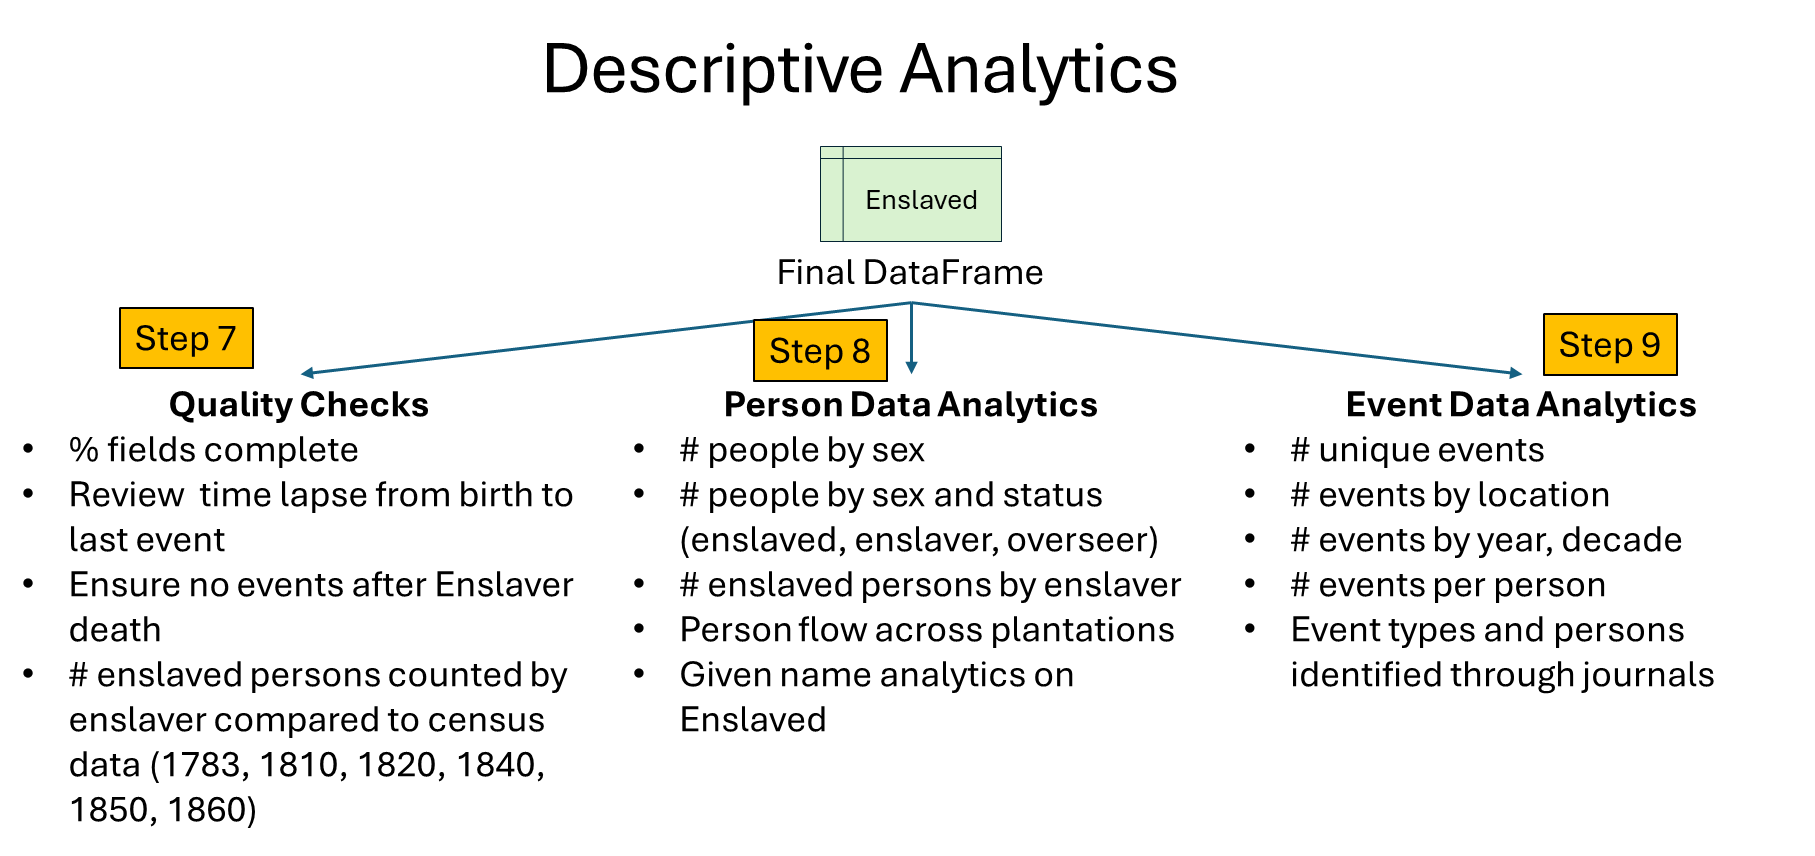

In [91]:
display.Image(filename="Descriptive Anal.png", width=1000, height=1000)

## Quality Checks

### Data Field Completeness of Person Data

In [92]:
print("The percent empty each field is")
enslaved.notnull().sum()/len(enslaved) * 100

The percent empty each field is


Person                100.000000
Given Name            100.000000
Alternate Name         11.452514
Surname                26.917217
Sex                   100.000000
RN                    100.000000
Birthyear             100.000000
Birth date            100.000000
Deathyear               6.907059
Death date              8.913154
Father                 20.873540
Mother                 31.894363
Spouses                28.491620
Children               28.085322
Event ID               97.206704
Event Type             97.206704
Place                  97.206704
lat                    93.676993
long                   93.676993
Status                100.000000
Enslaver ID            95.530726
Date                   97.206704
Year                   97.206704
Description            97.206704
Overseers              62.188928
Source                 97.206704
Source Description     64.042661
Page                   39.182326
Repository             64.042661
dtype: float64

<Axes: >

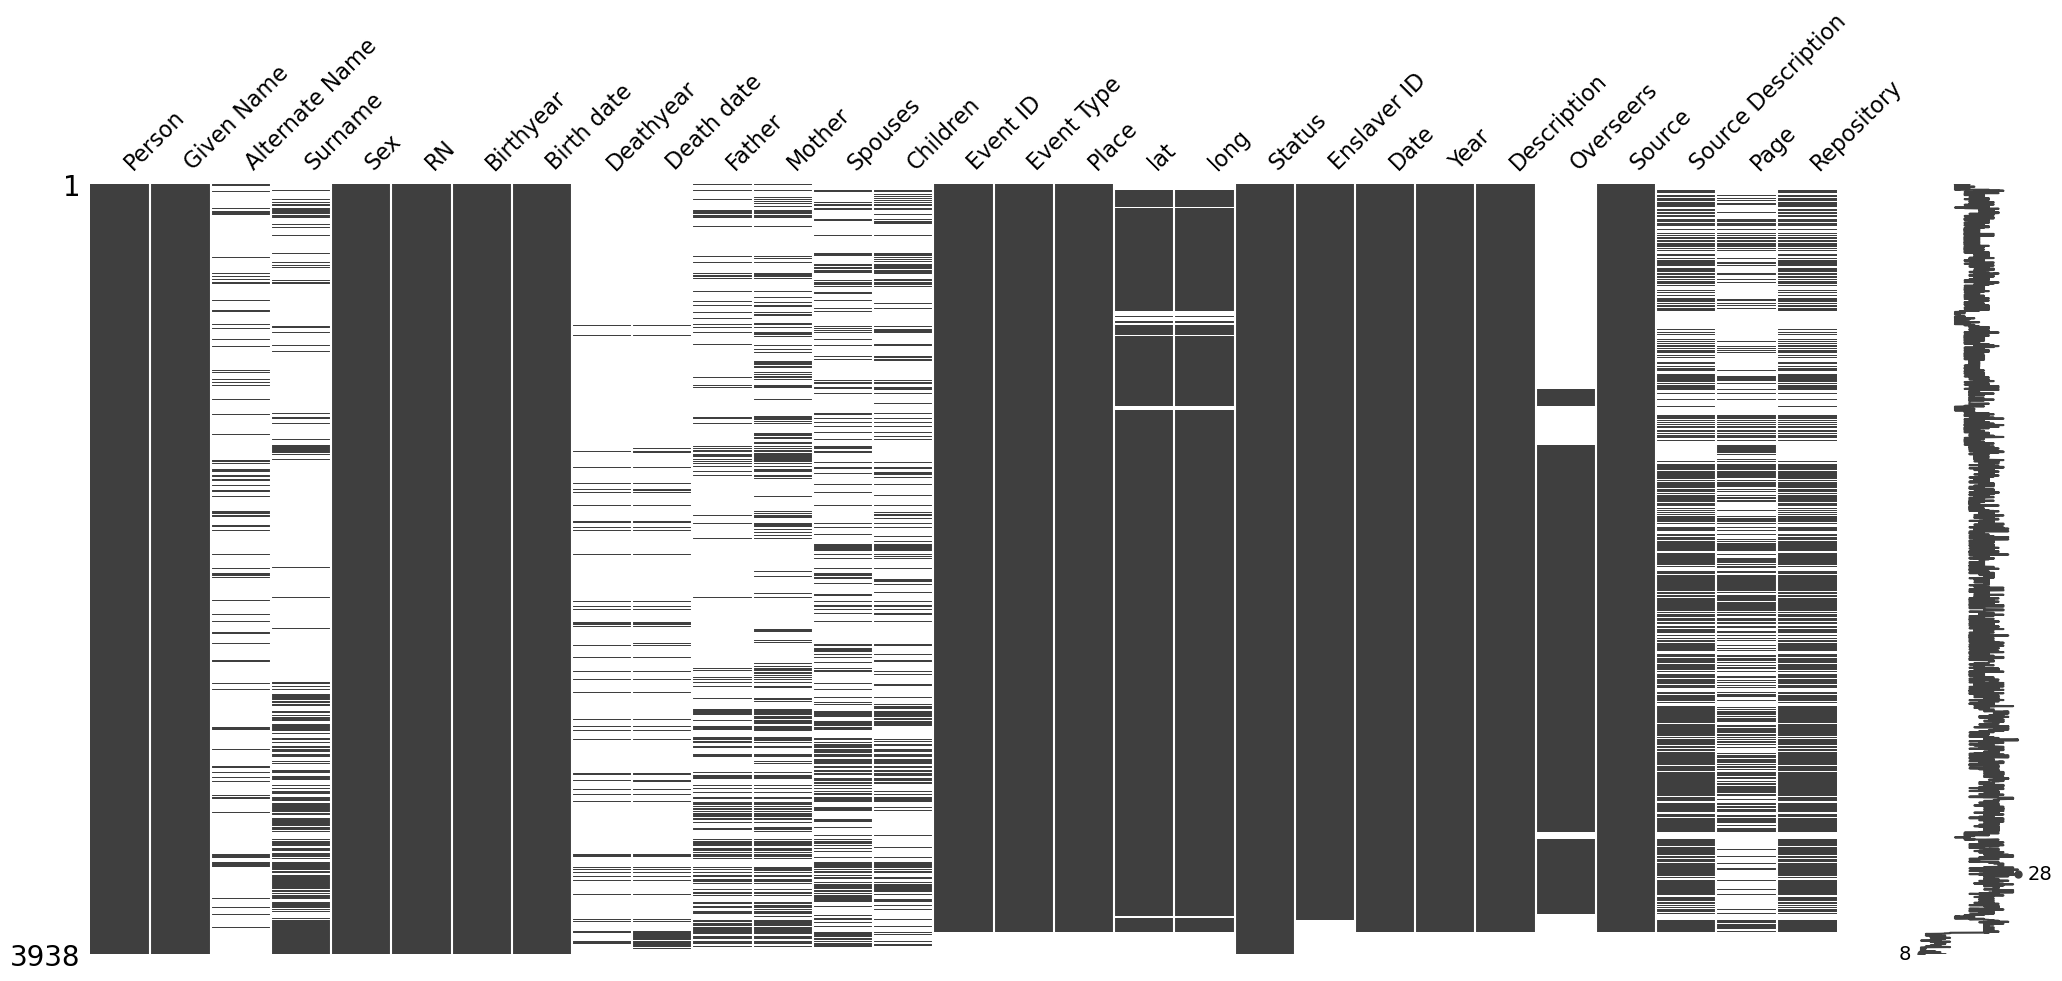

In [93]:
msno.matrix(enslaved)

In [94]:
Persons = enslaved[['Person','Given Name','Alternate Name','Surname','Sex','RN','Birth date','Death date','Father','Mother','Spouses','Children']]
print(Persons.shape)
Persons = Persons.drop_duplicates()
print(Persons.shape)
Persons.head()

(3938, 12)
(820, 12)


,Person,Given Name,Alternate Name,Surname,Sex,RN,Birth date,Death date,Father,Mother,Spouses,Children
0,PERS-CAB-PERS-CAB-259-UH-UH,Sam,NaN,NaN,M,259,1793,NaN,NaN,NaN,NaN,NaN
1,PERS-CAB-PERS-CAB-1240-UH-UH,Creasy,NaN,NaN,F,1240,bef 1790,NaN,NaN,PERS-CAB-2-UH,NaN,NaN
2,PERS-CAB-PERS-CAB-74-UH-UH,Will,Creasy's boy,NaN,M,74,1781-1-15,NaN,PERS-CAB-613-UH,PERS-CAB-73-UH,NaN,NaN
3,PERS-CAB-PERS-CAB-1242-UH-UH,Madiso,NaN,NaN,M,1242,bef 1836,NaN,NaN,NaN,NaN,NaN
4,PERS-CAB-PERS-CAB-73-UH-UH,Creasy,NaN,NaN,F,73,bef 1766,NaN,NaN,NaN,PERS-CAB-613-UH,"PERS-CAB-74-UH,PERS-CAB-78-UH"


### Time lapse from birth to last event

In [95]:
test=enslaved[['RN','Birthyear','Year','Death date','Event Type', 'Event ID']]
test= test.drop_duplicates().dropna()
print(test.shape)
test.head()

(276, 6)


,RN,Birthyear,Year,Death date,Event Type,Event ID
44,651,1810,1863.0,1858,Advertisement,EVE-ADV-006
45,651,1810,1863.0,1858,Transfer,EVE-TFR-082
66,651,1810,1858.0,1858,Enslaved,EVE-ENS-013
75,651,1810,1858.0,1858,Death,EVE-DEA-031
316,186,1785,1832.0,1851-11-12,Hiring,EVE-HIR-016


#### Review the events where a person was over 70

In [96]:
test['Birthyear'] = test['Birthyear'].astype(int)
test['Span'] = test['Year'] -test['Birthyear']
test=test.sort_values('Span').set_index('Span').loc[70:].reset_index()
test['RN'].drop_duplicates().tolist()

['14', '191', '112', '177', '163', '148', '194']

### Review Event dates after Enslaver death

In [97]:
### Col. William Cabell died in 1798, probate in 1800
df = enslaved[enslaved['Enslaver ID']=='PERS-CAB-43-UH']
df = df[df['Year'] >=1801]
df['RN'].value_counts()

Series([], Name: count, dtype: int64)

In [98]:
### William Cabell, Jr. died in 1822, probate in 1823
df = enslaved[enslaved['Enslaver ID']=='PERS-CAB-44-UH']
df = df[df['Year'] >=1824]
df['RN'].value_counts()

Series([], Name: count, dtype: int64)

In [99]:
### Samuel Jordan Cabell died in 1818, probate in 1818
df = enslaved[enslaved['Enslaver ID']=='PERS-CAB-272-UH']
df = df[df['Year'] >=1819]
df['RN'].value_counts()

Series([], Name: count, dtype: int64)

In [100]:
### Hector Cabell died in 1807, probate in 1807
df = enslaved[enslaved['Enslaver ID']=='PERS-CAB-271-UH']
df = df[df['Year'] >=1808]
df['RN'].value_counts()

Series([], Name: count, dtype: int64)

In [101]:
### SThomas Stanhope McClelland died in 1835
df = enslaved[enslaved['Enslaver ID']=='PERS-CAB-283-UH']
df = df[df['Year'] >=1836]
df['RN'].value_counts()

Series([], Name: count, dtype: int64)

### Review persons with just one event

In [102]:
test = enslaved[['RN','Given Name','Year','Enslaver ID','Event ID','Status']]
test = test[test['Status']=='Enslaved']
print(test.shape)

(3702, 6)


In [103]:
test.groupby(['RN'])['Event ID'].count().to_frame().reset_index().sort_values('Event ID').set_index('Event ID').loc[1].reset_index()

,Event ID,RN
0,1,1070
1,1,1026
2,1,1028
3,1,1029
4,1,1030
5,1,1031


### Spot checks on grouping of people by event and compare to original text grouping

In [104]:
test = enslaved[['RN','Given Name','Year','Enslaver ID','Event ID']]
print(test.shape)
test= test.dropna(subset=['Year'])
test= test.dropna(subset=['Enslaver ID'])
test = test.drop_duplicates()
print(test.shape)


(3938, 5)
(3762, 5)


In [105]:
#RES-015 should have 9 people
test[test['Event ID'] == 'EVE-RES-015']

,RN,Given Name,Year,Enslaver ID,Event ID
3647,847,Henry,1859.0,PERS-CAB-858-UH,EVE-RES-015
3651,321,Harriet,1859.0,PERS-CAB-858-UH,EVE-RES-015
3658,312,Winston,1859.0,PERS-CAB-858-UH,EVE-RES-015
3659,821,George,1859.0,PERS-CAB-858-UH,EVE-RES-015
3665,887,Ned,1859.0,PERS-CAB-858-UH,EVE-RES-015
3679,852,Moses,1859.0,PERS-CAB-858-UH,EVE-RES-015
3685,918,Mordecai,1859.0,PERS-CAB-858-UH,EVE-RES-015
3689,801,Margaret,1859.0,PERS-CAB-858-UH,EVE-RES-015
3699,791,Pat,1859.0,PERS-CAB-858-UH,EVE-RES-015


## Person Analytics

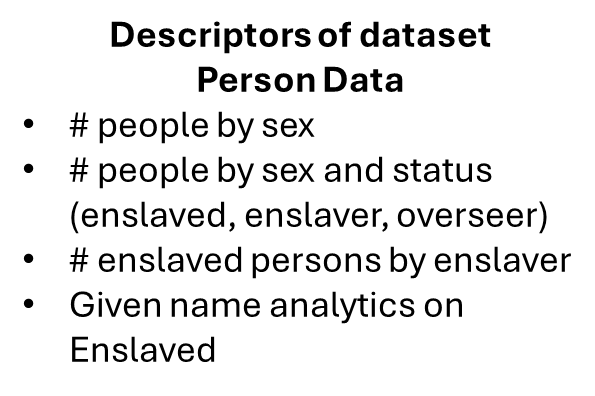

In [106]:
display.Image(filename="People.png", width=300, height=300)

### Total number of people

In [107]:
enslaved['RN'].nunique()

820

### Total number of unique persons by sex

In [108]:
enslaved.groupby(['Sex'])['RN'].nunique().to_frame().reset_index()

,Sex,RN
0,?,18
1,F,322
2,M,480


### Total number of unique persons by status and sex

In [109]:
enslaved.groupby(['Status'])['RN'].nunique().to_frame().reset_index()

,Status,RN
0,Enslaved,663
1,Enslaver,110
2,Free,46
3,Overseer,47


In [110]:
enslaved.groupby(['Status','Sex'])['RN'].nunique().to_frame().reset_index()

,Status,Sex,RN
0,Enslaved,?,18
1,Enslaved,F,292
2,Enslaved,M,353
3,Enslaver,F,30
4,Enslaver,M,80
5,Free,F,22
6,Free,M,24
7,Overseer,M,47


### Number of enslaved by major enslaver 

In [111]:
Enslavers = [43,44,45,46,207,216,262,265,268,269,271,272,276,277,280,282,283,677,680,866,857,858,866,919,1034,1065,1088,1320]
UHEnslaved = enslaved[['RN','Enslaver ID','Status','Source','Event Type','Event ID']]
print(UHEnslaved.shape)
UHEnslaved = UHEnslaved.drop_duplicates()
print(UHEnslaved.shape)
UHEnslaved = UHEnslaved.sort_values('Status').set_index('Status').loc['Enslaved'].reset_index().drop(columns={'Status'})
UHEnslaved['Enslaver ID'] = UHEnslaved['Enslaver ID'].replace(regex=[r'\D+'], value=" ")
UHEnslaved['Enslaver ID'] = UHEnslaved['Enslaver ID'].astype(int)
UHEnslaved = UHEnslaved[UHEnslaved['Enslaver ID'].isin(Enslavers)] 
print(UHEnslaved.shape)
UHEnslaved.groupby(['Enslaver ID'])['RN'].nunique().to_frame().reset_index().rename(columns={'RN':'Number'}).sort_values(['Enslaver ID']).set_index(['Enslaver ID'])


(3938, 6)
(3937, 6)
(3547, 5)


,Number
Enslaver ID,
43,194
44,147
45,145
46,11
207,16
216,27
262,10
265,4
269,36


### number of events by enslaver

In [112]:
UHEnslaved =UHEnslaved[ UHEnslaved['Event Type']!='Enslaved']
print(UHEnslaved.shape)
UHEnslaved.groupby(['Enslaver ID'])['Event ID'].nunique().to_frame().reset_index().rename(columns={'Event ID':'Events'}).sort_values(['Enslaver ID']).set_index(['Enslaver ID'])


(2448, 5)


,Events
Enslaver ID,
43,139
44,42
45,120
46,1
207,7
216,8
265,1
269,1
271,3


### Plantations and Enslavers per enslaved person

In [113]:
# of places lived per person across all data
places  = enslaved[['RN','Event ID','Enslaver ID','Status','Place']]
print(places.shape)
places = places[places['Status']=='Enslaved']
places['Enslaver ID'] = places['Enslaver ID'].replace(regex=[r'\D+'], value=" ").astype(int)
print("The mean number of places an enslaved person lived is", places.groupby(['RN'])['Place'].nunique().mean().round(2))
print("The number of enslaved persons living at more than 3 locations is", len(places.groupby(['RN'])['Place'].nunique().to_frame().reset_index().sort_values('Place').set_index('Place').loc[3:].reset_index().sort_values('RN')))   
print("The number of enslavec persons living under 3 or more enslavers is", len(places.groupby(['RN'])['Enslaver ID'].nunique().to_frame().reset_index().sort_values('Enslaver ID').set_index('Enslaver ID').loc[3:].reset_index().sort_values('RN')))

(3938, 5)
The mean number of places an enslaved person lived is 1.6
The number of enslaved persons living at more than 3 locations is 72
The number of enslavec persons living under 3 or more enslavers is 169


### Number of enslaved persons across multiple generations of Union Hill enslavers

### Define the Enslavers- Any Cabell family member whether a Union Hill plantation owner or not plus the non-Cabell Union Hill plantation owneres

In [114]:
Enslavers = [43,44,45,46,207,216,262,265,268,269,271,272,276,277,280,282,283,677,680,866,857,858,866,919,1034,1065,1088,1320]

### Where did enslaved of Col. William Cabell go?

In [115]:
whereto = enslaved[['RN','Enslaver ID','Status']]
whereto = whereto[whereto['Status'] == 'Enslaved'].reset_index().drop(columns={'Status'}).drop_duplicates()
whereto['Enslaver ID'] = whereto['Enslaver ID'].replace(regex=[r'\D+'], value=" ").astype(int)
whereto['RN'] = whereto['RN'].astype(int)

In [116]:
#Down select to enslaver of choice
a = whereto[whereto['Enslaver ID'] ==43]
a = a[['RN','Enslaver ID']].sort_values('RN').drop_duplicates()
print(a.shape)
#create list for look up
Cabell = a['RN'].tolist()
#go back to original df and extract people from that enslaver
df = enslaved[enslaved['Status'] == 'Enslaved'].reset_index().drop(columns={'Status'}).drop_duplicates().sort_values('RN')
df['RN'] = df['RN'].astype(int)
df['Enslaver ID'] = df['Enslaver ID'].replace(regex=[r'\D+'], value=" ").astype(int)
df =df[df['RN'].isin(Cabell)]
df1 = df.groupby(['Enslaver ID'])['RN'].nunique().to_frame().reset_index().sort_values('RN',ascending=False)
df1.head(15)

(194, 2)


,Enslaver ID,RN
1,43,194
2,44,68
15,269,36
16,271,15
0,0,13
17,272,13
26,1065,8
3,45,7
13,262,7
8,131,5


### Where did enslaved of William Cabell Jr go?

In [117]:
#Down select to enslaver of choice
a = whereto[whereto['Enslaver ID'] ==44]
a = a[['RN','Enslaver ID']].sort_values('RN').drop_duplicates()
#create list for look up
Cabell = whereto['RN'].tolist()
#go back to original df and extract people from that enslaver
df = enslaved[enslaved['Status'] == 'Enslaved'].reset_index().drop(columns={'Status'}).drop_duplicates().sort_values('RN')
df['RN'] = df['RN'].astype(int)
df['Enslaver ID'] = df['Enslaver ID'].replace(regex=[r'\D+'], value=" ").astype(int)

df =df[df['RN'].isin(Cabell)]
df1 = df.groupby(['Enslaver ID'])['RN'].nunique().to_frame().reset_index().sort_values('RN',ascending=False)
df1.head(20)

,Enslaver ID,RN
1,43,194
2,44,147
3,45,145
50,1088,104
49,1065,102
21,272,76
38,857,59
19,269,36
27,283,35
24,280,32


### Where did enslaved of Mayo Cabell go?

In [118]:
a = whereto[whereto['Enslaver ID'] ==45]
a = a[['RN','Enslaver ID']].sort_values('RN').drop_duplicates()
#create list for look up
Cabell = whereto['RN'].tolist()
#go back to original df and extract people from that enslaver
df = enslaved[enslaved['Status'] == 'Enslaved'].reset_index().drop(columns={'Status'}).drop_duplicates().sort_values('RN')
df['RN'] = df['RN'].astype(int)
df['Enslaver ID'] = df['Enslaver ID'].replace(regex=[r'\D+'], value=" ").astype(int)
df =df[df['RN'].isin(Cabell)]
df1 = df.groupby(['Enslaver ID'])['RN'].nunique().to_frame().reset_index().sort_values('RN',ascending=False)
df1.head(15)

,Enslaver ID,RN
1,43,194
2,44,147
3,45,145
50,1088,104
49,1065,102
21,272,76
38,857,59
19,269,36
27,283,35
24,280,32


## Enslaved Given Name Analytics

In [119]:
names = enslaved[['RN','Given Name','Sex','Status','Place']]
names = names[names['Status'] == 'Enslaved'].reset_index().drop(columns={'Status'}).drop_duplicates().sort_values('RN')
names.groupby(['Sex'])['RN'].nunique()


Sex
?     18
F    292
M    353
Name: RN, dtype: int64

In [120]:
names = names.groupby(['Sex','Given Name'])['RN'].nunique().to_frame().reset_index()
names = names.sort_values(['Sex','RN'],ascending=False)
names[names['Sex']=='M'].head(10)

,Sex,Given Name,RN
317,M,Unknown,18
247,M,John,12
224,M,George,10
232,M,Henry,10
294,M,Sam,9
248,M,Jordan,8
321,M,Will,7
237,M,James,6
286,M,Reuben,6
167,M,Andrew,5


In [121]:
names[names['Sex']=='F'].head(15)

,Sex,Given Name,RN
108,F,Mary,11
117,F,Nancy,11
65,F,Fanny,8
96,F,Louisa,7
103,F,Margaret,7
155,F,Unknown,7
28,F,Betty,6
107,F,Martha,6
35,F,Charlotte,5
73,F,Hannah,5


In [122]:
surnames = enslaved[['RN','Surname','Status','Place']]
surnames = surnames[surnames['Status'] == 'Enslaved']
surnames.groupby(['Surname'])['RN'].nunique().to_frame().reset_index().sort_values('RN', ascending=False)

,Surname,RN
11,Hatcher,16
1,Banks,15
13,Jackson,10
10,Hartgrove,10
2,Bolling,8
14,Jemmeson,7
21,Rose,6
25,Trotter,5
19,Madison,4
27,Winslow,3


#### Number of enslaved with surames

In [123]:
df = surnames[surnames['Surname'].notna()]
df['RN'].nunique()

106

## Event Analytics

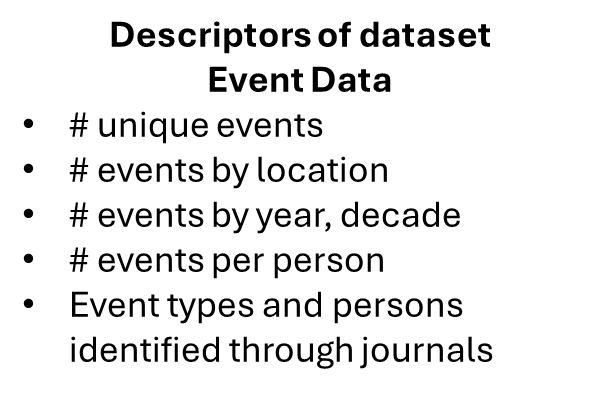

In [124]:
display.Image(filename="Events.png", width=400, height=400)

### Number of unique events

In [125]:
df = enslaved[enslaved['Event Type']!='Enslaved']
df['Event ID'].nunique()

596

### Total number of events by place

In [126]:
df.groupby(['Place'])['Event ID'].nunique().to_frame().reset_index().sort_values('Event ID',ascending=False).head(15)

,Place,Event ID
29,Union Hill,278
22,Norwood,90
7,Colleton,87
28,Soldier's Joy,64
18,Montezuma,23
15,"Lovingston, Nelson, Virginia",13
3,Benvenue,11
31,"Williamsburg, Virginia",4
0,Amherst,3
2,Belmont,3


### Number of events per person - People with more than 10 events

### number of people in this dataset

In [127]:
df['RN'].nunique()

819

### Number of enslaved with more than 10 events

In [128]:
df.groupby(['RN'])['Event ID'].nunique().to_frame().reset_index().sort_values('Event ID').set_index('Event ID').loc[10:].reset_index().shape


(60, 2)

### Number of enslaved with just one event

In [129]:
df.groupby(['RN'])['Event ID'].nunique().to_frame().reset_index().sort_values('Event ID').set_index('Event ID').loc[:1].reset_index().shape


(346, 2)

### Events per person average

In [130]:
df.groupby(['RN'])['Event ID'].nunique().mean()

3.1526251526251525

### Events by Decade across Plantations

Text(0.5, 0, 'Year')

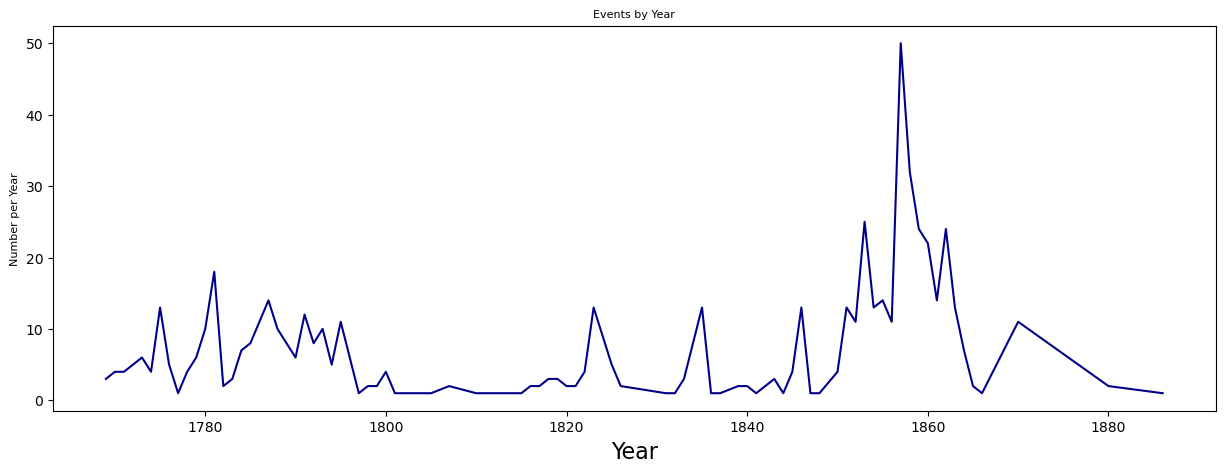

In [131]:
events = df.groupby(['Year'])['Event ID'].nunique().to_frame().reset_index()
events = events.rename(columns={'Year':'Year','Event ID':'Events'}).set_index('Year')

fig1 = plt.figure(figsize=(15,5))
ax1 = fig1.add_subplot(111)

ax1.plot(events['Events'],color='darkblue')
plt.title('Events by Year', fontsize=8)
plt.ylabel('Number per Year', fontsize=8)
plt.xlabel('Year', fontsize=16)
#plt.xticks(np.arange(1750, 1870, 20))
#plt.annotate('1862', (1862,90), fontsize=12)

## Enslaved persons named by year 

In [132]:
shortlist = [43,44,45,46,268,269,271,272,280,283,857,858,1034,1065,1088,1320]
df = enslaved[enslaved['Event Type']!='Enslaved']
print(df.shape)
df = df[df['Status']!='Overseer']
print(df.shape)
df = df[df['Status']!='Enslaver']
print(df.shape)
df = df[df['Year']< 1870]
print(df.shape)
df = df[df['Year']> 1764]
print(df.shape)
df['Enslaver ID'] = df['Enslaver ID'].replace(regex=[r'\D+'], value=" ").fillna(0).astype(int)
df = df[df['Enslaver ID'].isin(shortlist)]
df['RN'] =df['RN'].astype(int)
print(df.shape)
print(df['RN'].nunique())
df.head(2)


(2692, 29)
(2632, 29)
(2522, 29)
(2484, 29)
(2484, 29)
(2381, 29)
654


,Person,Given Name,Alternate Name,Surname,Sex,RN,Birthyear,Birth date,Deathyear,Death date,Father,Mother,Spouses,Children,Event ID,Event Type,Place,lat,long,Status,Enslaver ID,Date,Year,Description,Overseers,Source,Source Description,Page,Repository
30,PERS-CAB-PERS-CAB-666-UH-UH,Nancy,NaN,NaN,F,666,1800,abt 1800,NaN,NaN,NaN,NaN,PERS-CAB-665-UH,PERS-CAB-667-UH,EVE-CRT-001,Court,Montezuma,37.648946,-78.801605,Enslaved,1034,1859-11-15,1859.0,James B. McClelland doth grant unto the said J...,NaN,61.0,Deed of Trust for Benvenue Estate.Nelson Count...,137,"Nelson County Circuit Court, Lovingston, Va."
32,PERS-CAB-PERS-CAB-663-UH-UH,Sawney,NaN,Jemmeson,M,663,1832,abt 1832,NaN,NaN,PERS-CAB-647-UH,PERS-CAB-661-UH,PERS-CAB-1032-UH,"PERS-CAB-1335-UH,PERS-CAB-1336-UH,PERS-CAB-133...",EVE-ADV-006,Advertisement,Montezuma,37.648946,-78.801605,Enslaved,1034,1863-09-18,1863.0,"Valuable Lands for Sale. September, 1863, at p...",NaN,71.0,"“Valuable Lands for Sale,” Richmond Times Disp...",NaN,Newspapers.com (https://www.newspapers.com)


### Sort data by Birthyear and assign new unique identifier through index for graphing purposes

In [133]:
newID = df[['RN','Birthyear']]
newID= newID.drop_duplicates().sort_values('Birthyear').reset_index(drop=True).reset_index().rename(columns={'index':'ID'}).astype(int)
print(newID.shape)
print(newID['Birthyear'].max())
print(newID['Birthyear'].min())
newID= newID.sort_values('RN').set_index('RN')

(654, 3)
1864
1705


### Change Enslaver ID for graphing purposes

#### Renumber the enslaver ID to help with graphing by color 


In [134]:
a = df[['RN','Year','Enslaver ID']].sort_values('RN').set_index('RN')
a= a.join(newID).reset_index()
a['Year'] = a['Year'].astype(int)
a= a.sort_values('Year')
#Union Hill, Colleton and Norwood enslavers
a['Enslaver ID'] = a['Enslaver ID'].replace(to_replace= 43, value=10)
a['Enslaver ID'] = a['Enslaver ID'].replace(to_replace= 269, value=11)
a['Enslaver ID'] = a['Enslaver ID'].replace(to_replace= 44, value=12)
a['Enslaver ID'] = a['Enslaver ID'].replace(to_replace= 46, value=13)
a['Enslaver ID'] = a['Enslaver ID'].replace(to_replace= 45, value=14)
a['Enslaver ID'] = a['Enslaver ID'].replace(to_replace= 857, value=15)
a['Enslaver ID'] = a['Enslaver ID'].replace(to_replace= 858, value=16)

#Montezuma enslavers
a['Enslaver ID'] = a['Enslaver ID'].replace(to_replace= 271, value=20)
a['Enslaver ID'] = a['Enslaver ID'].replace(to_replace= 280, value=21)
a['Enslaver ID'] = a['Enslaver ID'].replace(to_replace= 283, value=22)
a['Enslaver ID'] = a['Enslaver ID'].replace(to_replace= 1034, value=23)
a['Enslaver ID'] = a['Enslaver ID'].replace(to_replace= 1320, value=24)

#Soldier's Joy enslavers
a['Enslaver ID'] = a['Enslaver ID'].replace(to_replace= 272, value=30)
a['Enslaver ID'] = a['Enslaver ID'].replace(to_replace= 1065, value=31)
a['Enslaver ID'] = a['Enslaver ID'].replace(to_replace= 1088, value=32)

a['Enslaver ID'] = a['Enslaver ID'].astype(int)
a.head(10)

,RN,Year,Enslaver ID,ID,Birthyear
33,7,1769,10,21,1755
195,53,1769,10,84,1769
148,27,1769,10,22,1755
41,8,1769,10,20,1755
139,24,1770,10,26,1757
70,10,1770,10,30,1757
31,7,1770,10,21,1755
32,7,1770,10,21,1755
124,21,1770,10,38,1760
120,20,1770,10,17,1750


In [135]:
sns.color_palette('Greens_r',4) #Union Hill Colleton Norwood

[(0.08235294117647059, 0.49803921568627446, 0.23137254901960783),
 (0.29490196078431374, 0.6901960784313725, 0.38431372549019605),
 (0.596078431372549, 0.8345098039215686, 0.5788235294117647),
 (0.8274509803921569, 0.9325490196078431, 0.8031372549019608)]

In [136]:
print(sns.color_palette("Greens_r",4).as_hex())

['#157f3b', '#4bb062', '#98d594', '#d3eecd']


In [137]:
sns.color_palette('Oranges_r',4) #Soldier's Joy

[(0.7709803921568628, 0.2541176470588235, 0.007058823529411764),
 (0.9545098039215686, 0.44, 0.10666666666666666),
 (0.9921568627450981, 0.6564705882352941, 0.3827450980392157),
 (0.9937254901960785, 0.8501960784313726, 0.7043137254901961)]

In [138]:
print(sns.color_palette("Oranges_r",4).as_hex())

['#c54102', '#f3701b', '#fda762', '#fdd9b4']


In [139]:
sns.color_palette('Blues_r',6) #Montezuma

[(0.044059976931949255, 0.3338869665513264, 0.6244521337946944),
 (0.16696655132641294, 0.48069204152249134, 0.7291503267973857),
 (0.3262898885044214, 0.6186236063052672, 0.802798923490965),
 (0.5356862745098039, 0.746082276047674, 0.8642522106881968),
 (0.7309496347558632, 0.8394771241830065, 0.9213225682429834),
 (0.8584083044982699, 0.9134486735870818, 0.9645674740484429)]

In [140]:
print(sns.color_palette("Blues_r",6).as_hex())

['#0b559f', '#2b7bba', '#539ecd', '#89bedc', '#bad6eb', '#dbe9f6']


#### Fillin the blank years with NaN values

In [141]:
df2 = pd.DataFrame({'Year':range(1765,1865), 'Enslaver ID':np.NaN, 'ID':np.NaN})
a= pd.concat([a,df2]).sort_values('Year')
a= a.sample(frac=1) #shuffle the rows so the dots are randomly inserted on the graph
a.head()

,RN,Year,Enslaver ID,ID,Birthyear
1669,847.0,1840,23.0,419.0,1820.0
1901,936.0,1857,15.0,288.0,1797.0
47,8.0,1788,10.0,20.0,1755.0
791,259.0,1807,20.0,270.0,1793.0
1441,817.0,1857,15.0,593.0,1850.0


C:\Users\kathe\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\kathe\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


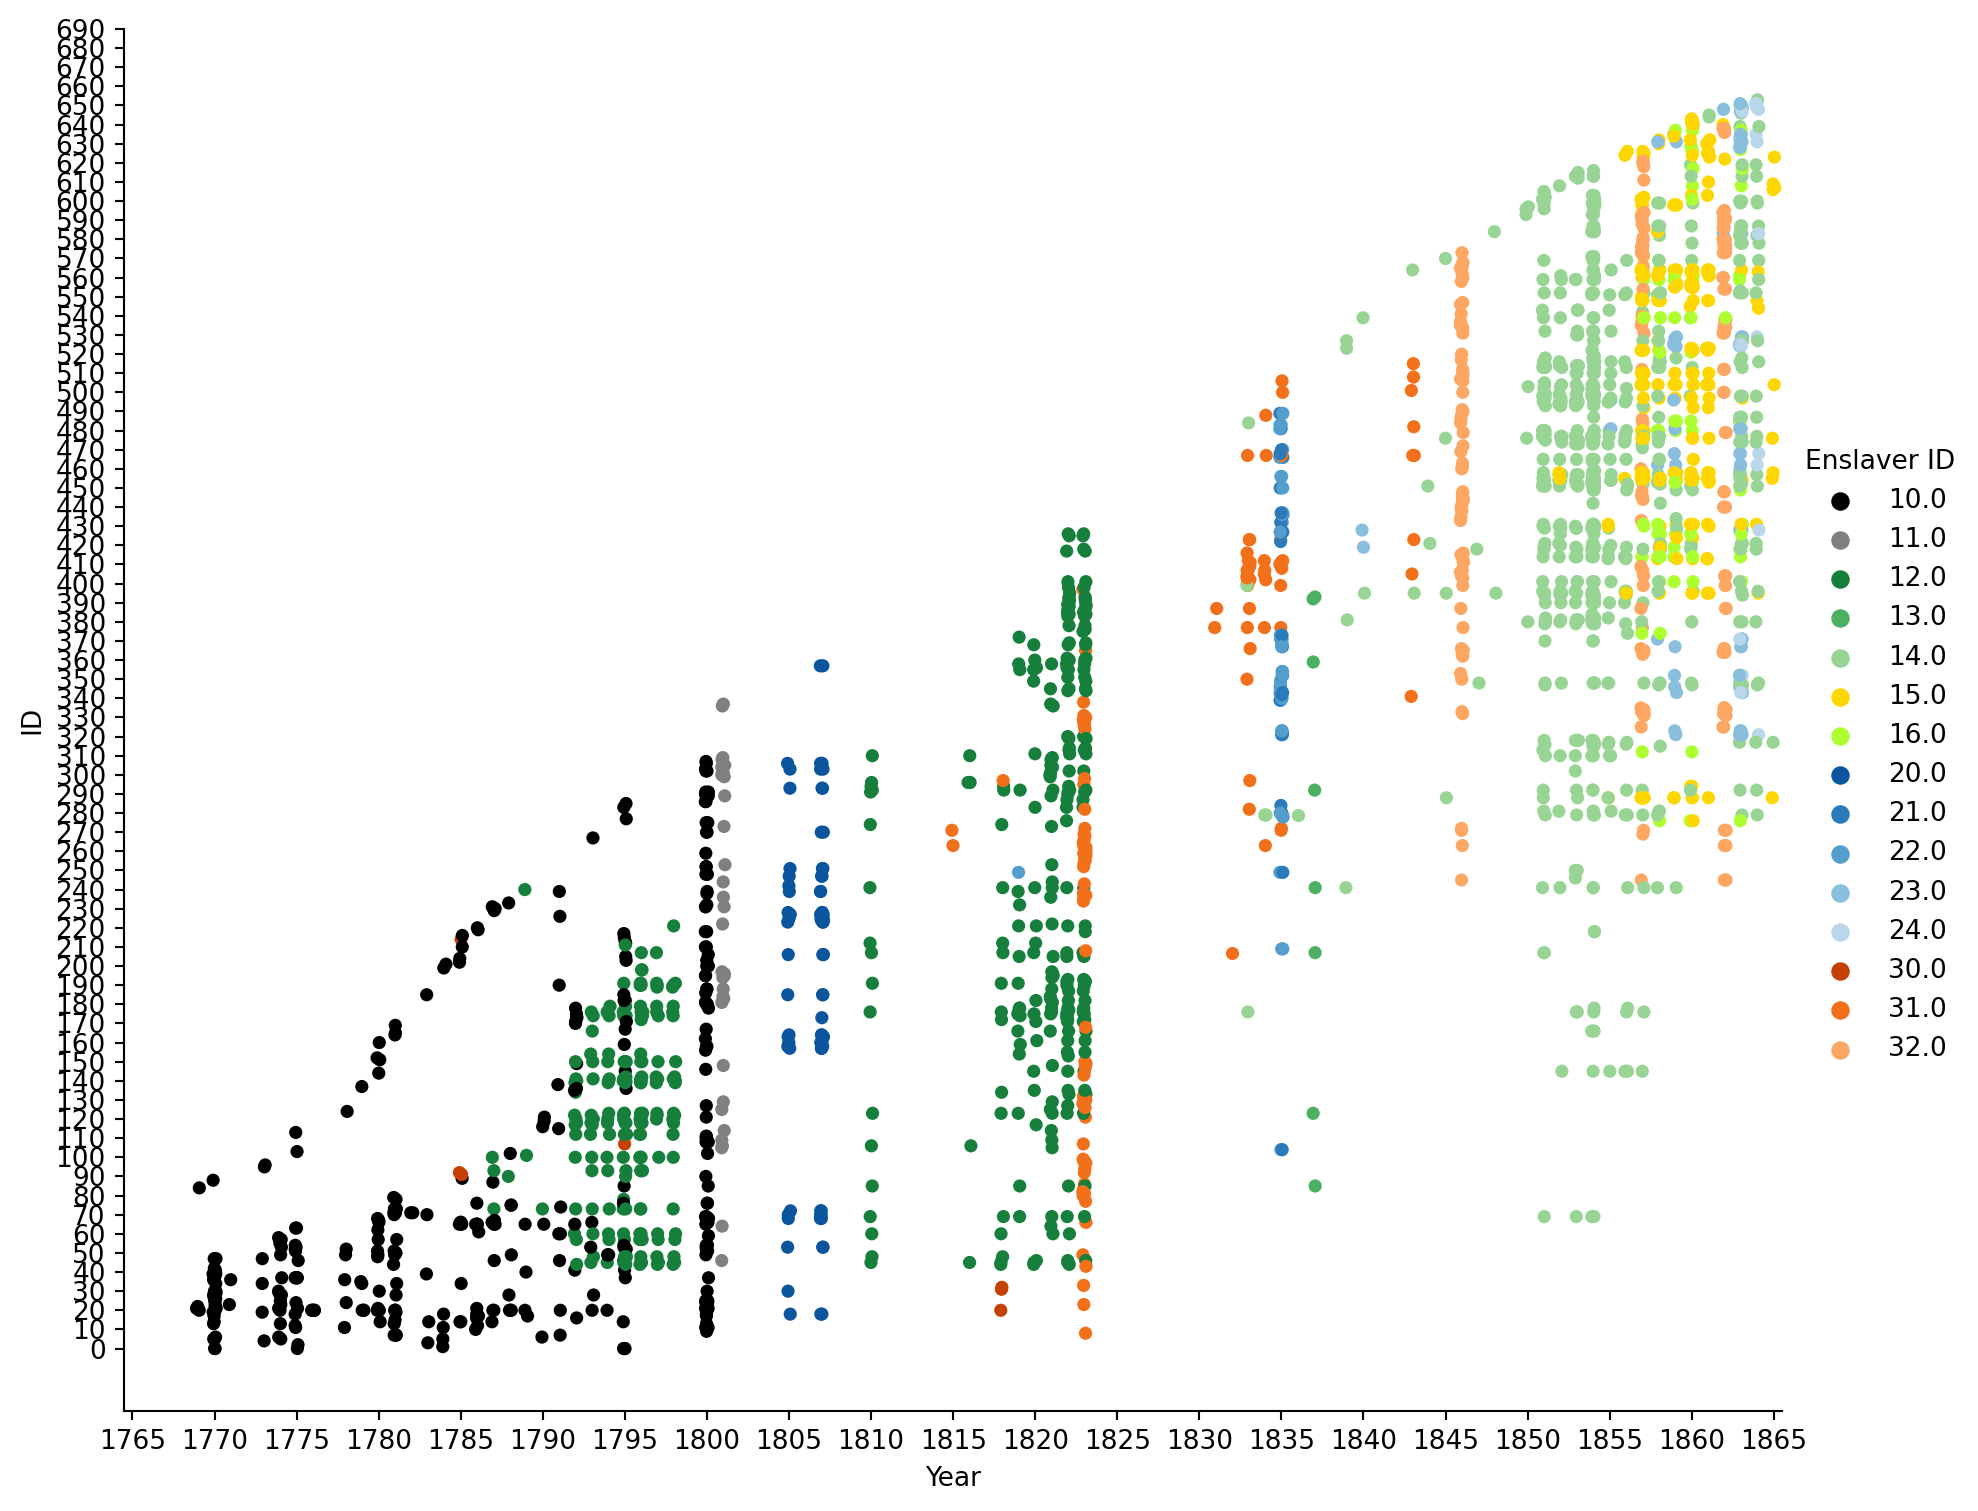

In [142]:
plt.rcParams.update({"figure.dpi": 190})

g= sns.catplot(data=a, x="Year", y="ID", hue="Enslaver ID", height = 8, aspect =1.2, palette=(['black','gray','#157f3b', '#4bb062', '#98d594','gold','greenyellow',   '#0b559f', '#2b7bba', '#539ecd', '#89bedc', '#bad6eb',    '#c54102', '#f3701b', '#fda762']))
g.set(xlabel ="Year")
g.set(yticks=np.arange(0,700,10))
g.set(xticks=np.arange(0,105,5))
g.savefig("EXPORTgraph.png")

#### Get Y-axis values by birth date- not individual number

In [143]:
dates = a.sort_values('ID').drop(columns={'RN','Enslaver ID','Year'}).drop_duplicates()
dates['ID'] =dates['ID']/10
dates['test'] = dates['ID'].apply(lambda x: x.is_integer())
dates = dates[dates['test'] != False]
dates['ID'] =dates['ID']*10
dates= dates[['ID','Birthyear']].sort_values('ID').set_index('ID')
dates 

,Birthyear
ID,
0.0,1705.0
10.0,1740.0
20.0,1755.0
30.0,1757.0
40.0,1760.0
50.0,1761.0
60.0,1765.0
70.0,1766.0
80.0,1768.0


## People at Plantations by Decade and Losses of persons over time

### Convert the Event Date to datetime to order events correctly

In [144]:
test = enslaved.copy()
#make a copy 
test = test[['Person','Given Name','Alternate Name','Surname','Sex','RN','Birthyear','Deathyear','Father','Mother','Spouses','Children','Event ID','Event Type','Place','Status','Enslaver ID','Date','Year']]
print(test.shape)
#downselect to just the enslaved
test = test[test['Status']!= 'Enslaver']
test = test[test['Status']!= 'Overseer']

test['Date'] = pd.to_datetime(test['Date'],dayfirst=False, yearfirst=True,format='mixed')

#narrow down to just birth and death year
test[['Birthyear', 'Year']] = test[['Birthyear', 'Year']].astype(int)
test[['Deathyear']] = test[['Deathyear']].astype(float)

test= test[test['Year']<=1865]

print(test.shape)
test.head()

(3938, 19)
(3727, 19)


,Person,Given Name,Alternate Name,Surname,Sex,RN,Birthyear,Deathyear,Father,Mother,Spouses,Children,Event ID,Event Type,Place,Status,Enslaver ID,Date,Year
0,PERS-CAB-PERS-CAB-259-UH-UH,Sam,NaN,NaN,M,259,1793,NaN,NaN,NaN,NaN,NaN,EVE-ENS-090,Enslaved,Unknown,Enslaved,PERS-CAB-0-UH,1808-01-01,1808
1,PERS-CAB-PERS-CAB-1240-UH-UH,Creasy,NaN,NaN,F,1240,1790,NaN,NaN,PERS-CAB-2-UH,NaN,NaN,EVE-ENS-090,Enslaved,Unknown,Enslaved,PERS-CAB-0-UH,1808-01-01,1808
2,PERS-CAB-PERS-CAB-74-UH-UH,Will,Creasy's boy,NaN,M,74,1781,NaN,PERS-CAB-613-UH,PERS-CAB-73-UH,NaN,NaN,EVE-ENS-090,Enslaved,Unknown,Enslaved,PERS-CAB-0-UH,1808-01-01,1808
3,PERS-CAB-PERS-CAB-1242-UH-UH,Madiso,NaN,NaN,M,1242,1836,NaN,NaN,NaN,NaN,NaN,EVE-ENS-090,Enslaved,Unknown,Enslaved,PERS-CAB-0-UH,1846-02-05,1846
4,PERS-CAB-PERS-CAB-73-UH-UH,Creasy,NaN,NaN,F,73,1766,NaN,NaN,NaN,PERS-CAB-613-UH,"PERS-CAB-74-UH,PERS-CAB-78-UH",EVE-ENS-090,Enslaved,Unknown,Enslaved,PERS-CAB-0-UH,1808-01-01,1808


In [145]:
test['Enslaver ID'] = test['Enslaver ID'].replace(regex=[r'\D+'], value="")
test[['Enslaver ID','RN']] = test[['Enslaver ID','RN']].astype(float)

test= test.sort_values(['RN','Date'])
test= test[['RN','Date','Year','Birthyear','Deathyear','Event ID','Place','Event Type','Enslaver ID']]

test= test.drop_duplicates()
print(test.shape)
test.head()

(3727, 9)


,RN,Date,Year,Birthyear,Deathyear,Event ID,Place,Event Type,Enslaver ID
1413,1.0,1770-01-01,1770,1745,NaN,EVE-ENS-001,Colleton,Enslaved,43.0
1831,1.0,1770-09-22,1770,1745,NaN,EVE-NEC-002,Colleton,Necessities,43.0
1817,1.0,1780-09-25,1780,1745,NaN,EVE-BIR-013,Union Hill,Birth,43.0
1806,1.0,1783-11-05,1783,1745,NaN,EVE-BIR-017,Union Hill,Birth,43.0
1819,1.0,1785-08-14,1785,1745,NaN,EVE-BIR-020,Union Hill,Birth,43.0


In [146]:
test = test.sort_values(['RN','Date','Event Type'])
test['Prev_ID'] = test.groupby(['RN'])['Enslaver ID'].shift(1).fillna(10000)

test['Next_ID'] = test.groupby(['RN'])['Enslaver ID'].shift(-1).fillna(10000)
test[['Prev_ID', 'Enslaver ID', 'Next_ID']] = test[['Prev_ID', 'Enslaver ID', 'Next_ID']].astype(float)
test = test[['RN','Date','Birthyear','Deathyear','Event ID','Place','Event Type','Year','Prev_ID','Enslaver ID','Next_ID']]

print(test.shape)
test.head(20)

(3727, 11)


,RN,Date,Birthyear,Deathyear,Event ID,Place,Event Type,Year,Prev_ID,Enslaver ID,Next_ID
1413,1.0,1770-01-01,1745,NaN,EVE-ENS-001,Colleton,Enslaved,1770,10000.0,43.0,43.0
1831,1.0,1770-09-22,1745,NaN,EVE-NEC-002,Colleton,Necessities,1770,43.0,43.0,43.0
1817,1.0,1780-09-25,1745,NaN,EVE-BIR-013,Union Hill,Birth,1780,43.0,43.0,43.0
1806,1.0,1783-11-05,1745,NaN,EVE-BIR-017,Union Hill,Birth,1783,43.0,43.0,43.0
1819,1.0,1785-08-14,1745,NaN,EVE-BIR-020,Union Hill,Birth,1785,43.0,43.0,43.0
1811,1.0,1785-09-22,1745,NaN,EVE-BIR-021,Union Hill,Birth,1785,43.0,43.0,43.0
1808,1.0,1787-03-03,1745,NaN,EVE-BIR-026,Union Hill,Birth,1787,43.0,43.0,43.0
1801,1.0,1795-07-25,1745,NaN,EVE-BIR-033,Union Hill,Birth,1795,43.0,43.0,10000.0
1769,2.0,1770-01-01,1766,NaN,EVE-ENS-001,Colleton,Enslaved,1770,10000.0,43.0,43.0
1828,2.0,1780-09-25,1766,NaN,EVE-BIR-013,Union Hill,Birth,1780,43.0,43.0,43.0


### Identify people with a documented birth date

In [147]:
people = test[test['Event Type']=='Birth'].sort_values('RN')
people= people[people['Year'] == people['Birthyear']]
people = people['RN'].drop_duplicates().to_list()
len(people)

65

In [148]:
#now distinguish off Union Hill plantations and within the plantations
test['IN'] = 'Existing Person'
test['IN'] = test['IN'].where(test['Prev_ID'] == test['Enslaver ID'],'Transferred In')
test['IN'] = test['IN'].where(test['Prev_ID'].isin(Enslavers),'Bought')
test['IN'] = test['IN'].where(test['Prev_ID'] !=10000, 'New Person')
test['IN'] = test['IN'].where(~test['RN'].isin(people), test['IN'].replace(to_replace='New Person', value='Birth'))
print(test.shape)
test.head(15)

(3727, 12)


,RN,Date,Birthyear,Deathyear,Event ID,Place,Event Type,Year,Prev_ID,Enslaver ID,Next_ID,IN
1413,1.0,1770-01-01,1745,NaN,EVE-ENS-001,Colleton,Enslaved,1770,10000.0,43.0,43.0,New Person
1831,1.0,1770-09-22,1745,NaN,EVE-NEC-002,Colleton,Necessities,1770,43.0,43.0,43.0,Existing Person
1817,1.0,1780-09-25,1745,NaN,EVE-BIR-013,Union Hill,Birth,1780,43.0,43.0,43.0,Existing Person
1806,1.0,1783-11-05,1745,NaN,EVE-BIR-017,Union Hill,Birth,1783,43.0,43.0,43.0,Existing Person
1819,1.0,1785-08-14,1745,NaN,EVE-BIR-020,Union Hill,Birth,1785,43.0,43.0,43.0,Existing Person
1811,1.0,1785-09-22,1745,NaN,EVE-BIR-021,Union Hill,Birth,1785,43.0,43.0,43.0,Existing Person
1808,1.0,1787-03-03,1745,NaN,EVE-BIR-026,Union Hill,Birth,1787,43.0,43.0,43.0,Existing Person
1801,1.0,1795-07-25,1745,NaN,EVE-BIR-033,Union Hill,Birth,1795,43.0,43.0,10000.0,Existing Person
1769,2.0,1770-01-01,1766,NaN,EVE-ENS-001,Colleton,Enslaved,1770,10000.0,43.0,43.0,New Person
1828,2.0,1780-09-25,1766,NaN,EVE-BIR-013,Union Hill,Birth,1780,43.0,43.0,43.0,Existing Person


In [149]:
test['IN'].value_counts()

IN
Existing Person    2254
Transferred In      735
New Person          614
Birth                65
Bought               59
Name: count, dtype: int64

### Identify people with a documented death date

In [150]:
people = test[test['Event Type']=='Death'].sort_values('RN')
people= people[people['Year'] == people['Deathyear']]
people = people['RN'].drop_duplicates().to_list()
len(people)

29

In [151]:
test['OUT'] = 'None'
test['OUT'] = test['OUT'].where(test['Next_ID']==test['Enslaver ID'],'Transferring Out')
test['OUT'] = test['OUT'].where(test['Next_ID'].isin(Enslavers),'Sold')
test['OUT'] = test['OUT'].where(test['Next_ID'] != 10000,'Last event')
test['OUT'] = test['OUT'].where(test['Event Type'] != 'Emancipation','Free')
test['OUT'] = test['OUT'].where(~test['RN'].isin(people), test['OUT'].replace(to_replace='Last event', value='Death'))
test['OUT'].value_counts()

OUT
None                2254
Last event           650
Transferring Out     649
Sold                 136
Death                 29
Free                   9
Name: count, dtype: int64

## Summary of In and OUT across the data set

In [152]:
test[test['IN']=='Bought'].drop_duplicates().groupby(['IN'])['RN'].nunique()


IN
Bought    49
Name: RN, dtype: int64

In [153]:
test[test['IN']=='Transferred In'].drop_duplicates().groupby(['IN'])['RN'].nunique()

IN
Transferred In    423
Name: RN, dtype: int64

In [154]:
test[test['IN']=='New Person'].drop_duplicates().groupby(['IN'])['RN'].nunique()

IN
New Person    598
Name: RN, dtype: int64

In [155]:
test[test['OUT']=='Free'].drop_duplicates().groupby(['OUT'])['RN'].nunique()

OUT
Free    9
Name: RN, dtype: int64

In [156]:
test[test['IN']=='Birth'].drop_duplicates().groupby(['IN'])['RN'].nunique()

IN
Birth    65
Name: RN, dtype: int64

In [157]:
test[test['OUT']=='Transferring Out'].drop_duplicates().groupby(['OUT'])['RN'].nunique()

OUT
Transferring Out    372
Name: RN, dtype: int64

In [158]:
test[test['OUT']=='Sold'].drop_duplicates().groupby(['OUT'])['RN'].nunique()

OUT
Sold    122
Name: RN, dtype: int64

In [159]:
test[test['OUT']=='Last event'].drop_duplicates().groupby(['OUT'])['RN'].nunique()

OUT
Last event    634
Name: RN, dtype: int64

In [160]:
test[test['OUT']=='Death'].drop_duplicates().groupby(['OUT'])['RN'].nunique()

OUT
Death    29
Name: RN, dtype: int64

### Summary data across all Union Hill Plantations - How Enslaved came on plantations

In [161]:
a= test.groupby(['Year'])['RN'].nunique().to_frame().rename(columns={'RN':'total'})
b = test.groupby(['RN','Year']).first().reset_index()
b = b.groupby(['Year','IN'])['RN'].nunique().to_frame().reset_index().pivot(index=['Year'], columns='IN', values='RN').reset_index().sort_values('Year').set_index('Year').fillna(0)

c = a.join(b)
c.head()


,total,Birth,Bought,Existing Person,New Person,Transferred In
Year,,,,,,
1765,1,0.0,0.0,0.0,1.0,0.0
1769,5,1.0,0.0,0.0,4.0,0.0
1770,32,1.0,0.0,4.0,27.0,0.0
1771,2,0.0,0.0,2.0,0.0,0.0
1773,6,2.0,0.0,3.0,1.0,0.0


In [162]:
a= test.groupby(['Year'])['RN'].nunique().to_frame().rename(columns={'RN':'total'})
e = test.groupby(['RN','Year']).last().reset_index()
e = e.groupby(['Year','OUT'])['RN'].nunique().to_frame().reset_index().pivot(index=['Year'], columns='OUT', values='RN').reset_index().fillna(0).set_index('Year').fillna(0)
f = a.join(e)
f.head()

,total,Death,Free,Last event,None,Sold,Transferring Out
Year,,,,,,,
1765,1,0.0,0.0,0.0,0.0,0.0,1.0
1769,5,0.0,0.0,1.0,4.0,0.0,0.0
1770,32,0.0,0.0,6.0,26.0,0.0,0.0
1771,2,0.0,0.0,0.0,2.0,0.0,0.0
1773,6,2.0,0.0,2.0,2.0,0.0,0.0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


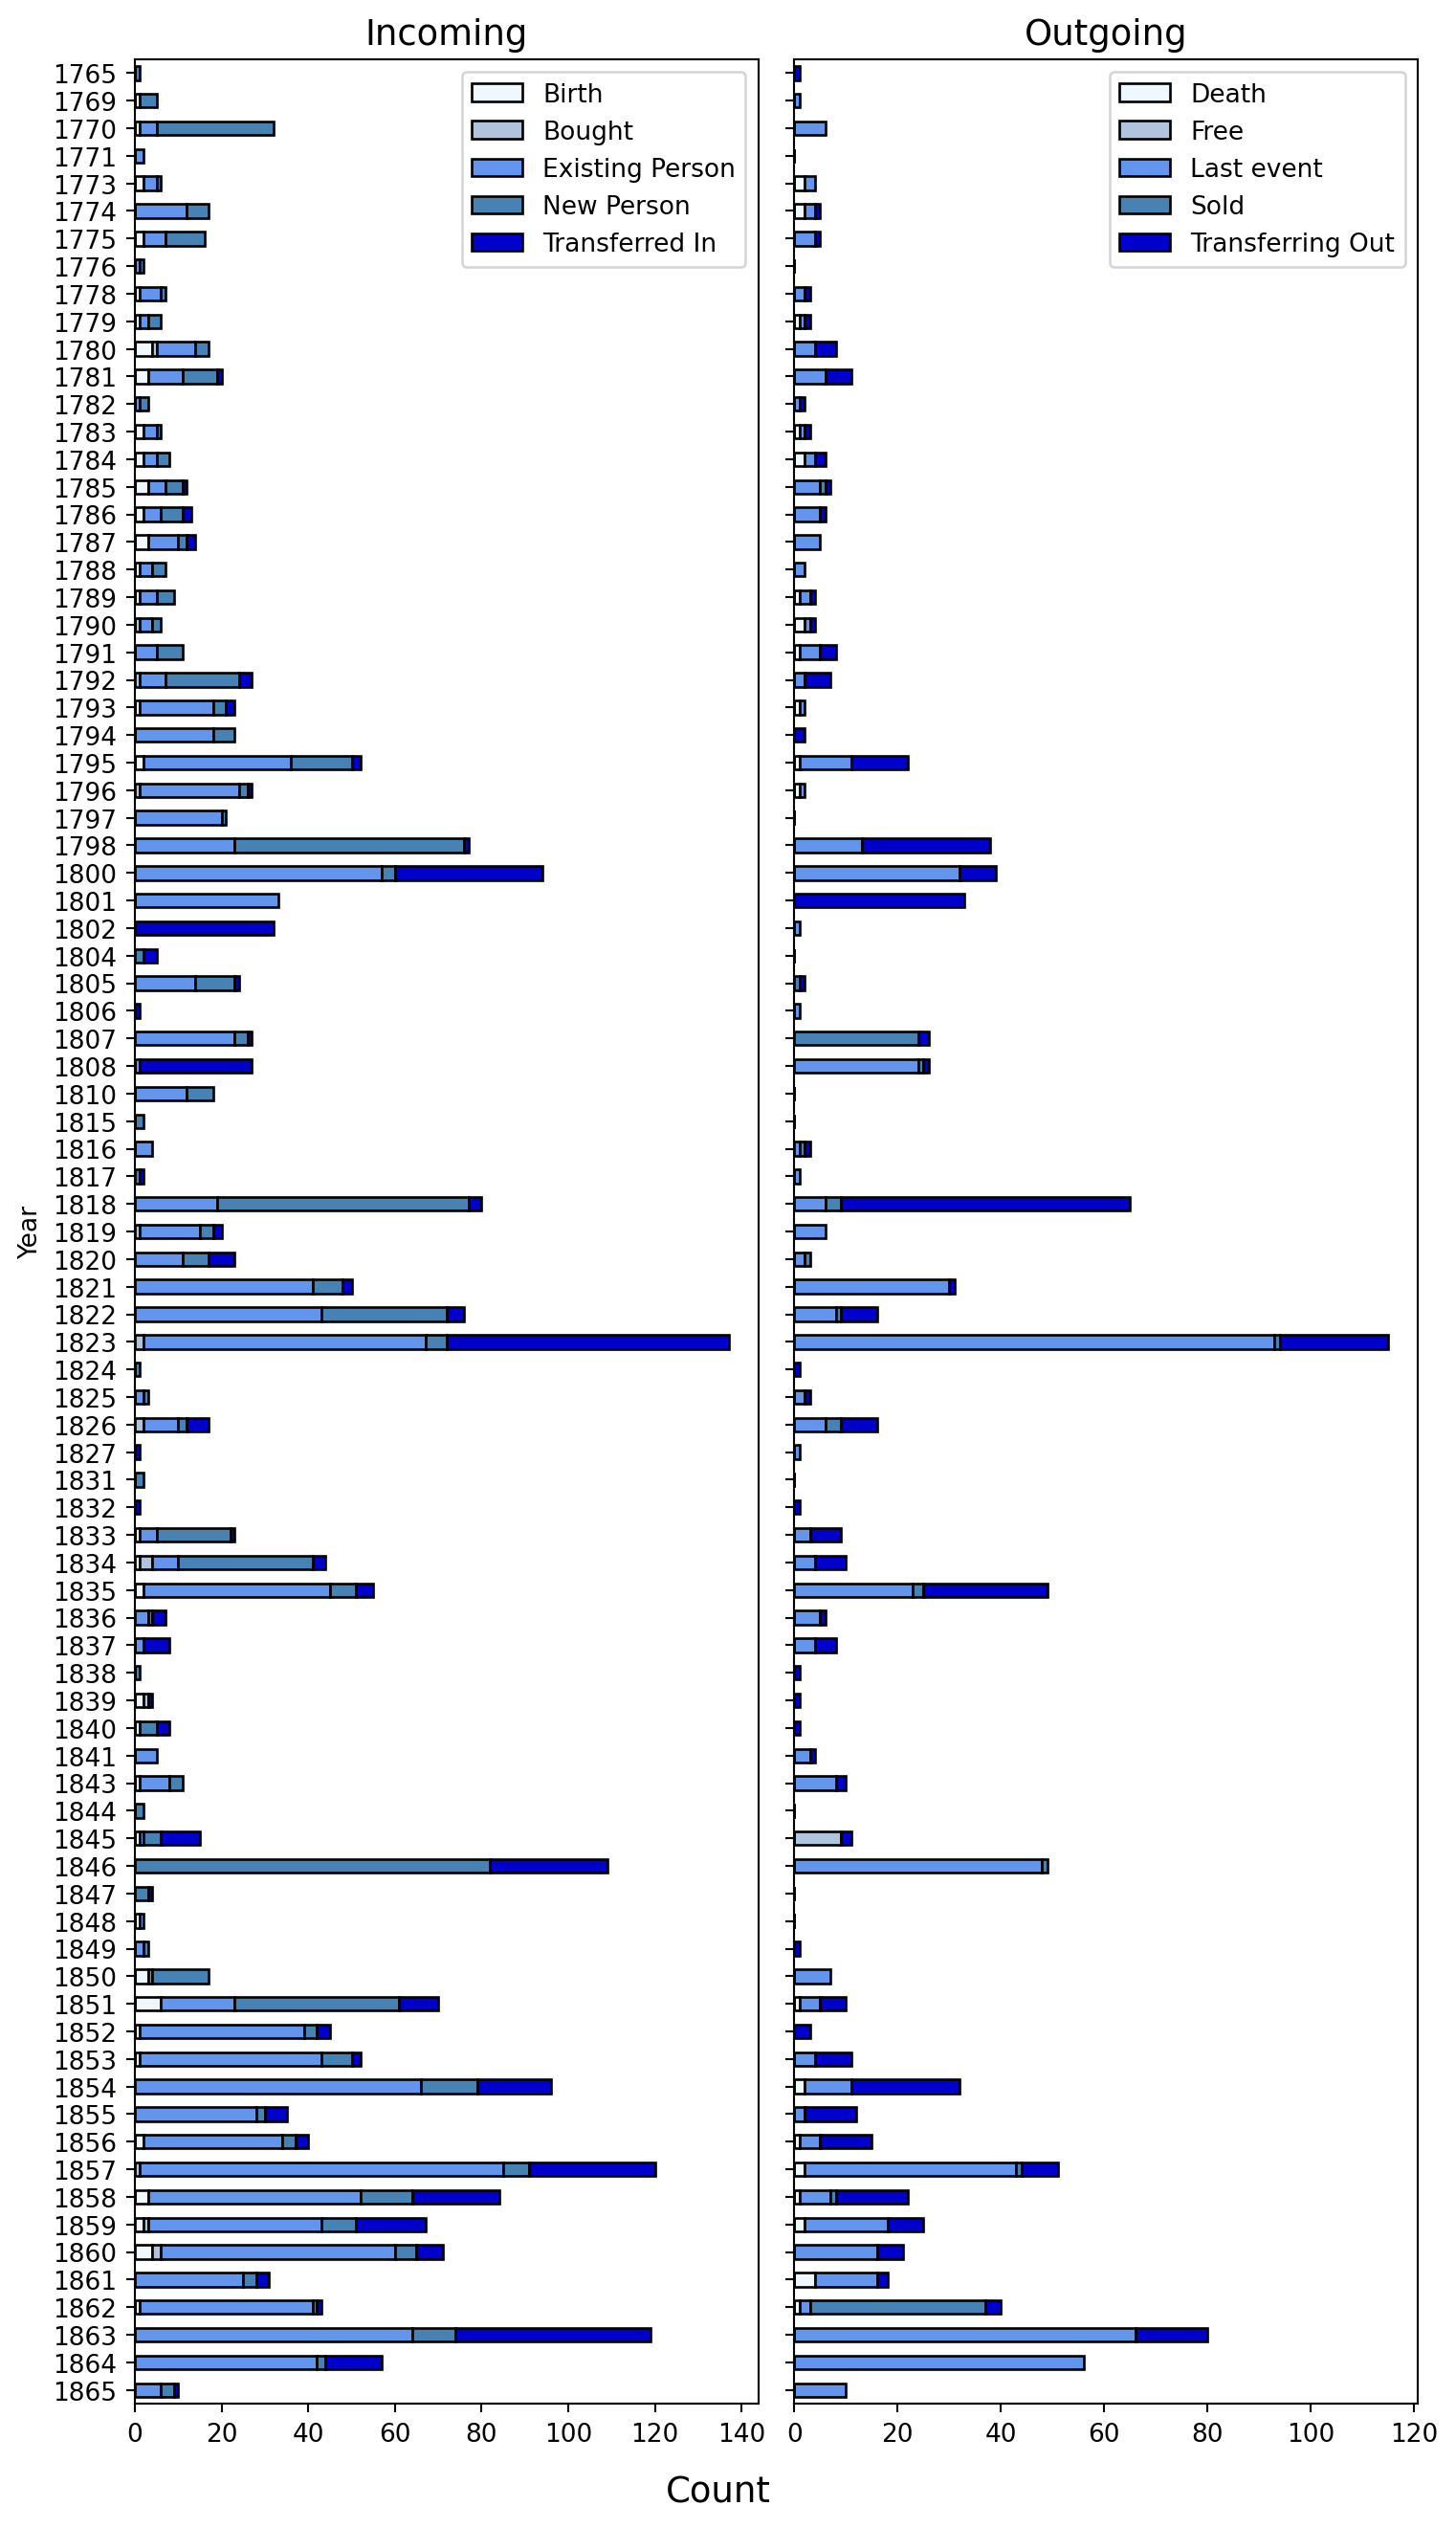

In [163]:
d= c.drop(columns={'total'})
g = f.drop(columns={'total', 'None'})

plt.rcParams["figure.figsize"] = (8, 14)
fig, (ax, ax2) = plt.subplots(ncols=2, sharey=True)
color = ['aliceblue', 'lightsteelblue', 'cornflowerblue', 'steelblue','mediumblue']
color2 = ['aliceblue', 'lightsteelblue', 'cornflowerblue', 'steelblue','mediumblue']
ax.set_title('Incoming', fontsize=14)
ax2.set_title('Outgoing', fontsize=14)

d.plot.barh(stacked=True, color= color, edgecolor='black', ax=ax)
plt.legend(loc='best')
plt.gca().invert_yaxis()

g.plot.barh(stacked=True, color= color2, edgecolor='black', ax=ax2)
plt.gca().invert_yaxis()
plt.legend(loc='best')
fig.supxlabel('Count', fontsize=14)

plt.tight_layout()
plt.show()

### Try rounding to year 5-year intervals

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


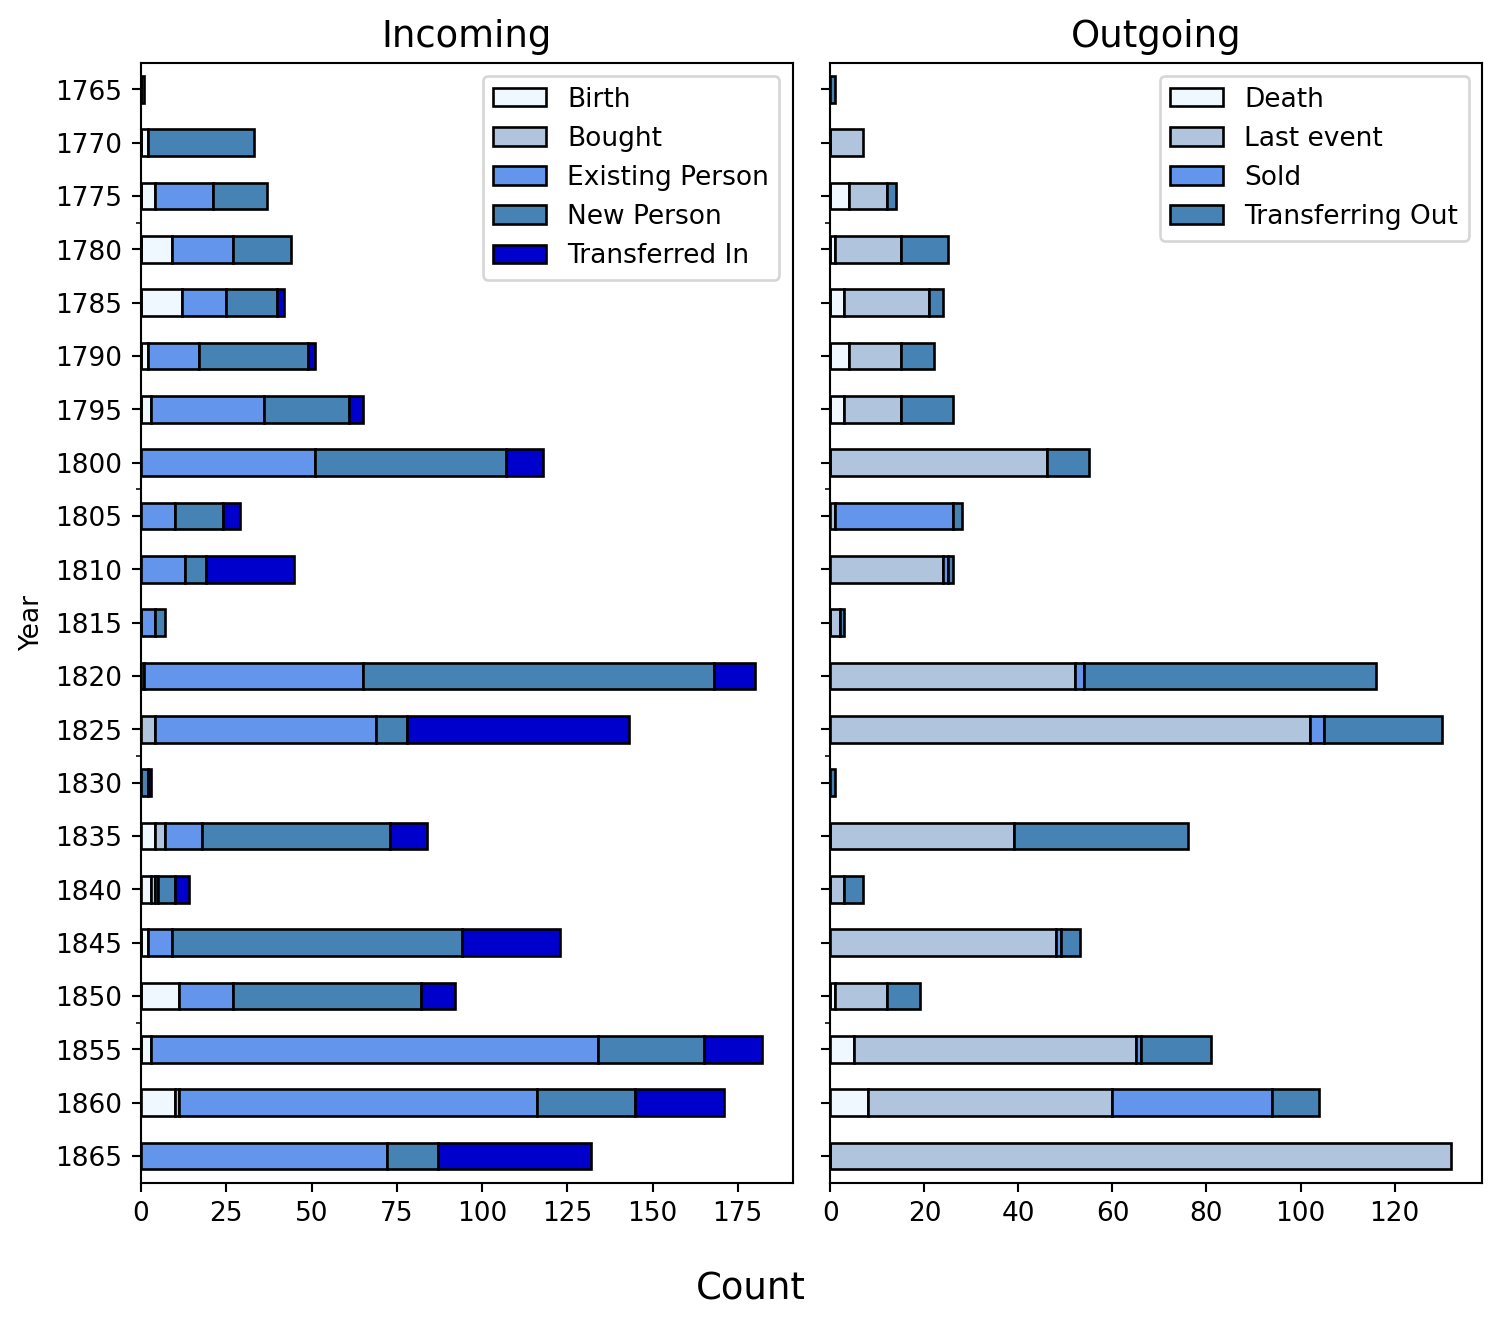

In [164]:
df= test.copy()
df['Year'] = (((df['Year'])*2).round(-1)/2).astype(int)

a = df.groupby(['Year'])['RN'].nunique().to_frame().rename(columns={'RN':'total'})
b = df.groupby(['RN','Year']).first().reset_index()
b = b.groupby(['Year','IN'])['RN'].nunique().to_frame().reset_index().pivot(index=['Year'], columns='IN', values='RN').reset_index().sort_values('Year').set_index('Year')

c = a.join(b).fillna(0)

e = df.groupby(['RN','Year']).last().reset_index()
e = e.groupby(['Year','OUT'])['RN'].nunique().to_frame().reset_index().pivot(index=['Year'], columns='OUT', values='RN').reset_index().fillna(0).set_index('Year')
f = a.join(e)
f.head(10)

d= c.drop(columns={'total'})
g = f.drop(columns={'total', 'None'})

plt.rcParams["figure.figsize"] = (8,7)
fig, (ax, ax2) = plt.subplots(ncols=2, sharey=True)
color = ['aliceblue', 'lightsteelblue', 'cornflowerblue', 'steelblue','mediumblue']
color2 = ['aliceblue', 'lightsteelblue', 'cornflowerblue', 'steelblue','mediumblue']
ax.set_title('Incoming', fontsize=14)
ax2.set_title('Outgoing', fontsize=14)

d.plot.barh(stacked=True, color= color, edgecolor='black', ax=ax)
plt.legend(loc='best')
plt.gca().invert_yaxis()

g.plot.barh(stacked=True, color= color2, edgecolor='black', ax=ax2)
plt.gca().invert_yaxis()
plt.legend(loc='best')
fig.supxlabel('Count', fontsize=14)

plt.tight_layout()
plt.show()

### Union Hill

In [165]:
df = test[test['Place']=='Union Hill']
people = df['RN'].drop_duplicates().tolist()
len(people)

UH = test[test['RN'].isin(people)]

UHenslavers=[43,44,45,46,269,207,282,866]
UH =test[test['RN'].isin(people)]
print(UH.shape)
UH = UH[UH['Enslaver ID'].isin(UHenslavers)]
UH = UH[UH['Year'] >= 1776]
print(UH['RN'].nunique())
UH.head()

(2444, 13)
356


,RN,Date,Birthyear,Deathyear,Event ID,Place,Event Type,Year,Prev_ID,Enslaver ID,Next_ID,IN,OUT
1817,1.0,1780-09-25,1745,NaN,EVE-BIR-013,Union Hill,Birth,1780,43.0,43.0,43.0,Existing Person,None
1806,1.0,1783-11-05,1745,NaN,EVE-BIR-017,Union Hill,Birth,1783,43.0,43.0,43.0,Existing Person,None
1819,1.0,1785-08-14,1745,NaN,EVE-BIR-020,Union Hill,Birth,1785,43.0,43.0,43.0,Existing Person,None
1811,1.0,1785-09-22,1745,NaN,EVE-BIR-021,Union Hill,Birth,1785,43.0,43.0,43.0,Existing Person,None
1808,1.0,1787-03-03,1745,NaN,EVE-BIR-026,Union Hill,Birth,1787,43.0,43.0,43.0,Existing Person,None


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


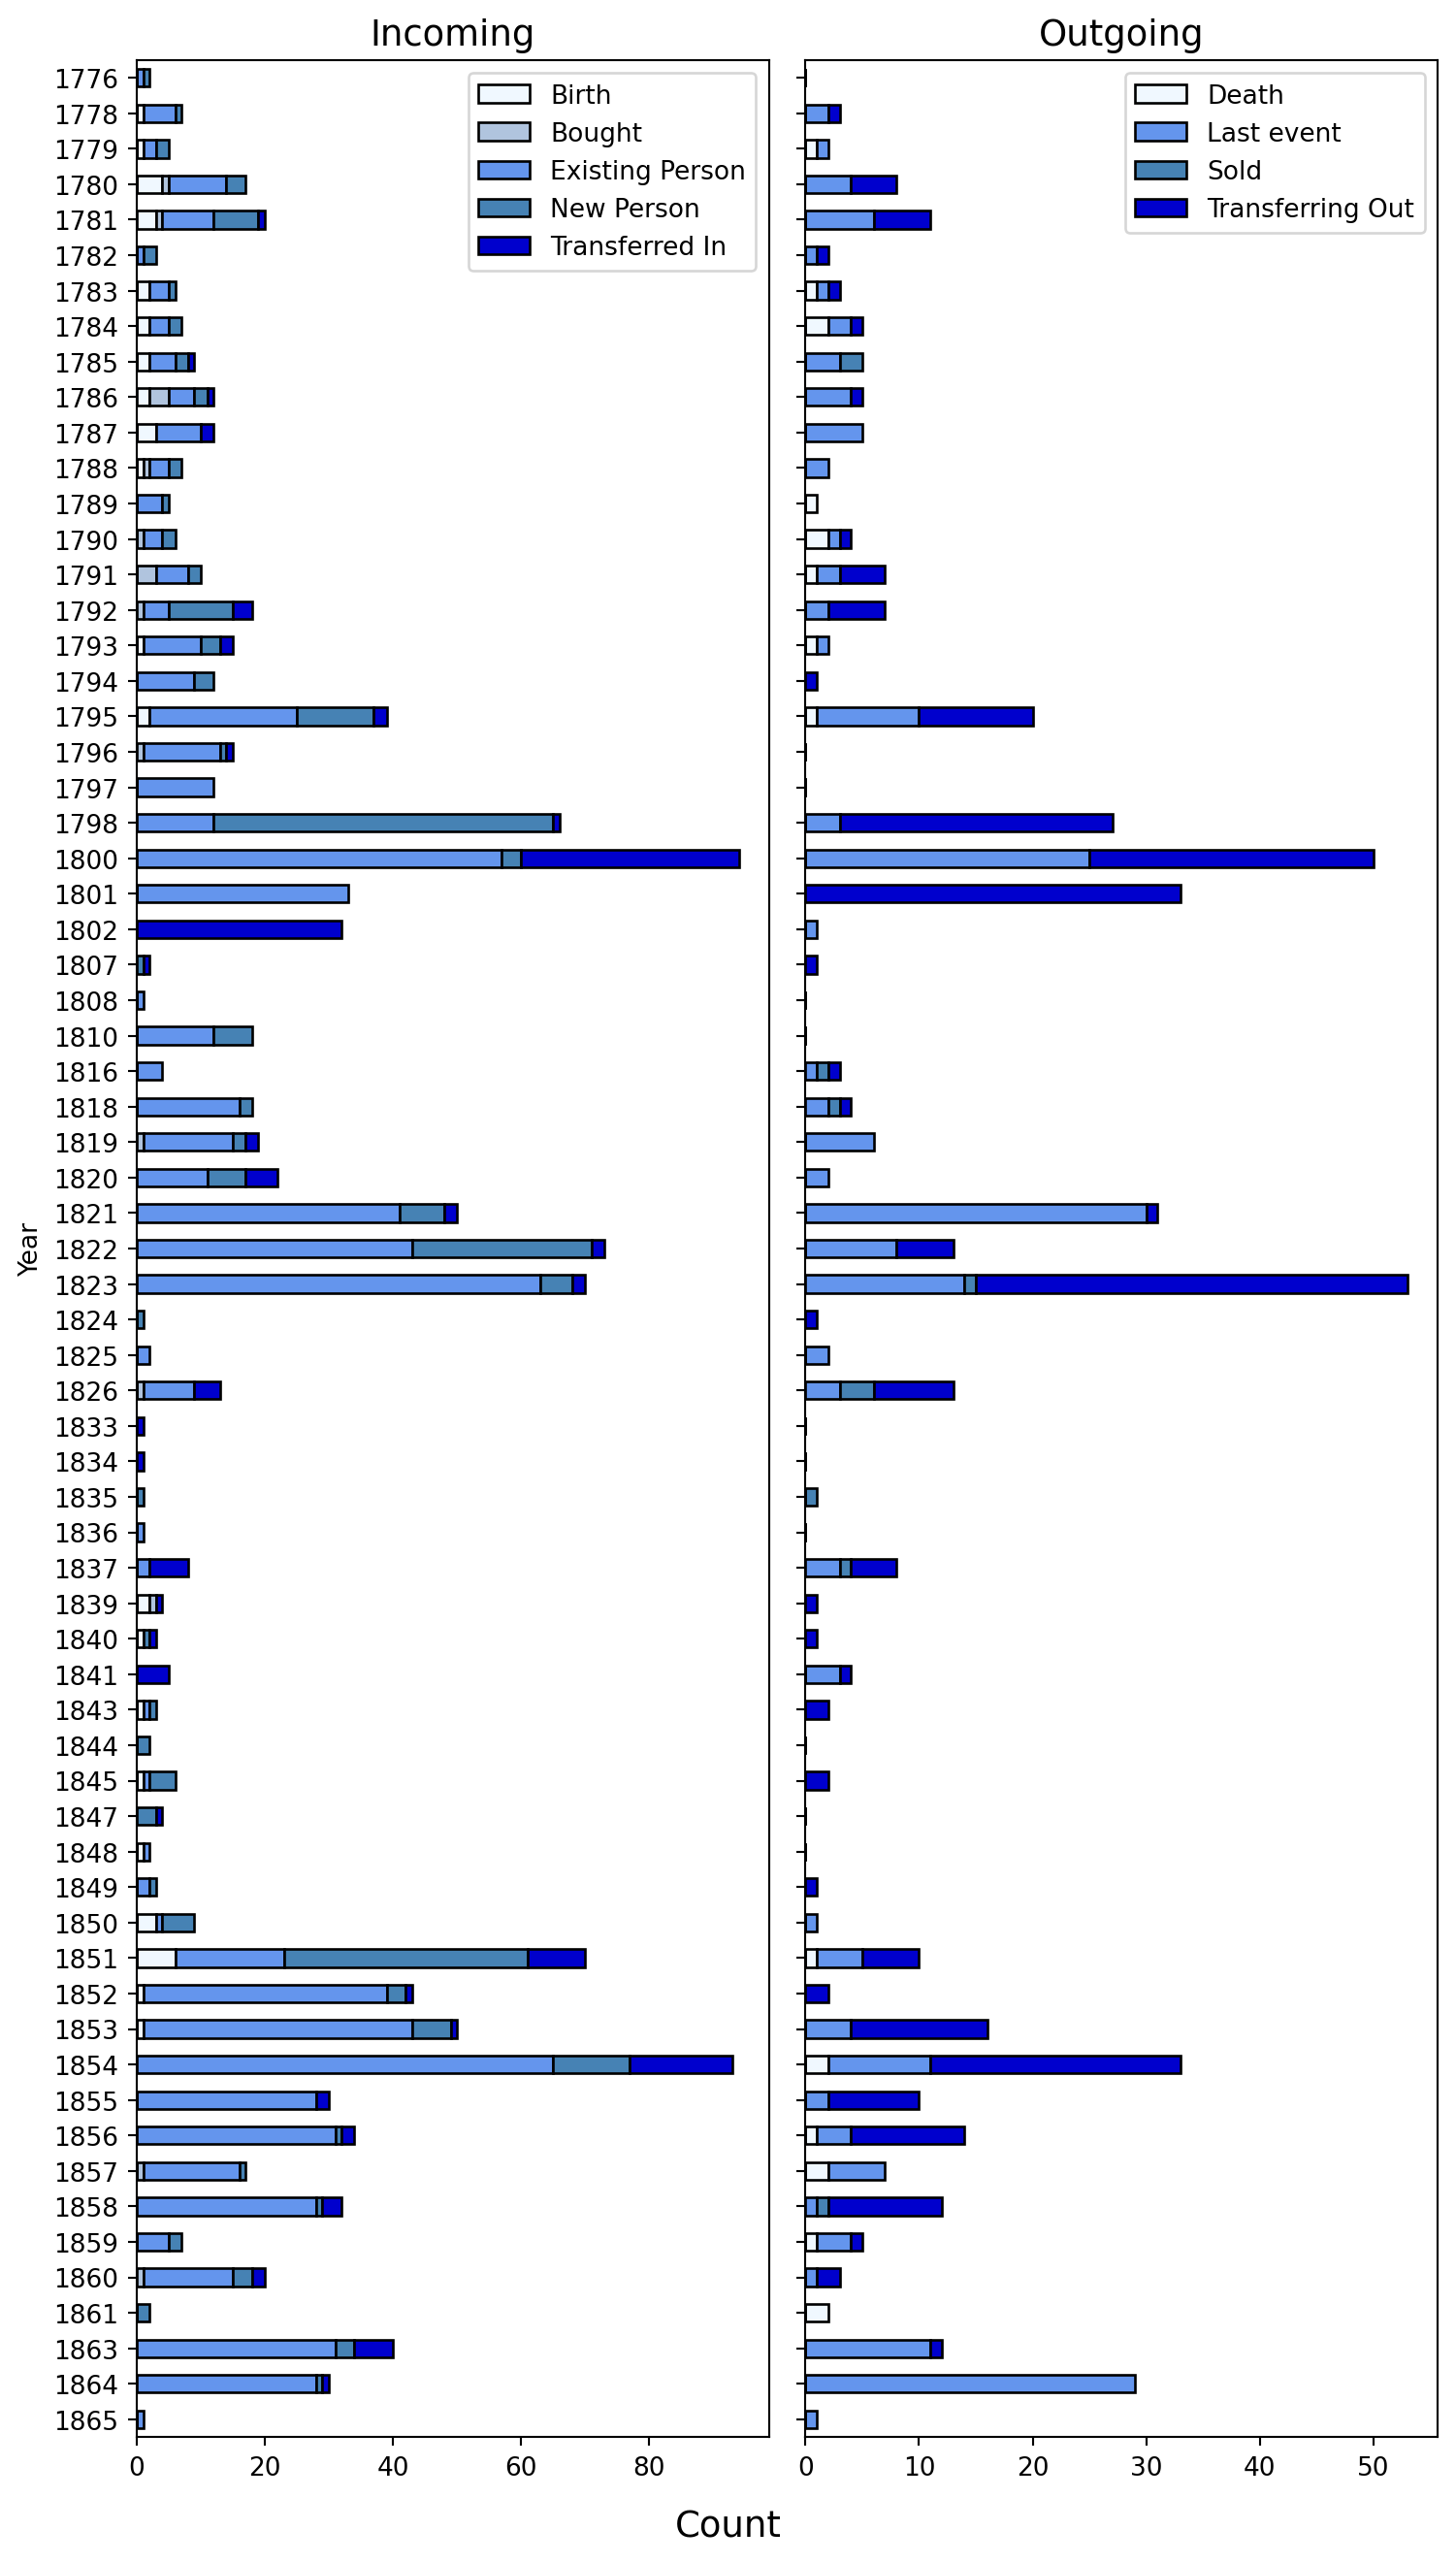

In [166]:
df= UH.copy()
#df['Year'] = (((df['Year'])*2).round(-1)/2).astype(int)
a = df.groupby(['Year'])['RN'].nunique().to_frame().rename(columns={'RN':'total'})
b = df.groupby(['RN','Year']).first().reset_index()
b = b.groupby(['Year','IN'])['RN'].nunique().to_frame().reset_index().pivot(index=['Year'], columns='IN', values='RN').reset_index().sort_values('Year').set_index('Year')

c = a.join(b).fillna(0)

e = df.groupby(['RN','Year']).last().reset_index()
e = e.groupby(['Year','OUT'])['RN'].nunique().to_frame().reset_index().pivot(index=['Year'], columns='OUT', values='RN').reset_index().fillna(0).set_index('Year')
f = a.join(e)
f.head(10)

d= c.drop(columns={'total'})
g = f.drop(columns={'total', 'None'})

plt.rcParams["figure.figsize"] = (8, 14)
fig, (ax, ax2) = plt.subplots(ncols=2, sharey=True)
color = ['aliceblue', 'lightsteelblue', 'cornflowerblue', 'steelblue','mediumblue']
color2 = ['aliceblue',  'cornflowerblue', 'steelblue','mediumblue']
ax.set_title('Incoming', fontsize=14)
ax2.set_title('Outgoing', fontsize=14)

d.plot.barh(stacked=True, color= color, edgecolor='black', ax=ax)
plt.legend(loc='best')
plt.gca().invert_yaxis()

g.plot.barh(stacked=True, color= color2, edgecolor='black', ax=ax2)
plt.gca().invert_yaxis()
plt.legend(loc='best')
fig.supxlabel('Count', fontsize=14)

plt.tight_layout()
plt.show()

### Round year to closest 5 year 

In [167]:
df= UH.copy()
df['Year'] = ((df['Year']*2).round(-1)/2)

a = df.groupby(['Year'])['RN'].nunique().to_frame().rename(columns={'RN':'total'})
b = df.groupby(['RN','Year']).first().reset_index()
b = b.groupby(['Year','IN'])['RN'].nunique().to_frame().reset_index().pivot(index=['Year'], columns='IN', values='RN').reset_index().sort_values('Year').set_index('Year')

c = a.join(b).fillna(0)

e = df.groupby(['RN','Year']).last().reset_index()
e = e.groupby(['Year','OUT'])['RN'].nunique().to_frame().reset_index().pivot(index=['Year'], columns='OUT', values='RN').reset_index().fillna(0).set_index('Year')
f = a.join(e)
f.head(10)

d= c.drop(columns={'total'})
g = f.drop(columns={'total', 'None'})

c

,total,Birth,Bought,Existing Person,New Person,Transferred In
Year,,,,,,
1775.0,2,0.0,0.0,1.0,1.0,0.0
1780.0,44,9.0,2.0,18.0,15.0,0.0
1785.0,37,11.0,3.0,13.0,7.0,3.0
1790.0,40,1.0,6.0,14.0,17.0,2.0
1795.0,50,3.0,1.0,23.0,19.0,4.0
1800.0,107,0.0,0.0,40.0,56.0,11.0
1805.0,2,0.0,0.0,0.0,1.0,1.0
1810.0,19,0.0,0.0,13.0,6.0,0.0
1815.0,4,0.0,0.0,4.0,0.0,0.0


In [168]:
f

,total,Death,Last event,None,Sold,Transferring Out
Year,,,,,,
1775.0,2,0.0,0.0,2.0,0.0,0.0
1780.0,44,1.0,14.0,19.0,0.0,10.0
1785.0,37,3.0,15.0,15.0,2.0,2.0
1790.0,40,4.0,7.0,20.0,0.0,9.0
1795.0,50,2.0,10.0,28.0,0.0,10.0
1800.0,107,0.0,29.0,52.0,0.0,26.0
1805.0,2,0.0,0.0,1.0,0.0,1.0
1810.0,19,0.0,0.0,19.0,0.0,0.0
1815.0,4,0.0,1.0,1.0,1.0,1.0


### Enslaved by Enslaver for 5 year intervals at Union Hill

In [169]:
df= UH.copy()
df['Year'] = ((df['Year']*2).round(-1)/2)
df.groupby(['Year','Enslaver ID'])['RN'].nunique().to_frame().rename(columns={'RN':'total'})

total
Year   Enslaver ID       
1775.0 43.0             2
1780.0 43.0            43
       44.0             5
1785.0 43.0            36
       44.0             2
1790.0 43.0            34
       44.0             7
1795.0 43.0            31
       44.0            20
1800.0 43.0            85
       44.0            59
       269.0           36
1805.0 44.0             1
       46.0             1
1810.0 44.0            19
1815.0 44.0             4
1820.0 44.0           116
       45.0             1
1825.0 44.0            64
       45.0            10
       46.0             9
       207.0           16
       282.0           16
1835.0 45.0             9
       46.0             8
1840.0 45.0            12
1845.0 45.0            14
1850.0 45.0            84
1855.0 45.0           110
       866.0            7
1860.0 45.0            46
       866.0            1
1865.0 45.0            42

In [170]:
df= UH.copy()
df['Year'] = (df['Year'].round(-1))
df.groupby(['Year','Enslaver ID'])['RN'].nunique().to_frame().rename(columns={'RN':'total'})

total
Year Enslaver ID       
1780 43.0            59
     44.0             5
1790 43.0            52
     44.0            16
1800 43.0           103
     44.0            64
     269.0           36
1810 44.0            20
     46.0             1
1820 44.0           120
     45.0            10
     46.0             8
     207.0           14
     282.0           16
1830 45.0             3
     46.0             1
     207.0            2
     282.0           13
1840 45.0            27
     46.0             8
1850 45.0           115
     866.0            7
1860 45.0            87
     866.0            1

#### Soldier's Joy

In [171]:
df = test[test['Place']=="Soldier's Joy"]
people = df['RN'].drop_duplicates().tolist()
print(len(people))
#SJenslavers=[272,735,1061,1062,1065,1088,1275,1278]
NonSJenslavers=[43,44,45,46,139, 187,207,262,276,892,735,1062,1129,1132, 1133, 1134, 1136,1137,1138,1147,1151,1154,1267,1268,1269,1270,1271,1272,1273,1274,1283,1284,1285,1286,1287,1288,1289]
SJ =test[test['RN'].isin(people)]
print(SJ.shape)
SJ =SJ[~SJ['Enslaver ID'].isin(NonSJenslavers)]
print(SJ.shape)
SJ.head(10)

188
(835, 13)
(641, 13)


,RN,Date,Birthyear,Deathyear,Event ID,Place,Event Type,Year,Prev_ID,Enslaver ID,Next_ID,IN,OUT
1065,8.0,1800-01-03,1755,NaN,EVE-ENS-008,Soldier's Joy,Enslaved,1800,43.0,272.0,272.0,Transferred In,None
1071,8.0,1818-06-04,1755,NaN,EVE-WILL-017,Soldier's Joy,Will,1818,272.0,272.0,735.0,Existing Person,Sold
1120,13.0,1818-01-01,1755,NaN,EVE-ENS-008,Soldier's Joy,Enslaved,1818,43.0,272.0,1062.0,Transferred In,Sold
240,13.0,1823-01-01,1755,NaN,EVE-ENS-009,Soldier's Joy,Enslaved,1823,1062.0,1065.0,1065.0,Bought,None
239,13.0,1823-11-24,1755,NaN,EVE-PRO-018,Soldier's Joy,Probate,1823,1065.0,1065.0,10000.0,Existing Person,Last event
1079,34.0,1800-01-03,1760,NaN,EVE-ENS-008,Soldier's Joy,Enslaved,1800,43.0,272.0,1065.0,Transferred In,Transferring Out
224,34.0,1823-01-01,1760,NaN,EVE-ENS-009,Soldier's Joy,Enslaved,1823,272.0,1065.0,1065.0,Transferred In,None
340,34.0,1823-11-24,1760,NaN,EVE-PRO-020,Soldier's Joy,Probate,1823,1065.0,1065.0,10000.0,Existing Person,Last event
1095,68.0,1800-01-03,1766,NaN,EVE-ENS-008,Soldier's Joy,Enslaved,1800,43.0,272.0,1065.0,Transferred In,Transferring Out
208,68.0,1823-01-01,1766,NaN,EVE-ENS-009,Soldier's Joy,Enslaved,1823,272.0,1065.0,1065.0,Transferred In,None


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


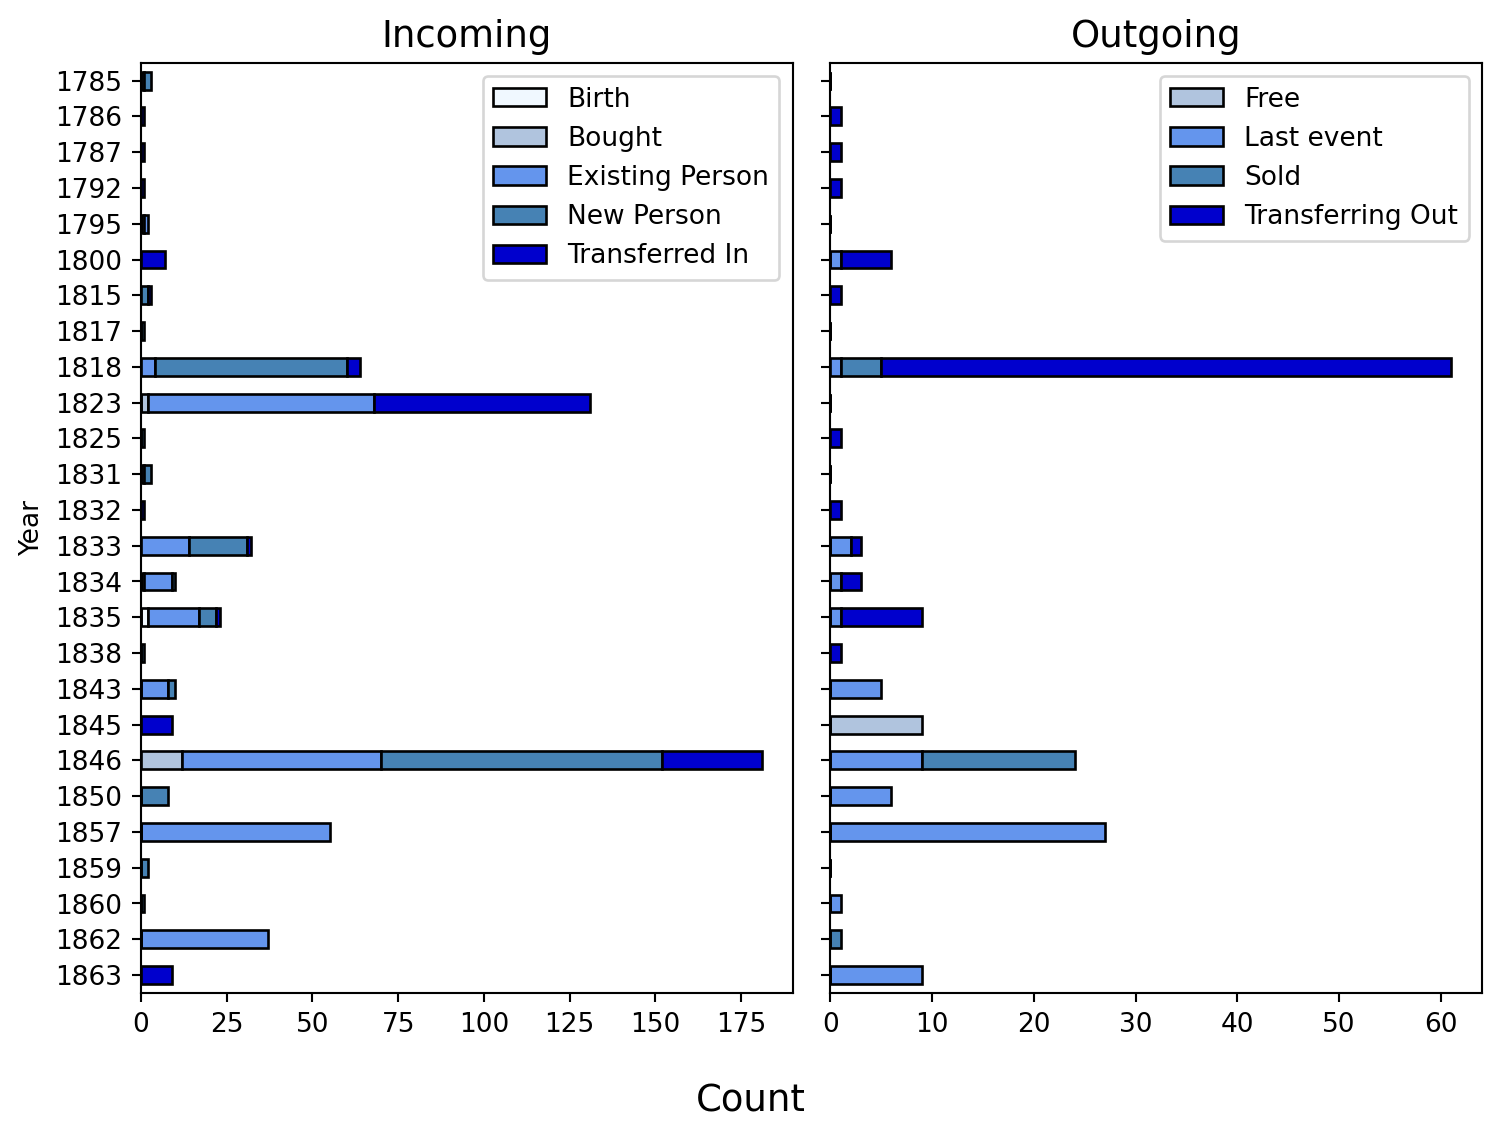

In [172]:
df= SJ.copy()

a= df.groupby(['Year'])['RN'].nunique().to_frame().rename(columns={'RN':'total'})
b = df.groupby(['RN','Year']).first().reset_index()
b = df.groupby(['Year','IN'])['RN'].nunique().to_frame().reset_index().pivot(index=['Year'], columns='IN', values='RN').reset_index().sort_values('Year').set_index('Year')
c = a.join(b).fillna(0)

e = df.groupby(['RN','Year']).first().reset_index()
e = e.groupby(['Year','OUT'])['RN'].nunique().to_frame().reset_index().pivot(index=['Year'], columns='OUT', values='RN').reset_index().fillna(0).set_index('Year')
f = a.join(e)
f.head(10)

d= c.drop(columns={'total'})
g = f.drop(columns={'total', 'None'})

plt.rcParams["figure.figsize"] = (8, 6)
fig, (ax, ax2) = plt.subplots(ncols=2, sharey=True)
color = ['aliceblue', 'lightsteelblue', 'cornflowerblue', 'steelblue','mediumblue']
color2 = ['lightsteelblue', 'cornflowerblue', 'steelblue','mediumblue']
ax.set_title('Incoming', fontsize=14)
ax2.set_title('Outgoing', fontsize=14)

d.plot.barh(stacked=True, color= color, edgecolor='black', ax=ax)
plt.legend(loc='best')
plt.gca().invert_yaxis()

g.plot.barh(stacked=True, color= color2, edgecolor='black', ax=ax2)
plt.gca().invert_yaxis()
plt.legend(loc='best')
fig.supxlabel('Count', fontsize=14)

plt.tight_layout()
plt.show()

In [173]:
df= SJ.copy()
df['Year'] = ((df['Year']*2).round(-1)/2)
a = df.groupby(['Year'])['RN'].nunique().to_frame().rename(columns={'RN':'total'})
b = df.groupby(['RN','Year']).first().reset_index()
b = b.groupby(['Year','IN'])['RN'].nunique().to_frame().reset_index().pivot(index=['Year'], columns='IN', values='RN').reset_index().sort_values('Year').set_index('Year')

c = a.join(b).fillna(0)

e = df.groupby(['RN','Year']).last().reset_index()
e = e.groupby(['Year','OUT'])['RN'].nunique().to_frame().reset_index().pivot(index=['Year'], columns='OUT', values='RN').reset_index().fillna(0).set_index('Year')
f = a.join(e)

c


,total,Birth,Bought,Existing Person,New Person,Transferred In
Year,,,,,,
1785.0,4,0.0,0.0,0.0,2.0,2.0
1790.0,1,0.0,0.0,0.0,0.0,1.0
1795.0,1,0.0,1.0,0.0,0.0,0.0
1800.0,7,0.0,0.0,0.0,0.0,7.0
1815.0,3,0.0,0.0,0.0,3.0,0.0
1820.0,62,0.0,0.0,3.0,56.0,3.0
1825.0,68,0.0,2.0,2.0,1.0,63.0
1830.0,3,0.0,0.0,0.0,2.0,1.0
1835.0,34,3.0,0.0,7.0,23.0,1.0


In [174]:
f

,total,Last event,None,Sold,Transferring Out
Year,,,,,
1785.0,4,0.0,1.0,0.0,3.0
1790.0,1,0.0,0.0,0.0,1.0
1795.0,1,0.0,0.0,0.0,1.0
1800.0,7,1.0,1.0,0.0,5.0
1815.0,3,0.0,3.0,0.0,0.0
1820.0,62,2.0,1.0,4.0,55.0
1825.0,68,59.0,4.0,0.0,5.0
1830.0,3,0.0,2.0,0.0,1.0
1835.0,34,7.0,6.0,0.0,21.0


### Enslaved by Enslaver and Year at Soldier's Joy

In [175]:
df= SJ.copy()
df['Year'] = ((df['Year']*2).round(-1)/2)
df.groupby(['Year','Enslaver ID'])['RN'].nunique().to_frame().rename(columns={'RN':'total'})

total
Year   Enslaver ID       
1785.0 272.0            4
1790.0 272.0            1
1795.0 272.0            1
1800.0 272.0            7
1815.0 272.0            2
       1065.0           2
1820.0 272.0           62
       1065.0           1
1825.0 1065.0          68
1830.0 1065.0           3
1835.0 1065.0          34
1840.0 1065.0           1
1845.0 0.0              2
       1065.0           8
       1088.0         100
1850.0 1088.0           2
1855.0 1088.0          55
1860.0 1088.0          37
1865.0 1275.0           3
       1277.0           1
       1278.0           5

In [176]:
df= SJ.copy()
df['Year'] = (df['Year'].round(-1))
df.groupby(['Year','Enslaver ID'])['RN'].nunique().to_frame().rename(columns={'RN':'total'})

total
Year Enslaver ID       
1780 272.0            2
1790 272.0            3
1800 272.0            8
1820 272.0           63
     1065.0          69
1830 1065.0          26
1840 1065.0          25
1850 0.0              2
     1088.0         102
1860 1088.0          64
     1275.0           3
     1277.0           1
     1278.0           5

#### Montezuma

In [177]:
df = test[test['Place']=="Montezuma"]
people = df['RN'].drop_duplicates().tolist()
print(len(people))
MZenslavers=[265,271,280,283,677,1034,1320]
MZ =test[test['RN'].isin(people)]

MZ =MZ[MZ['Enslaver ID'].isin(MZenslavers)]


85


In [178]:
MZ['Enslaver ID'].value_counts()

Enslaver ID
271.0     103
1034.0     91
283.0      74
280.0      58
1320.0     43
677.0       5
265.0       4
Name: count, dtype: int64

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


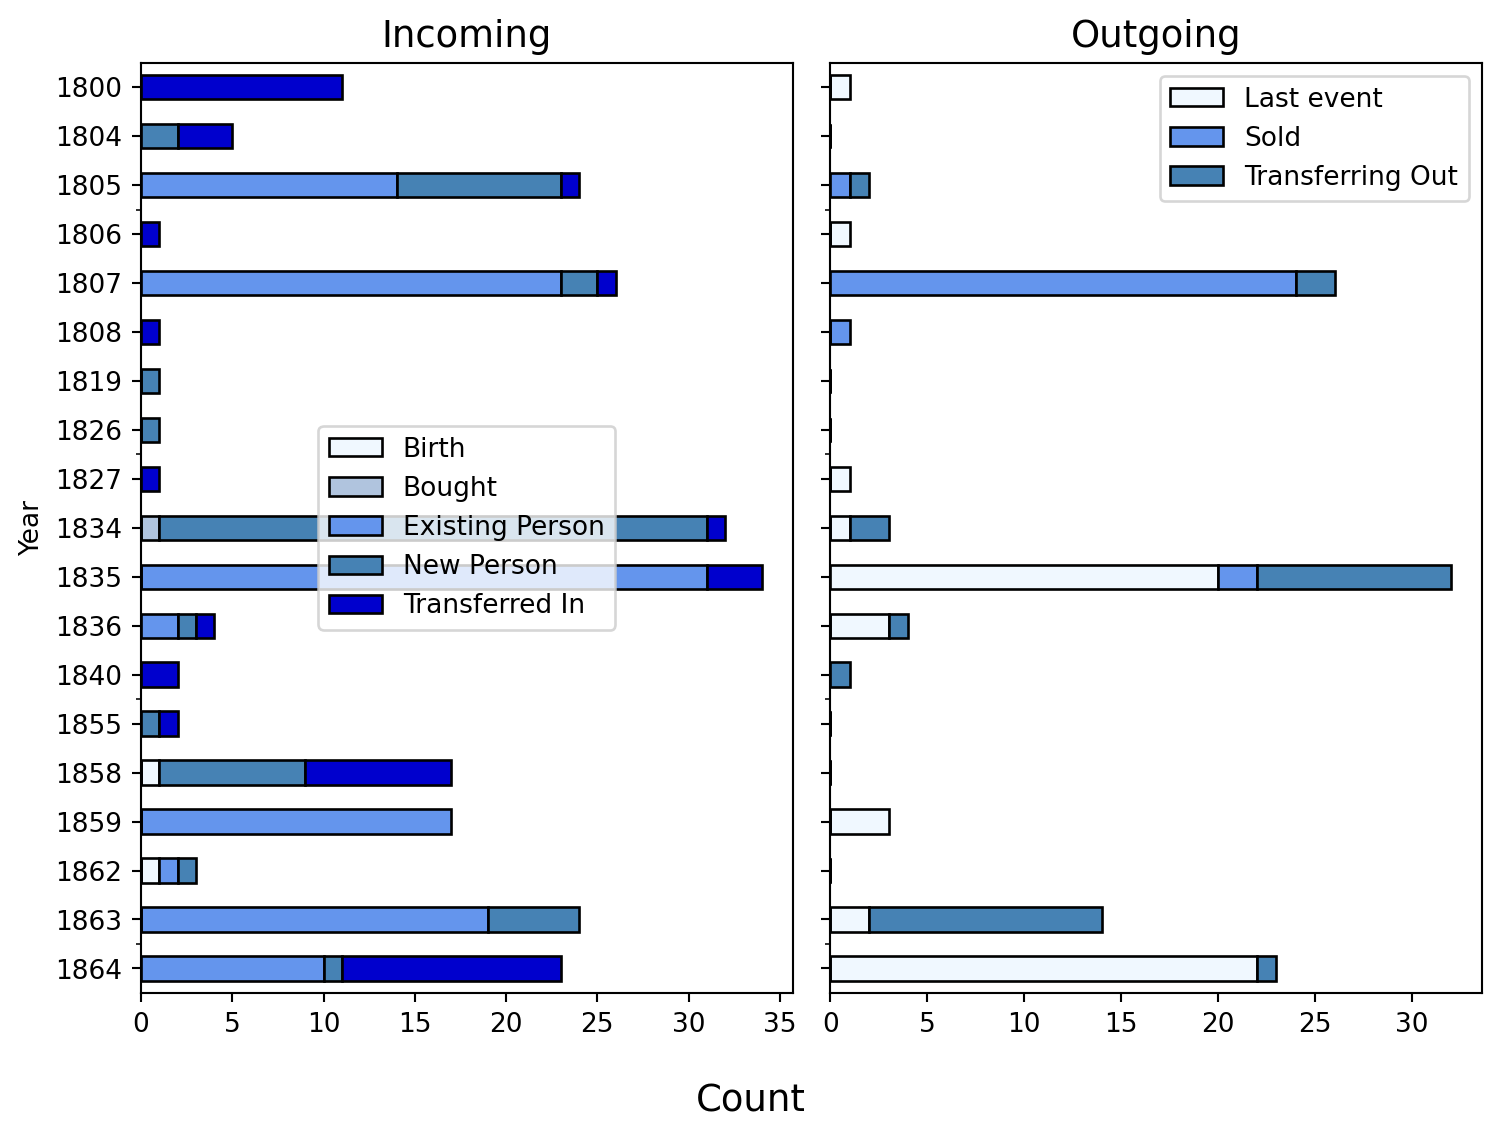

In [179]:
df= MZ.copy()
#df['Year'] = ((df['Year']*2).round(-1)/2).astype(int)
a = df.groupby(['Year'])['RN'].nunique().to_frame().rename(columns={'RN':'total'})
b = df.groupby(['RN','Year']).first().reset_index()
b = b.groupby(['Year','IN'])['RN'].nunique().to_frame().reset_index().pivot(index=['Year'], columns='IN', values='RN').reset_index().sort_values('Year').set_index('Year')

c = a.join(b).fillna(0)

e = df.groupby(['RN','Year']).last().reset_index()
e = e.groupby(['Year','OUT'])['RN'].nunique().to_frame().reset_index().pivot(index=['Year'], columns='OUT', values='RN').reset_index().fillna(0).set_index('Year')
f = a.join(e)
f.head(10)

d= c.drop(columns={'total'})
g = f.drop(columns={'total', 'None'})

plt.rcParams["figure.figsize"] = (8, 6)
fig, (ax, ax2) = plt.subplots(ncols=2, sharey=True)
color = ['aliceblue', 'lightsteelblue', 'cornflowerblue', 'steelblue','mediumblue']
color2 = ['aliceblue',  'cornflowerblue', 'steelblue','mediumblue']
ax.set_title('Incoming', fontsize=14)
ax2.set_title('Outgoing', fontsize=14)

d.plot.barh(stacked=True, color= color, edgecolor='black', ax=ax)
plt.legend(loc='best')
plt.gca().invert_yaxis()

g.plot.barh(stacked=True, color= color2, edgecolor='black', ax=ax2)
plt.gca().invert_yaxis()
plt.legend(loc='best')
fig.supxlabel('Count', fontsize=14)

plt.tight_layout()
plt.show()

In [180]:
df= MZ.copy()
df['Year'] = ((df['Year']*2).round(-1)/2)
a = df.groupby(['Year'])['RN'].nunique().to_frame().rename(columns={'RN':'total'})
b = df.groupby(['RN','Year']).first().reset_index()
b = b.groupby(['Year','IN'])['RN'].nunique().to_frame().reset_index().pivot(index=['Year'], columns='IN', values='RN').reset_index().sort_values('Year').set_index('Year')

c = a.join(b).fillna(0)

e = df.groupby(['RN','Year']).last().reset_index()
e = e.groupby(['Year','OUT'])['RN'].nunique().to_frame().reset_index().pivot(index=['Year'], columns='OUT', values='RN').reset_index().fillna(0).set_index('Year')
f = a.join(e)
f.head(10)

d= c.drop(columns={'total'})
g = f.drop(columns={'total', 'None'})

c

,total,Birth,Bought,Existing Person,New Person,Transferred In
Year,,,,,,
1800.0,11,0.0,0.0,0.0,0.0,11.0
1805.0,28,0.0,0.0,10.0,13.0,5.0
1810.0,1,0.0,0.0,0.0,0.0,1.0
1820.0,1,0.0,0.0,0.0,1.0,0.0
1825.0,2,0.0,0.0,0.0,1.0,1.0
1835.0,36,0.0,1.0,2.0,31.0,2.0
1840.0,2,0.0,0.0,0.0,0.0,2.0
1855.0,2,0.0,0.0,0.0,1.0,1.0
1860.0,21,2.0,0.0,2.0,9.0,8.0


In [181]:
f

,total,Last event,None,Sold,Transferring Out
Year,,,,,
1800.0,11,1.0,10.0,0.0,0.0
1805.0,28,1.0,0.0,25.0,2.0
1810.0,1,0.0,0.0,1.0,0.0
1820.0,1,0.0,1.0,0.0,0.0
1825.0,2,1.0,1.0,0.0,0.0
1835.0,36,24.0,0.0,2.0,10.0
1840.0,2,0.0,1.0,0.0,1.0
1855.0,2,0.0,2.0,0.0,0.0
1860.0,21,3.0,18.0,0.0,0.0


### Enslaved by Enslaver and Year at Montezuma

In [182]:
df= MZ.copy()
df['Year'] = ((df['Year']*2).round(-1)/2)
df.groupby(['Year','Enslaver ID'])['RN'].nunique().to_frame().rename(columns={'RN':'total'})

total
Year   Enslaver ID       
1800.0 265.0            1
       271.0           10
1805.0 265.0            1
       271.0           28
1810.0 265.0            1
1820.0 283.0            1
1825.0 283.0            2
1835.0 265.0            1
       280.0           28
       283.0           34
       677.0            2
1840.0 1034.0           2
1855.0 1034.0           2
1860.0 1034.0          21
1865.0 280.0            4
       677.0            3
       1034.0          24
       1320.0          22

In [183]:
df= MZ.copy()
df['Year'] = (df['Year'].round(-1))
df.groupby(['Year','Enslaver ID'])['RN'].nunique().to_frame().rename(columns={'RN':'total'})

total
Year Enslaver ID       
1800 265.0            1
     271.0           25
1810 265.0            2
     271.0           26
1820 283.0            1
1830 265.0            1
     283.0           33
1840 280.0           28
     283.0           32
     677.0            2
     1034.0           2
1860 280.0            4
     677.0            3
     1034.0          27
     1320.0          22

#### Norwood

In [184]:
df = test[test['Place']=="Norwood"]
people = df['RN'].drop_duplicates().tolist()
print(len(people))

NWenslavers=[857]
NW =test[test['RN'].isin(people)]
NW =test[test['Enslaver ID'].isin(NWenslavers)]


58


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


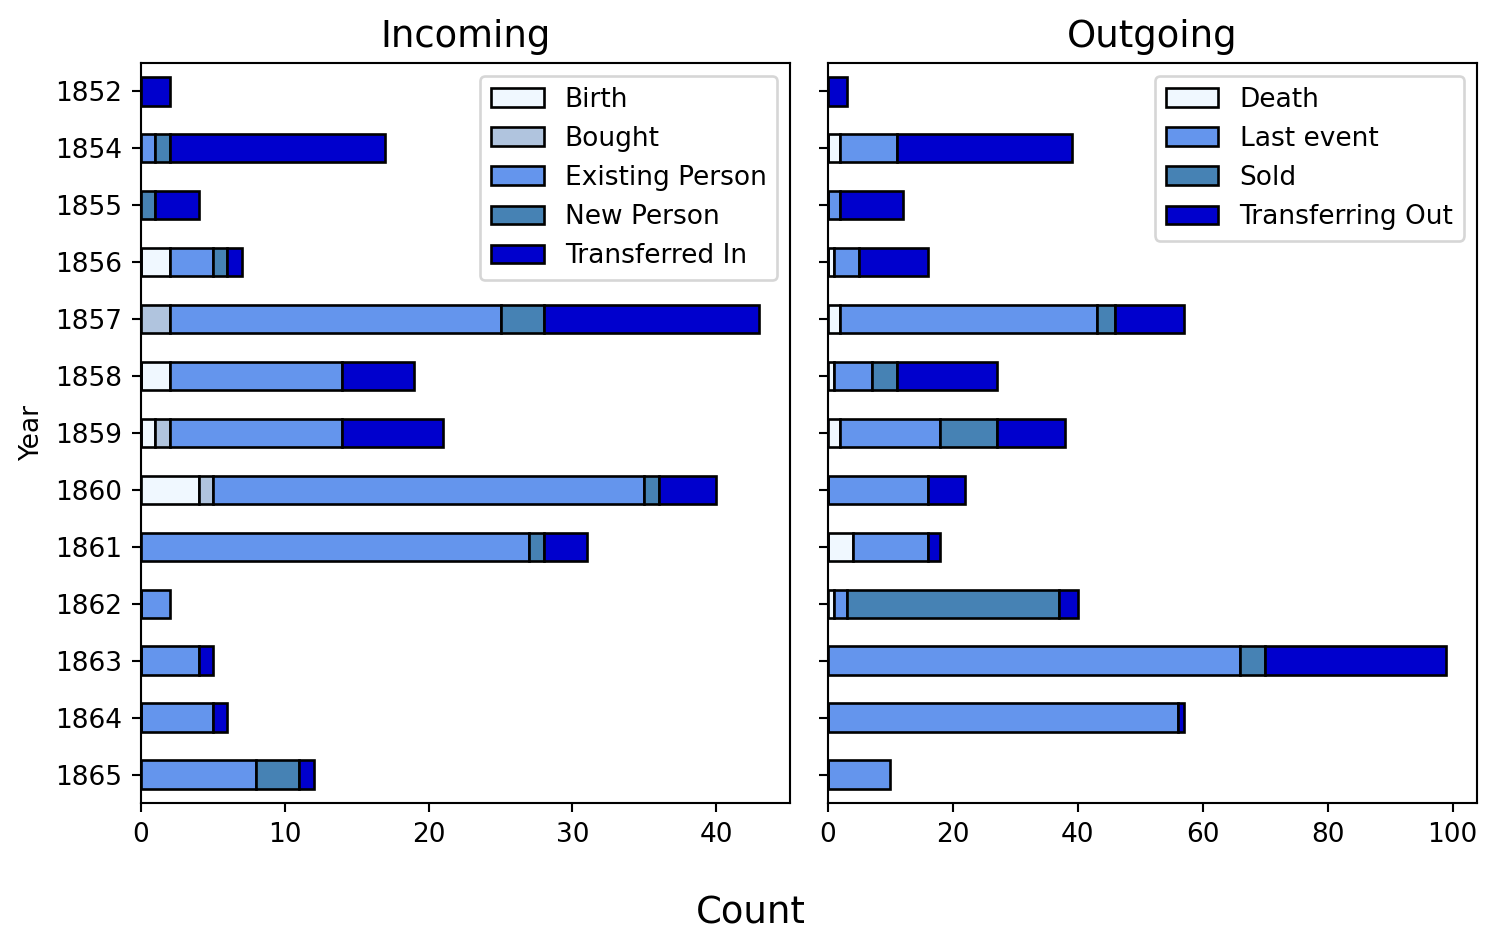

In [185]:
df= NW.copy()
a= df.groupby(['Year'])['RN'].nunique().to_frame().rename(columns={'RN':'total'})
b = df.groupby(['Year','IN'])['RN'].nunique().to_frame().reset_index().pivot(index=['Year'], columns='IN', values='RN').reset_index().sort_values('Year').set_index('Year')
c = a.join(b).fillna(0)

e = test.groupby(['Year','OUT'])['RN'].nunique().to_frame().reset_index().pivot(index=['Year'], columns='OUT', values='RN').reset_index().fillna(0).set_index('Year')
f = a.join(e)
f.head(10)

d= c.drop(columns={'total'})
g = f.drop(columns={'total', 'None','Free'})

plt.rcParams["figure.figsize"] = (8, 5)
fig, (ax, ax2) = plt.subplots(ncols=2, sharey=True)
color = ['aliceblue', 'lightsteelblue', 'cornflowerblue', 'steelblue','mediumblue']
color2 = ['aliceblue',  'cornflowerblue', 'steelblue','mediumblue']
ax.set_title('Incoming', fontsize=14)
ax2.set_title('Outgoing', fontsize=14)

d.plot.barh(stacked=True, color= color, edgecolor='black', ax=ax)
plt.legend(loc='best')
plt.gca().invert_yaxis()

g.plot.barh(stacked=True, color= color2, edgecolor='black', ax=ax2)
plt.gca().invert_yaxis()
plt.legend(loc='best')
fig.supxlabel('Count', fontsize=14)

plt.tight_layout()
plt.show()

In [186]:
df= NW.copy()
df['Year'] = ((df['Year']*2).round(-1)/2)
a = df.groupby(['Year'])['RN'].nunique().to_frame().rename(columns={'RN':'total'})
b = df.groupby(['RN','Year']).first().reset_index()
b = b.groupby(['Year','IN'])['RN'].nunique().to_frame().reset_index().pivot(index=['Year'], columns='IN', values='RN').reset_index().sort_values('Year').set_index('Year')

c = a.join(b).fillna(0)

e = df.groupby(['RN','Year']).last().reset_index()
e = e.groupby(['Year','OUT'])['RN'].nunique().to_frame().reset_index().pivot(index=['Year'], columns='OUT', values='RN').reset_index().fillna(0).set_index('Year')
f = a.join(e)
f.head(10)

d= c.drop(columns={'total'})
g = f.drop(columns={'total', 'None'})

c

,total,Birth,Bought,Existing Person,New Person,Transferred In
Year,,,,,,
1850.0,2,0.0,0.0,0.0,0.0,2.0
1855.0,32,2.0,1.0,1.0,6.0,22.0
1860.0,47,7.0,2.0,20.0,2.0,16.0
1865.0,17,0.0,0.0,12.0,3.0,2.0


In [187]:
f

,total,Death,Last event,None,Sold,Transferring Out
Year,,,,,,
1850.0,2,0.0,0.0,1.0,0.0,1.0
1855.0,32,0.0,3.0,20.0,1.0,8.0
1860.0,47,4.0,24.0,12.0,0.0,7.0
1865.0,17,0.0,17.0,0.0,0.0,0.0


### Enslaved by Enslaver by Year at Norwood

In [188]:
df= NW.copy()
df['Year'] = ((df['Year']*2).round(-1)/2)
df.groupby(['Year','Enslaver ID'])['RN'].nunique().to_frame().rename(columns={'RN':'total'})

,,total
Year,Enslaver ID,
1850.0,857.0,2
1855.0,857.0,32
1860.0,857.0,47
1865.0,857.0,17


In [189]:
df= NW.copy()
df['Year'] = (df['Year'].round(-1))
df.groupby(['Year','Enslaver ID'])['RN'].nunique().to_frame().rename(columns={'RN':'total'})

,,total
Year,Enslaver ID,
1850,857.0,17
1860,857.0,59


#### Colleton

In [190]:
df = test[test['Place']=="Colleton"]
people = df['RN'].drop_duplicates().tolist()
print(len(people))

CT =test[test['RN'].isin(people)]
CT = CT[CT['Enslaver ID'] != 46]
CT = CT[CT['Enslaver ID'] != 45]
CT= CT.loc[(CT['Year'].between(1760, 1801)) | (CT['Year']>1850)]


120


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


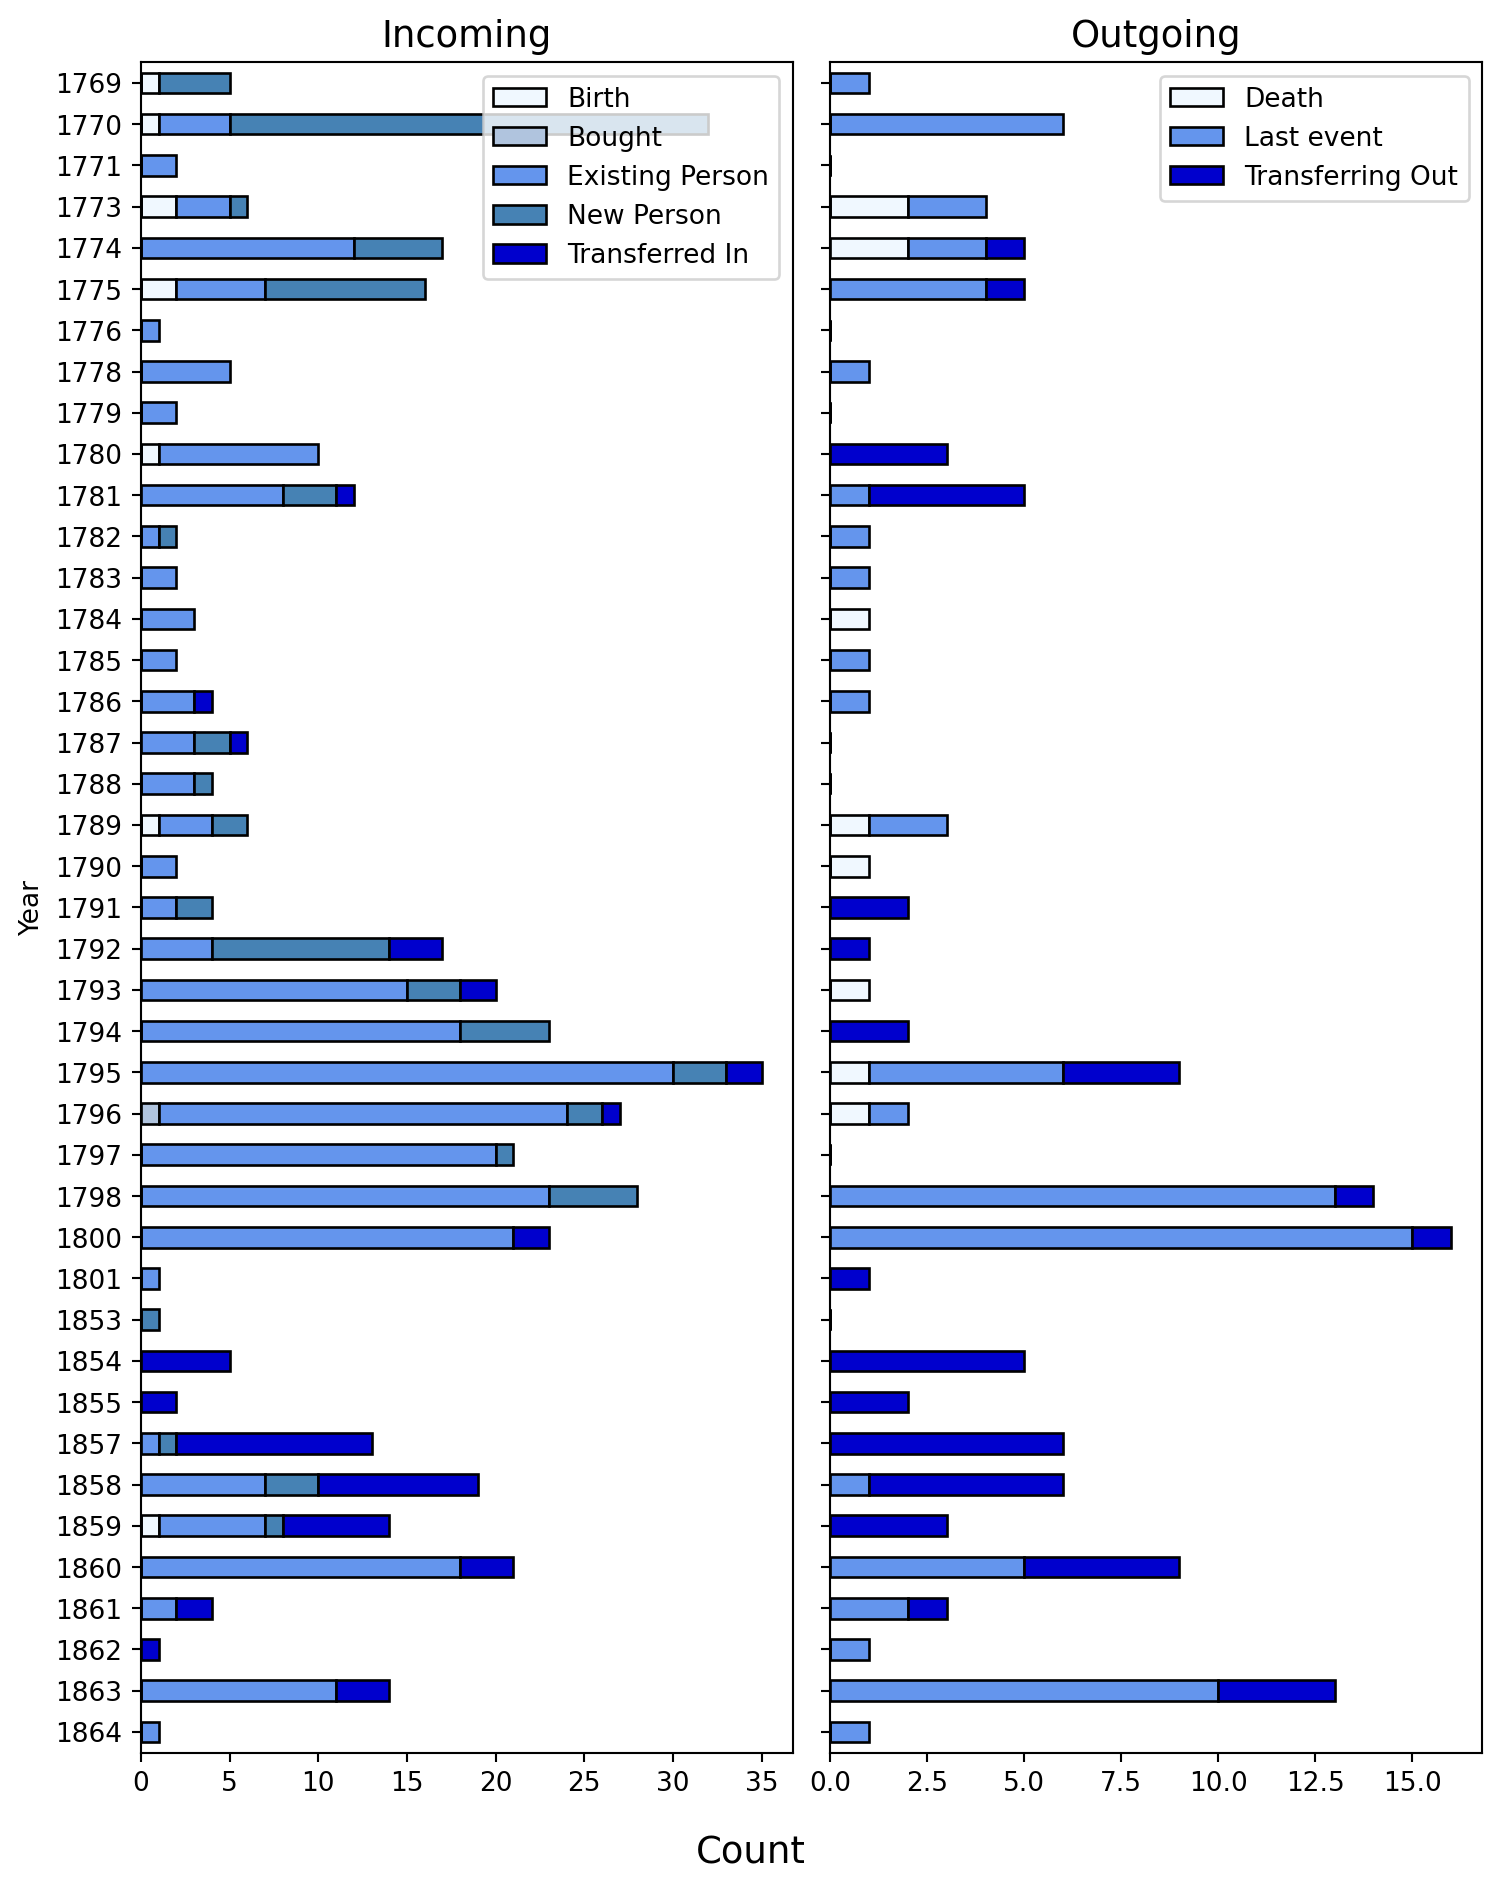

In [191]:
df= CT.copy()
#df['Year'] = ((df['Year']*2).round(-1)/2).astype(int)
a = df.groupby(['Year'])['RN'].nunique().to_frame().rename(columns={'RN':'total'})
b = df.groupby(['RN','Year']).first().reset_index()
b = b.groupby(['Year','IN'])['RN'].nunique().to_frame().reset_index().pivot(index=['Year'], columns='IN', values='RN').reset_index().sort_values('Year').set_index('Year')

c = a.join(b).fillna(0)

e = df.groupby(['RN','Year']).last().reset_index()
e = e.groupby(['Year','OUT'])['RN'].nunique().to_frame().reset_index().pivot(index=['Year'], columns='OUT', values='RN').reset_index().fillna(0).set_index('Year')
f = a.join(e)
f.head(10)

d= c.drop(columns={'total'})
g = f.drop(columns={'total', 'None'})

plt.rcParams["figure.figsize"] = (8, 10)
fig, (ax, ax2) = plt.subplots(ncols=2, sharey=True)
color = ['aliceblue', 'lightsteelblue', 'cornflowerblue', 'steelblue','mediumblue']
color2 = ['aliceblue',  'cornflowerblue', 'mediumblue']
ax.set_title('Incoming', fontsize=14)
ax2.set_title('Outgoing', fontsize=14)

d.plot.barh(stacked=True, color= color, edgecolor='black', ax=ax)
plt.legend(loc='best')
plt.gca().invert_yaxis()

g.plot.barh(stacked=True, color= color2, edgecolor='black', ax=ax2)
plt.gca().invert_yaxis()
plt.legend(loc='best')
fig.supxlabel('Count', fontsize=14)

plt.tight_layout()
plt.show()

In [192]:
df= CT.copy()
df['Year'] = ((df['Year']*2).round(-1)/2)
a = df.groupby(['Year'])['RN'].nunique().to_frame().rename(columns={'RN':'total'})
b = df.groupby(['RN','Year']).first().reset_index()
b = b.groupby(['Year','IN'])['RN'].nunique().to_frame().reset_index().pivot(index=['Year'], columns='IN', values='RN').reset_index().sort_values('Year').set_index('Year')

c = a.join(b).fillna(0)

e = df.groupby(['RN','Year']).last().reset_index()
e = e.groupby(['Year','OUT'])['RN'].nunique().to_frame().reset_index().pivot(index=['Year'], columns='OUT', values='RN').reset_index().fillna(0).set_index('Year')
f = a.join(e)
f.head(10)

d= c.drop(columns={'total'})
g = f.drop(columns={'total', 'None'})

c

,total,Birth,Existing Person,New Person,Transferred In
Year,,,,,
1770.0,33,2.0,0.0,31.0,0.0
1775.0,36,4.0,17.0,15.0,0.0
1780.0,23,1.0,18.0,4.0,0.0
1785.0,14,0.0,10.0,2.0,2.0
1790.0,28,1.0,10.0,15.0,2.0
1795.0,46,0.0,28.0,14.0,4.0
1800.0,46,0.0,39.0,5.0,2.0
1855.0,13,0.0,0.0,2.0,11.0
1860.0,23,1.0,7.0,4.0,11.0


In [193]:
f

,total,Death,Last event,None,Transferring Out
Year,,,,,
1770.0,33,0.0,7.0,26.0,0.0
1775.0,36,4.0,8.0,22.0,2.0
1780.0,23,0.0,3.0,14.0,6.0
1785.0,14,1.0,3.0,10.0,0.0
1790.0,28,2.0,2.0,22.0,2.0
1795.0,46,3.0,6.0,34.0,3.0
1800.0,46,0.0,28.0,15.0,3.0
1855.0,13,0.0,0.0,7.0,6.0
1860.0,23,0.0,9.0,11.0,3.0


### Enslaved by Enslaver by Year at Colleton

In [194]:
df= CT.copy()
df['Year'] = ((df['Year']*2).round(-1)/2)
df.groupby(['Year','Enslaver ID'])['RN'].nunique().to_frame().rename(columns={'RN':'total'})

total
Year   Enslaver ID       
1770.0 43.0            33
1775.0 43.0            36
1780.0 43.0            22
       44.0             4
1785.0 43.0            12
       44.0             3
       272.0            1
       1174.0           1
1790.0 43.0            11
       44.0            18
       131.0            1
       137.0            1
       142.0            1
1795.0 43.0            13
       44.0            34
       187.0            1
1800.0 43.0            21
       44.0            25
       262.0            1
       269.0            2
       271.0            4
       272.0            2
1855.0 216.0            4
       857.0            6
       858.0            8
       866.0            2
1860.0 216.0            3
       857.0            7
       858.0           21
       919.0            1
1865.0 857.0            1
       858.0           14

In [195]:
df= CT.copy()
df['Year'] = (df['Year'].round(-1))
df.groupby(['Year','Enslaver ID'])['RN'].nunique().to_frame().rename(columns={'RN':'total'})

total
Year Enslaver ID       
1770 43.0            41
1780 43.0            35
     44.0             4
1790 43.0            18
     44.0            28
     131.0            1
     137.0            1
     142.0            1
     187.0            1
     272.0            1
     1174.0           1
1800 43.0            27
     44.0            33
     262.0            1
     269.0            2
     271.0            4
     272.0            2
1850 216.0            1
     857.0            4
     866.0            2
1860 216.0            4
     857.0           10
     858.0           23
     919.0            1

In [196]:
RK = test[test['Place']=="Rock Cliff"]
RK = RK[RK['Enslaver ID'] != 46]
RK = RK[RK['Enslaver ID'] != 45]
RK['Year'] = ((RK['Year']*2).round(-1)/2)
RK.groupby(['Year','Enslaver ID'])['RN'].nunique().to_frame().rename(columns={'RN':'total'})

,,total
Year,Enslaver ID,
1860.0,919.0,1
1865.0,919.0,2


### Events by Source and Plantation

#### Combine all non-plantation locations into one group

In [197]:
plantations = ['Colleton','Montezuma','Norwood',"Soldier's Joy",'Union Hill']

#### Create look up of Source number with source type

In [198]:
journals = [1,2,3,4,5,6,7,8,11,12,13,14,16,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,56,58]
court = [15,18,19,20,21,23,24,25,26,27,28,29,57,61,66,67,68,72]
adv= [9,10,22,65,70,71]
chancery = [17,69,74]
rolls = [52,59,60,62,63,64,73]
FB = [53,55]


### Look at number of events by source type and plantation

In [199]:
df= enslaved[enslaved['Event Type'] !='Enslaved']
df = df[['Place','Source','Event Type']]
df['Place'] = df['Place'].where(df['Place'].isin(plantations),'other') 
print(df.shape)
df['Source'] = df['Source'].astype(float)
df= df.drop_duplicates().sort_values('Source').dropna()
print(df.shape)
#add column for source type
df['Type'] = 'other'
df['Type'] = df['Type'].where(~df['Source'].isin(journals),'journal') 
df['Type'] = df['Type'].where(~df['Source'].isin(court),'court') 
df['Type'] = df['Type'].where(~df['Source'].isin(adv),'adv') 
df['Type'] = df['Type'].where(~df['Source'].isin(chancery),'chancery') 
df['Type'] = df['Type'].where(~df['Source'].isin(rolls),'rolls') 
df['Type'] = df['Type'].where(~df['Source'].isin(FB),'Freedman') 
print(df['Type'].value_counts())
df.head()

(2692, 3)
(246, 3)
Type
journal     194
court        23
rolls        13
Freedman      6
adv           5
chancery      4
other         1
Name: count, dtype: int64


,Place,Source,Event Type,Type
1434,Colleton,1.0,Necessities,journal
1416,Colleton,1.0,Birth,journal
1867,Colleton,1.0,Transfer,journal
1788,Colleton,1.0,Disappeared,journal
1804,Colleton,2.0,Illness,journal


In [200]:
a = df.groupby(['Place','Type'])['Event Type'].nunique().reset_index().sort_values(['Place','Type']).set_index(['Place','Type'])

#### Look at number of persons identified by source type and location


In [201]:
df= enslaved[enslaved['Event Type'] !='Enslaved']
df = df[['Place','Source','RN']]
df['Place'] = df['Place'].where(df['Place'].isin(plantations),'other') 
print(df.shape)
df['Source'] = df['Source'].astype(float)
df= df.drop_duplicates().sort_values('Source').dropna()
print(df.shape)
#add column for source type
df['Type'] = 'other'
df['Type'] = df['Type'].where(~df['Source'].isin(journals),'journal') 
df['Type'] = df['Type'].where(~df['Source'].isin(court),'court') 
df['Type'] = df['Type'].where(~df['Source'].isin(adv),'adv') 
df['Type'] = df['Type'].where(~df['Source'].isin(chancery),'chancery') 
df['Type'] = df['Type'].where(~df['Source'].isin(rolls),'rolls') 
df['Type'] = df['Type'].where(~df['Source'].isin(FB),'Freedman') 
print(df['Type'].value_counts())
df.head()

(2692, 3)
(1787, 3)
Type
journal     1070
court        395
rolls        109
chancery      90
adv           85
Freedman      37
other          1
Name: count, dtype: int64


,Place,Source,RN,Type
1918,Colleton,1.0,10,journal
1434,Colleton,1.0,40,journal
1523,Colleton,1.0,16,journal
1524,Colleton,1.0,17,journal
1539,Colleton,1.0,18,journal


In [202]:
b = df.groupby(['Place','Type'])['RN'].nunique().reset_index().sort_values(['Place','Type']).set_index(['Place','Type']).rename(columns={'RN':'People'})

In [203]:
c= a.join(b)
c

Event Type  People
Place         Type                        
Colleton      adv                1       2
              journal           17     117
              rolls              1      16
Montezuma     Freedman           1       4
              adv                1      47
              chancery           1      23
              court              3      71
              journal            2      23
              rolls              2       5
Norwood       Freedman           1       6
              journal           15      56
              rolls              3      20
Soldier's Joy Freedman           1       4
              adv                1      36
              chancery           2      64
              court              3      79
              journal            8      87
Union Hill    Freedman           1      16
              court              3     111
              journal           20     327
              other              1       1
              rolls              1      19
other         Freedman           2       7
              chancery           1       3
              court              4      30
              journal            6      42
              rolls              2      41

# Final Steps 

## Save final file to CSV. Drop duplicate columns used for analytics ('Year' and 'Birthdate')

In [204]:
enslaved = enslaved[['Person','Given Name','Alternate Name','Surname','Sex','RN','Birth date','Death date','Father','Mother','Spouses','Children','Event ID','Event Type','Place','lat','long','Status','Enslaver ID','Date','Description','Overseers','Source Description','Page','Repository']]
enslaved.head(2)

,Person,Given Name,Alternate Name,Surname,Sex,RN,Birth date,Death date,Father,Mother,Spouses,Children,Event ID,Event Type,Place,lat,long,Status,Enslaver ID,Date,Description,Overseers,Source Description,Page,Repository
0,PERS-CAB-PERS-CAB-259-UH-UH,Sam,NaN,NaN,M,259,1793,NaN,NaN,NaN,NaN,NaN,EVE-ENS-090,Enslaved,Unknown,NaN,NaN,Enslaved,PERS-CAB-0-UH,1808,Enslaver Unknown,NaN,NaN,NaN,NaN
1,PERS-CAB-PERS-CAB-1240-UH-UH,Creasy,NaN,NaN,F,1240,bef 1790,NaN,NaN,PERS-CAB-2-UH,NaN,NaN,EVE-ENS-090,Enslaved,Unknown,NaN,NaN,Enslaved,PERS-CAB-0-UH,1808,Enslaver Unknown,NaN,NaN,NaN,NaN


In [205]:
enslaved.to_csv("ExportUHEnslavedFull.txt", sep='\t', index=False, header=True)

# COMPLETE